<font size="7">**Goodreads Recommender Project**</font>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preview**

Let's read the books, ratings and tags files.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import sklearn
import os

books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
toread = pd.read_csv('to_read.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

Let's check the each column of read files.

In [ ]:
# Checking the columns of each DataFrame
books_columns = books.columns.tolist()
ratings_columns = ratings.columns.tolist()
toread_columns = toread.columns.tolist()
tags_columns = tags.columns.tolist()
book_tags_columns = book_tags.columns.tolist()

# Displaying the columns for interpretation
books_columns, ratings_columns, toread_columns, tags_columns, book_tags_columns


(['book_id',
  'goodreads_book_id',
  'best_book_id',
  'work_id',
  'books_count',
  'isbn',
  'isbn13',
  'authors',
  'original_publication_year',
  'original_title',
  'title',
  'language_code',
  'average_rating',
  'ratings_count',
  'work_ratings_count',
  'work_text_reviews_count',
  'ratings_1',
  'ratings_2',
  'ratings_3',
  'ratings_4',
  'ratings_5',
  'image_url',
  'small_image_url'],
 ['user_id', 'book_id', 'rating'],
 ['user_id', 'book_id'],
 ['tag_id', 'tag_name'],
 ['goodreads_book_id', 'tag_id', 'count'])

Let's see how books and ratings dataframe look like.

In [ ]:
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [ ]:
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


Let's check how many unique book IDs there are.

In [ ]:
books['book_id'].nunique()


10000

In [ ]:
books['goodreads_book_id'].nunique()


10000

We begin by removing duplicate ratings from the ratings DataFrame to ensure each user can only rate each book once. Next, we filter out users who have rated fewer than 20 books. We calculate the number of ratings per user with value_counts and then filter the ratings DataFrame to retain only users with at least 20 ratings, printing the change in the number of users. In the books DataFrame, we remove duplicate entries based on the 'title' column using the drop_duplicates method. Rows with missing values in the 'original_title' column are dropped using the dropna method. We then identify books with any NaN values and filter these out from the ratings DataFrame, ensuring that only books with complete data are considered.

In [ ]:
# Remove duplicate ratings
initial_rating_count = ratings.shape[0]
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
final_rating_count = ratings.shape[0]

# Print the change after removing duplicate ratings
print(f"Removed {initial_rating_count - final_rating_count} duplicate ratings")

# Remove users who have rated fewer than 20books
initial_user_count = ratings['user_id'].nunique()
ratings_count_per_user = ratings['user_id'].value_counts()
ratings = ratings[ratings['user_id'].isin(ratings_count_per_user[ratings_count_per_user >= 20].index)]
final_user_count = ratings['user_id'].nunique()

# Print the change after removing users with fewer than 20 ratings
print(f"Removed {initial_user_count - final_user_count} users with fewer than 3 ratings")


Removed 0 duplicate ratings
Removed 1 users with fewer than 3 ratings


In [ ]:
# Drop duplicates based on the 'title'
books.drop_duplicates(subset='title', inplace=True)

# Directly drop rows where 'original_title' is NaN
books.dropna(subset=['original_title'], inplace=True)

# Find book_ids with any NaN values in the entire row (adjust columns as necessary)
nan_book_ids = books[books.isnull().any(axis=1)]['book_id']

# Filter out these IDs from the ratings DataFrame using isin and ~ for negation
ratings = ratings[~ratings['book_id'].isin(nan_book_ids)]

# Now check the shape of the books DataFrame
print(books.shape)

(9381, 23)


# **Data Analysis**

**Number of Ratings per User**

We visualize the distribution of the number of ratings per user using a histogram, setting the x-axis limit from 3 to the maximum number of ratings any user has made.

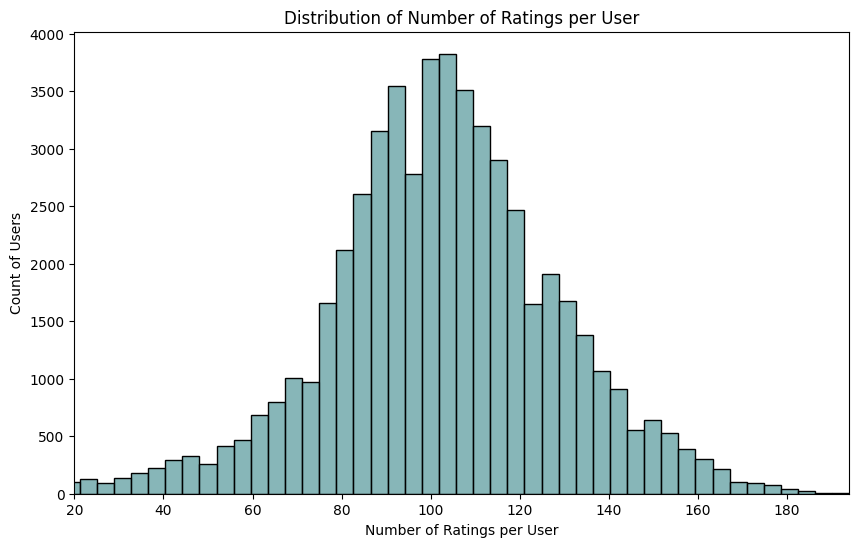

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of ratings per user
user_ratings_count = ratings['user_id'].value_counts().reset_index()
user_ratings_count.columns = ['user_id', 'number_of_ratings_per_user']

# Determine the maximum number of ratings a user has made
max_ratings = user_ratings_count['number_of_ratings_per_user'].max()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count['number_of_ratings_per_user'], bins=50, color="cadetblue", kde=False)
plt.xlim(20, max_ratings)  # Set the upper limit to the maximum number of ratings
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Count of Users')
plt.show()


We can see that are some users with many ratings. This is interesting, because we can later examine whether frequent raters rate books differently from less frequent raters.

**Distribution of Mean User Ratings**


We visualize the distribution of the mean ratings per user by calculating the average rating each user has given.

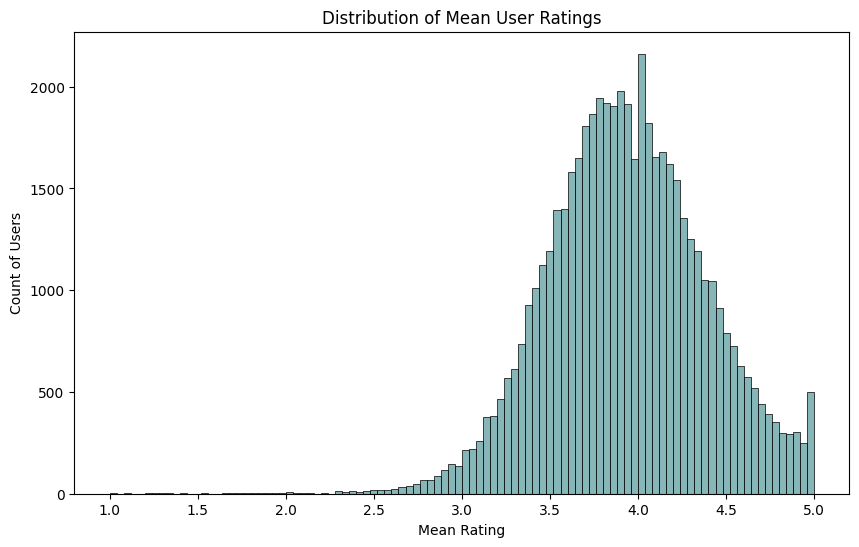

In [ ]:
# Calculate mean ratings per user
mean_ratings_user = ratings.groupby('user_id')['rating'].mean().reset_index()
mean_ratings_user.columns = ['user_id', 'mean_user_rating']

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(mean_ratings_user['mean_user_rating'], bins=100, color="cadetblue", kde=False)
plt.title('Distribution of Mean User Ratings')
plt.xlabel('Mean Rating')
plt.ylabel('Count of Users')
plt.show()


People have different tendencies to rate books. Such tendencies can be seen in the figure below. On the right side there is a bump from users with a mean rating of 5, indicating that they really liked all books (or they only rated books they really like...). We can also see that there are nearly no notoriuous downvoters rating all books with a 1.

**Number of Ratings per Book**

We visualize the distribution of the number of ratings per book by calculating how many ratings each book has received and plotting this data using a histogram.

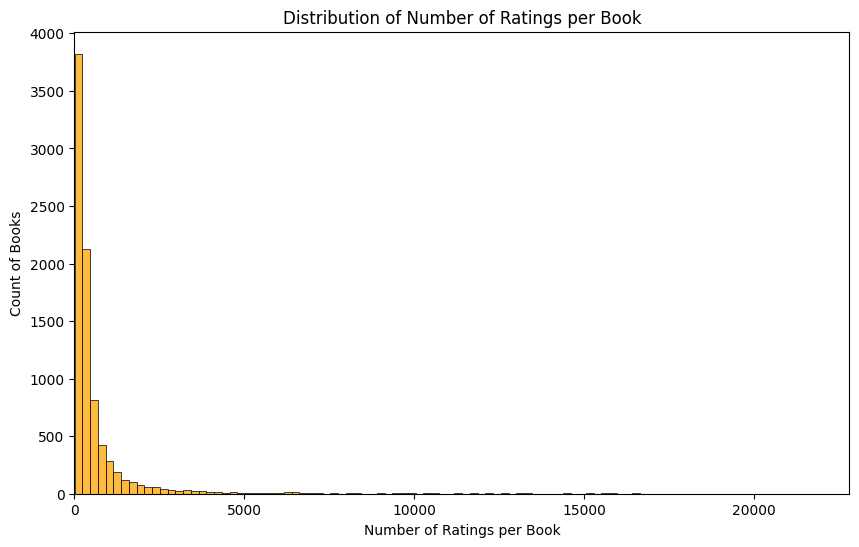

In [ ]:
# Calculate the number of ratings per book
book_ratings_count = ratings['book_id'].value_counts().reset_index()
book_ratings_count.columns = ['book_id', 'number_of_ratings_per_book']

# Determine the maximum number of ratings a book has received
max_ratings_per_book = book_ratings_count['number_of_ratings_per_book'].max()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(book_ratings_count['number_of_ratings_per_book'], bins=100, color="orange", kde=False)
plt.xlim(0, max_ratings_per_book)  # Set the upper limit to the maximum number of ratings per book
plt.title('Distribution of Number of Ratings per Book')
plt.xlabel('Number of Ratings per Book')
plt.ylabel('Count of Books')
plt.show()


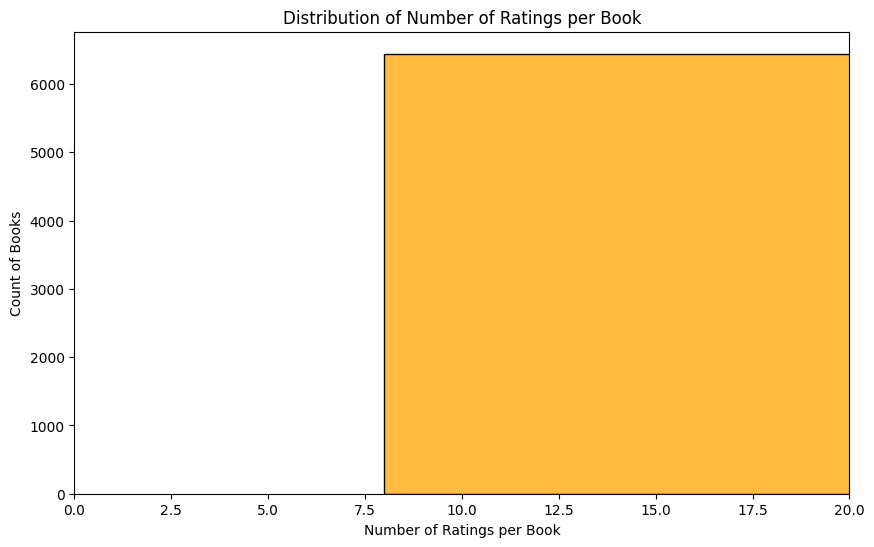

In [ ]:
# Calculate the number of ratings per book
book_ratings_count = ratings['book_id'].value_counts().reset_index()
book_ratings_count.columns = ['book_id', 'number_of_ratings_per_book']

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(book_ratings_count['number_of_ratings_per_book'], bins=40, color="orange", kde=False)
plt.xlim(0, 20)  # focusing on the range as per your R code
plt.title('Distribution of Number of Ratings per Book')
plt.xlabel('Number of Ratings per Book')
plt.ylabel('Count of Books')
plt.show()


We can see that in the subsetted dataset most books have around 18-20 ratings.

**Distribution of Mean Book Ratings**

We visualize the distribution of the mean ratings per book by calculating the average rating each book has received and plotting this data using a histogram.

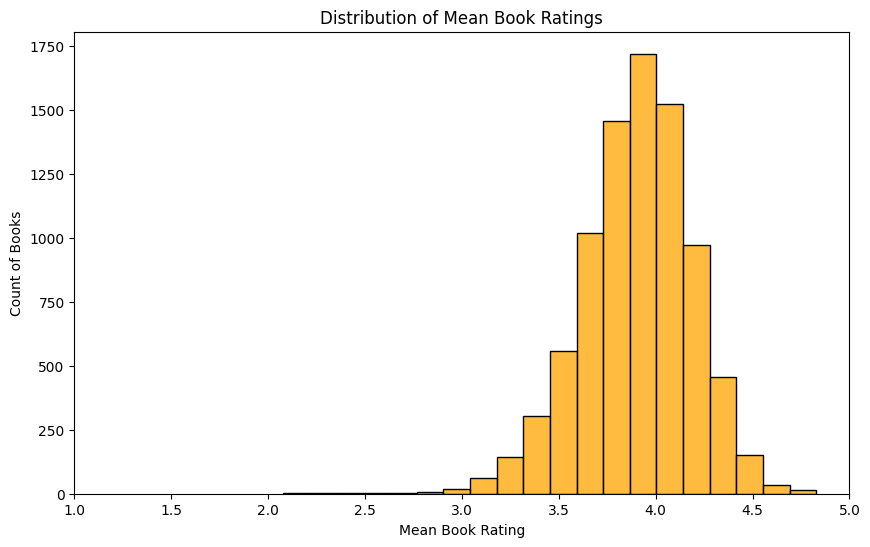

In [ ]:
# Calculate mean ratings per book
mean_ratings_book = ratings.groupby('book_id')['rating'].mean().reset_index()
mean_ratings_book.columns = ['book_id', 'mean_book_rating']

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(mean_ratings_book['mean_book_rating'], bins=20, color="orange", kde=False)
plt.title('Distribution of Mean Book Ratings')
plt.xlabel('Mean Book Rating')
plt.ylabel('Count of Books')
plt.xlim(1, 5)  # focusing on the range as per your R code
plt.show()


The concentration of books around the 4.0 mean rating suggests a generally positive reception among readers. This normal-like distribution, with its peak at 4.0, indicates that most books are rated favorably, while there are fewer books with extremely high or low average ratings.

**Distribution of Genres**

We visualize the distribution of selected book genres by calculating their relative percentages and plotting these as a bar chart.

<ipython-input-16-c28c64c35e7f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='percentage', y='tag_name', data=genre_counts, palette='YlOrRd')


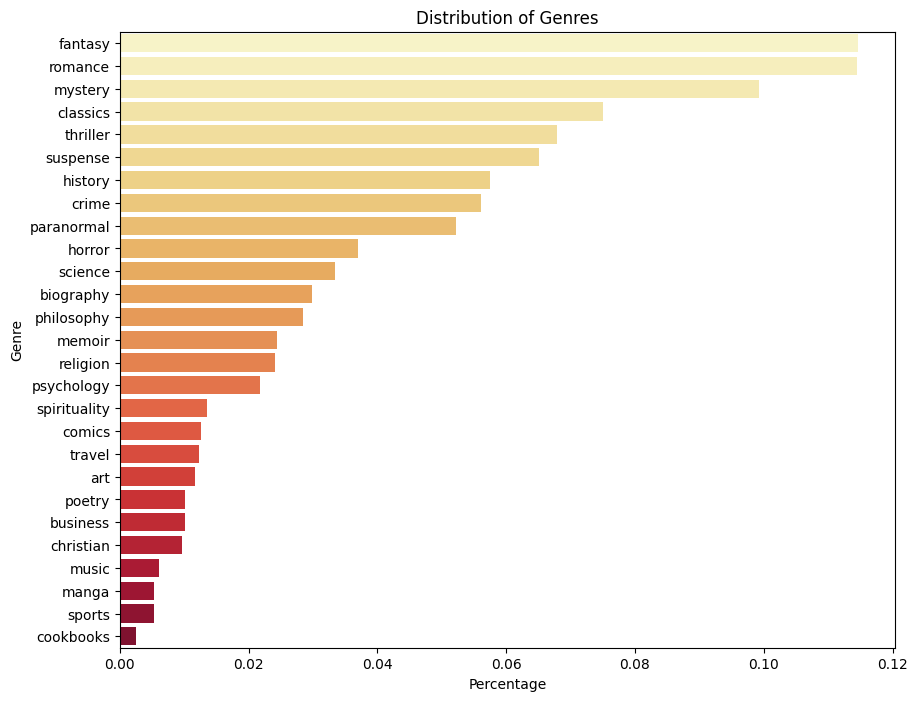

In [ ]:
import matplotlib.pyplot as plt

# Define genre list and exclusions
genres = ["art", "biography", "business", "chick lit", "children's", "christian", "classics", "comics",
          "contemporary", "cookbooks", "crime", "ebooks", "fantasy", "fiction", "gay and lesbian",
          "graphic novels", "historical fiction", "history", "horror", "humor and comedy", "manga",
          "memoir", "music", "mystery", "nonfiction", "paranormal", "philosophy", "poetry", "psychology",
          "religion", "romance", "science", "science fiction", "self help", "suspense", "spirituality",
          "sports", "thriller", "travel", "young adult"]
exclude_genres = ["fiction", "nonfiction", "ebooks", "contemporary"]
genres = [genre for genre in genres if genre not in exclude_genres]

# Filter tags to include only selected genres
filtered_tags = tags[tags['tag_name'].str.lower().isin(genres)]

# Join with book_tags to get the count of each genre
genre_counts = book_tags[book_tags['tag_id'].isin(filtered_tags['tag_id'])]
genre_counts = genre_counts.groupby('tag_id').size().reset_index(name='count')
genre_counts = genre_counts.merge(filtered_tags, on='tag_id')
genre_counts['percentage'] = genre_counts['count'] / genre_counts['count'].sum()

# Plotting
genre_counts = genre_counts.sort_values('percentage', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='percentage', y='tag_name', data=genre_counts, palette='YlOrRd')
plt.title('Distribution of Genres')
plt.xlabel('Percentage')
plt.ylabel('Genre')
plt.show()


The graph illustrates the distribution of various book genres as percentages of the total, with Fantasy emerging as the most prevalent genre, followed closely by Romance and Mystery. Significant representation is also seen in Classics, Thriller, and Suspense genres, while Science, Biography, Philosophy, and Memoir have moderate representations.

**Distribution of Books by Language**

We visualize the distribution of books by language by creating two bar charts: one including all languages and another excluding English variants, highlighting the counts of books for each language.

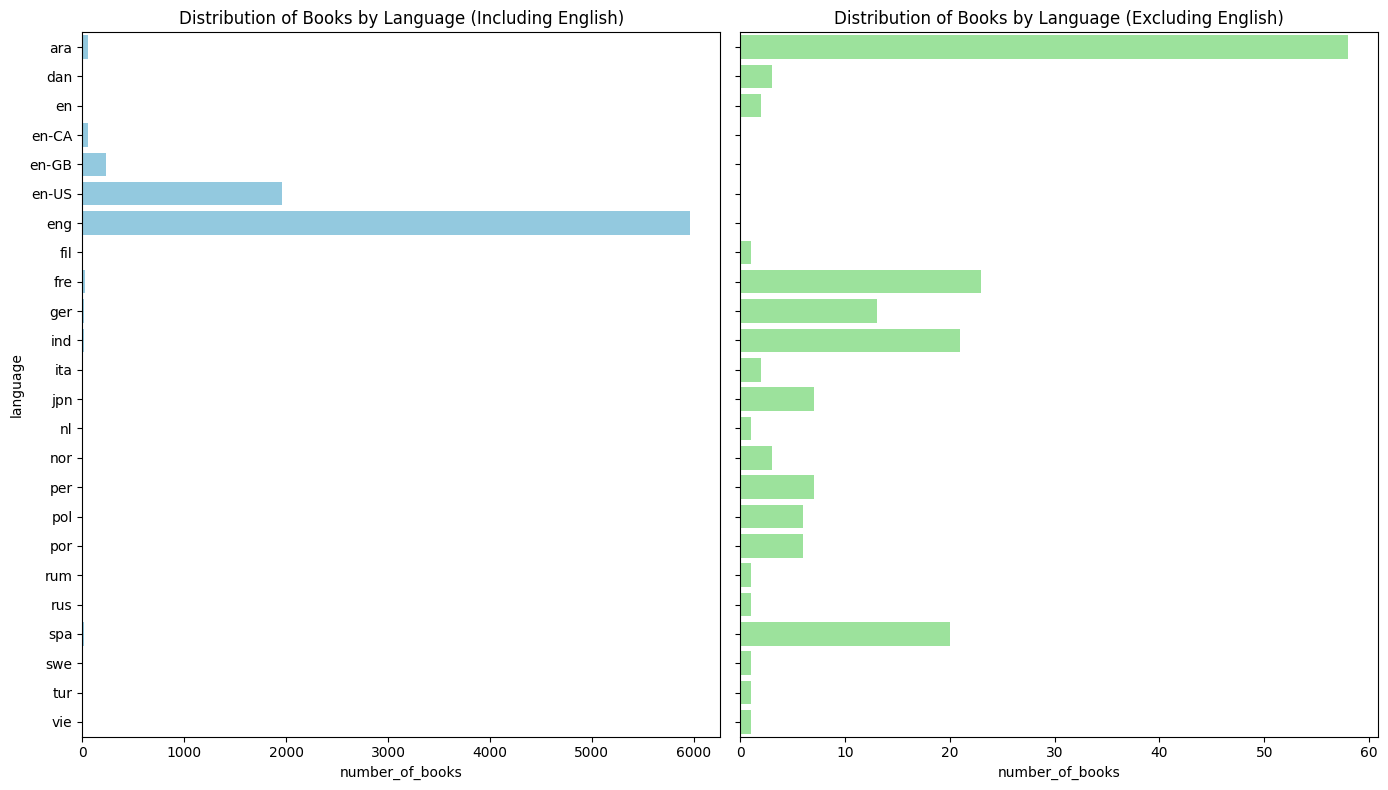

In [ ]:
# Prepare data
books['language_code'] = books['language_code'].astype('category')

# Include all languages
language_counts = books['language_code'].value_counts().reset_index()
language_counts.columns = ['language', 'number_of_books']

# Exclude English variants
non_english_counts = books[~books['language_code'].isin(['en-US', 'en-GB', 'eng', 'en-CA', ''])]['language_code'].value_counts().reset_index()
non_english_counts.columns = ['language', 'number_of_books']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
sns.barplot(x='number_of_books', y='language', data=language_counts, ax=ax[0], color='skyblue')
sns.barplot(x='number_of_books', y='language', data=non_english_counts, ax=ax[1], color='lightgreen')
ax[0].set_title('Distribution of Books by Language (Including English)')
ax[1].set_title('Distribution of Books by Language (Excluding English)')
plt.tight_layout()
plt.show()


The graph displays the distribution of books by language in two bar charts. The left chart includes all languages, showing a significant dominance of English (especially 'eng' and 'en-US' variants), which overshadow other languages. The right chart excludes English variants, providing a clearer view of non-English languages. In this chart, we observe that Spanish, German, and French have notable representations, while other languages like Italian, Portuguese, and Dutch also appear but with fewer books. The contrast between the two charts highlights the overwhelming presence of English-language books in the dataset.

**Top 10 Rated Books**

We can print the top10 rated books based on average rating:

In [ ]:
# Top 10 rated books
top_rated = books.nlargest(10, 'average_rating')
top_rated[['title', 'ratings_count', 'average_rating']]


,title,ratings_count,average_rating
3627,The Complete Calvin and Hobbes,28900,4.82
861,"Words of Radiance (The Stormlight Archive, #2)",73572,4.77
8853,Mark of the Lion Trilogy,9081,4.76
4482,It's a Magical World: A Calvin and Hobbes Coll...,22351,4.75
421,"Harry Potter Boxset (Harry Potter, #1-7)",190050,4.74
6360,There's Treasure Everywhere: A Calvin and Hobb...,16766,4.74
3752,"Harry Potter Collection (Harry Potter, #1-6)",24618,4.73
6589,The Authoritative Calvin and Hobbes: A Calvin ...,16087,4.73
6919,The Indispensable Calvin and Hobbes,14597,4.73
1307,A Court of Mist and Fury (A Court of Thorns an...,108384,4.72


**Top 10 Popular Books**

We can print the top10 popular books based on ratings count:

In [ ]:
# Top 10 popular books
top_popular = books.nlargest(10, 'ratings_count')
top_popular[['title', 'ratings_count', 'average_rating']]


,title,ratings_count,average_rating
0,"The Hunger Games (The Hunger Games, #1)",4780653,4.34
1,Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44
2,"Twilight (Twilight, #1)",3866839,3.57
3,To Kill a Mockingbird,3198671,4.25
4,The Great Gatsby,2683664,3.89
5,The Fault in Our Stars,2346404,4.26
6,The Hobbit,2071616,4.25
7,The Catcher in the Rye,2044241,3.79
9,Pride and Prejudice,2035490,4.24
8,"Angels & Demons (Robert Langdon, #1)",2001311,3.85


**Correlation Matrix for Book Ratings and Other Features**

We calculate the correlation matrix for selected book attributes and visualize it as a heatmap

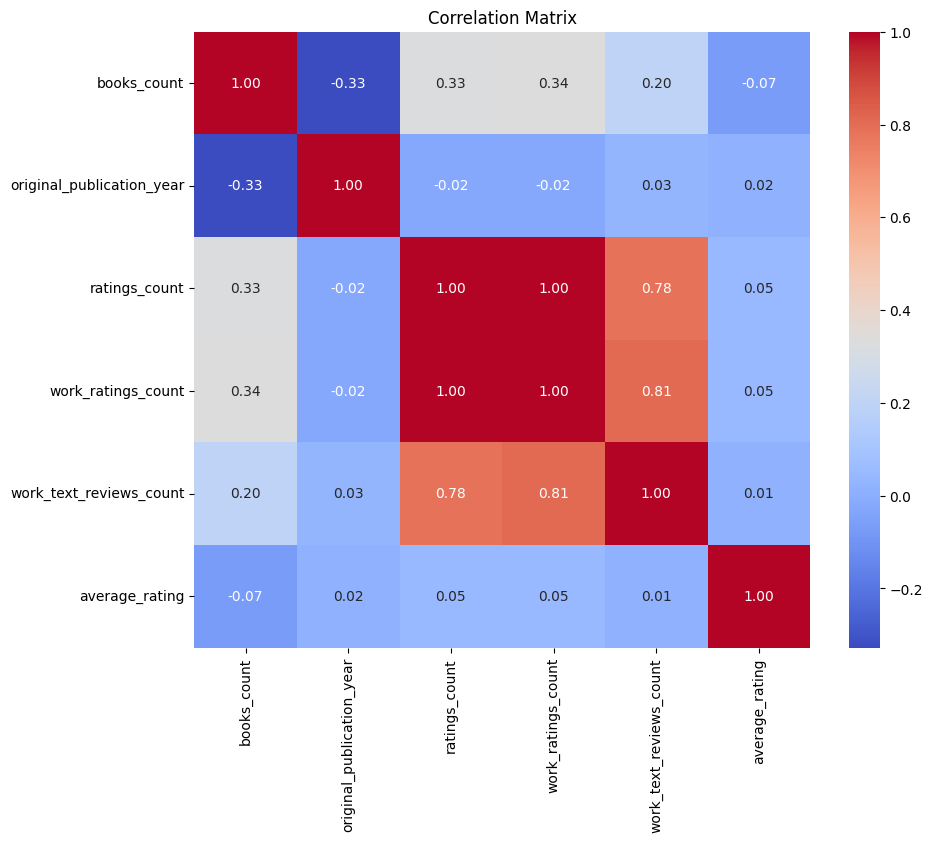

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant columns
selected_columns = books[['books_count', 'original_publication_year', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'average_rating']]
# Calculating the correlation matrix
corr_matrix = selected_columns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()


We see only small correlations between the features and the average rating (last row), indicating that there are no strong relationships between the rating a book receives and meta-variables (like rating counts etc.). This means that the rating depends more strongly on other features.


**Relationship Between Number of Ratings and Average Rating**

We filter out books with extreme ratings counts and create a hexbin plot to visualize the relationship between the number of ratings and the average rating

<Figure size 1000x800 with 0 Axes>

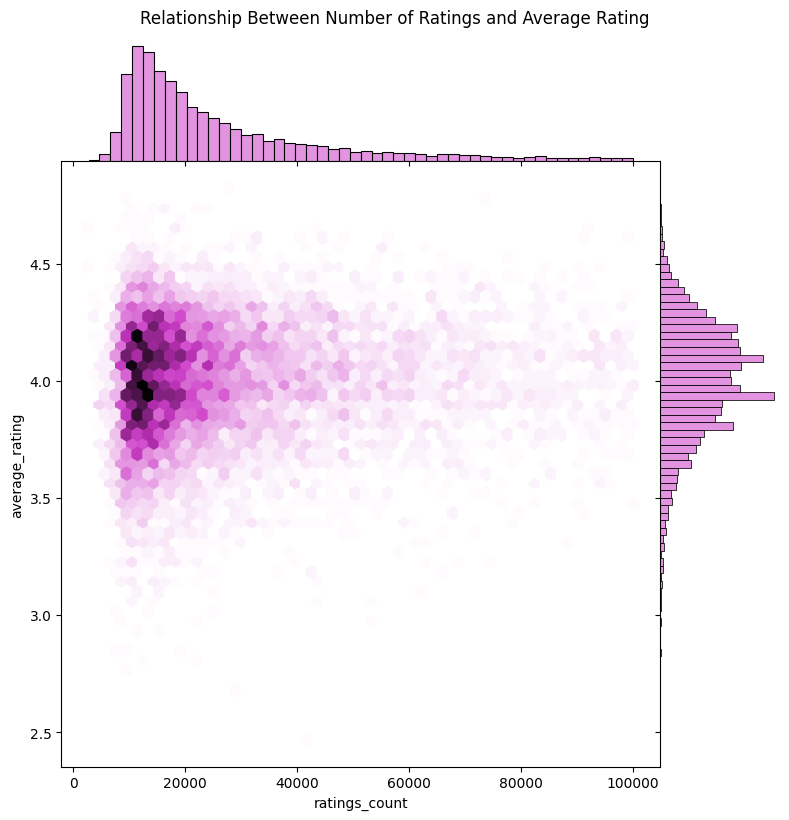

In [ ]:
# Filtering books with extreme values
filtered_books = books[books['ratings_count'] < 1e5]

# Plotting
plt.figure(figsize=(10, 8))
sns.jointplot(data=filtered_books, x='ratings_count', y='average_rating', kind='hex', color='orchid', height=8, space=0)
plt.suptitle('Relationship Between Number of Ratings and Average Rating', y=1.02)
plt.show()


Theoretically, it might be that the popularity of a book (in terms of the number of ratings it receives) is associated with the average rating it receives, such that once a book is becoming popular it gets better ratings. However, our data shows that this is not true always.

**Relationship Between Number of Editions and Average Rating**

We filter out books with more than 500 editions and create a hexbin plot to visualize the relationship between the number of editions and the average rating.

<Figure size 1000x800 with 0 Axes>

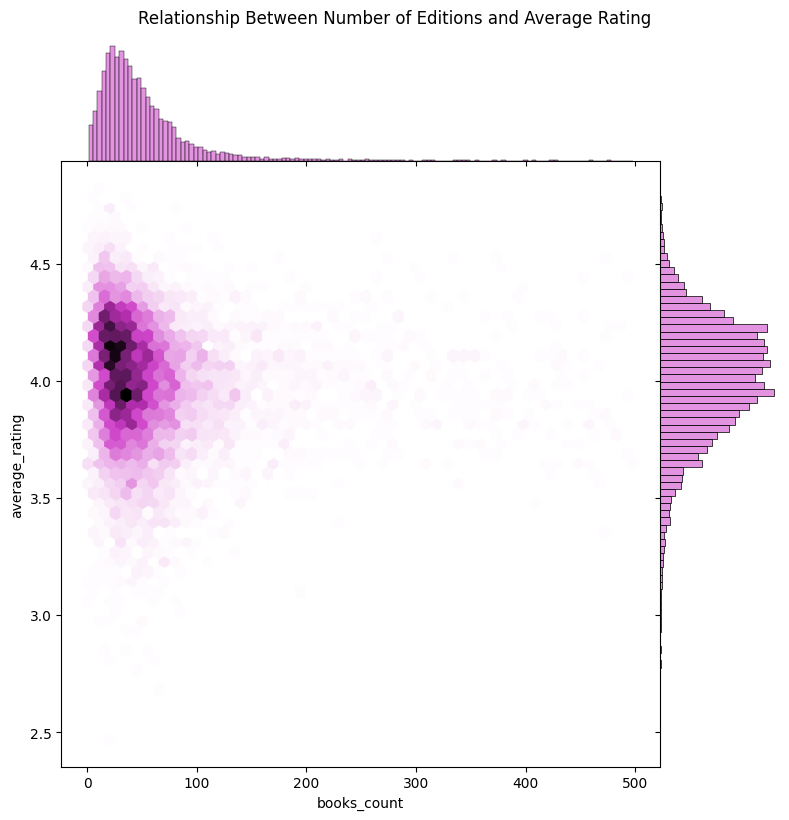

In [ ]:
# Filtering to avoid extremes
filtered_books = books[books['books_count'] <= 500]

# Plotting
plt.figure(figsize=(10, 8))
sns.jointplot(data=filtered_books, x='books_count', y='average_rating', kind='hex', color='orchid', height=8, space=0)
plt.suptitle('Relationship Between Number of Editions and Average Rating', y=1.02)
plt.show()


The dataset contains information about how many editions of a book are available in `book_count`. These can either be different editions in the same language or also translations of the book into different languages. So one might assume, that the better the book is the more editions should be available. However, from the plot above we can not see such correlation.

#### Graph Analysis

In [ ]:
import networkx as nx

B = nx.Graph()

# Prefixing user and book IDs
users = ['user_' + str(uid) for uid in ratings['user_id']]
books = ['book_' + str(bid) for bid in ratings['book_id']]

B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(books, bipartite=1)

edges = list(zip(users, books, ratings['rating']))
B.add_weighted_edges_from(edges)

print("Is graph bipartite:", nx.is_bipartite(B))

num_users = len([n for n in B.nodes() if B.nodes[n]['bipartite'] == 0])
num_books = len([n for n in B.nodes() if B.nodes[n]['bipartite'] == 1])
max_interactions = num_users * num_books
actual_interactions = B.number_of_edges()
sparsity_level= actual_interactions / max_interactions
print(sparsity_level)

degree_sequence = [d for n, d in B.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree: {average_degree}")

n_edge = B.number_of_edges()
print(n_edge)
n_nodes = B.number_of_nodes()
print(n_nodes)
degree_dict = dict(B.degree())

user_degrees = [degree_dict[n] for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
book_degrees = [degree_dict[n] for n in B.nodes() if B.nodes[n]['bipartite'] == 1]

average_degree_users = sum(user_degrees) / len(user_degrees) if user_degrees else 0
average_degree_books = sum(book_degrees) / len(book_degrees) if book_degrees else 0

print(average_degree_users)
print(average_degree_books)

user_book_assortativity = nx.degree_assortativity_coefficient(B)
print(user_book_assortativity)
user_degree_centrality = nx.bipartite.degree_centrality(B, ratings['user_id'])
book_degree_centrality = nx.bipartite.degree_centrality(B, ratings['book_id'])

average_user_degree_centrality = sum(user_degree_centrality.values()) / len(user_degree_centrality)
average_book_degree_centrality = sum(book_degree_centrality.values()) / len(book_degree_centrality)
print(average_user_degree_centrality)
print(average_book_degree_centrality)
density = nx.density(B)
print(density)

# **1) Content Filtering Based Approach**


Content-based filtering is a recommendation technique that makes use of information about the items themselves, rather than relying on user interactions or collaborative data. In this approach, each item (in this case, each book) is represented by a set of descriptive features. These features might include textual information, numerical data, and categorical data. By converting each item into a feature vector, we can compute similarities between items. The idea is that if a user likes a particular item, they are likely to enjoy other items that are similar to it based on these features.

For example, in a book recommendation system, books can be described by their titles, authors, genres, languages, and ratings. By analyzing the content of these features, the system can recommend books that are similar to the ones a user has already expressed interest in. This approach is particularly useful when user interaction data is sparse or unavailable, as it relies purely on the item's intrinsic properties.

* The code begins by loading the datasets, duplicate ratings and books are removed, and users with fewer than 20 ratings are discarded. To make computations manageable, a random subset of 10% of the users is selected.

* The titles and authors are processed to create feature vectors using Word2Vec, a popular technique for generating vector representations of words. Titles and authors are tokenized and converted to vectors.

* Other features such as language, average rating, and ratings count are processed. Language is one-hot encoded, and numerical features are scaled. Genres are extracted and transformed using a MultiLabelBinarizer to create a binary matrix indicating the presence of each genre for each book.

* All the feature vectors (titles, authors, language, numeric features, and genres) are combined into a single sparse matrix. The cosine similarity between books is computed to determine the similarity between their feature vectors.

* Finally, the recommend_books function takes a book title and returns a list of similar books based on the computed cosine similarity.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from gensim.models import Word2Vec
import gensim
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error

# Load DataFrames
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.01 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Prepare text data for Word2Vec
books['original_title'].fillna('unknown', inplace=True)
books['authors'] = books['authors'].str.replace(' ', '_')  # Replace spaces in names to treat them as single tokens
titles = books['original_title'].apply(lambda x: x.split())
authors = books['authors'].apply(lambda x: x.split(','))

# Train Word2Vec models
title_model = Word2Vec(sentences=titles, vector_size=50, window=3, min_count=1, workers=4)
author_model = Word2Vec(sentences=authors, vector_size=50, window=3, min_count=1, workers=4)

# Create feature vectors using Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=50):
    if len(tokens_list) < 1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    return np.mean(vectorized, axis=0)

books['title_vector'] = books['original_title'].apply(lambda x: get_average_word2vec(x.split(), title_model.wv))
books['author_vector'] = books['authors'].apply(lambda x: get_average_word2vec(x.split(','), author_model.wv))

# Combine Word2Vec features with other features
title_vectors = csr_matrix(list(books['title_vector']))
author_vectors = csr_matrix(list(books['author_vector']))
language_encoded = OneHotEncoder().fit_transform(books[['language_code']])
numeric_features = MinMaxScaler().fit_transform(books[['average_rating', 'ratings_count']])

# Preparing genre data
genres = ["art", "biography", "business", "chick lit", "children's", "christian", "classics", "comics",
          "contemporary", "cookbooks", "crime", "fantasy", "graphic novels", "historical fiction",
          "history", "horror", "humor and comedy", "manga", "memoir", "music", "mystery", "paranormal",
          "philosophy", "poetry", "psychology", "religion", "romance", "science", "science fiction",
          "self help", "suspense", "spirituality", "sports", "thriller", "travel", "young adult"]
exclude_genres = ["fiction", "nonfiction", "ebooks", "contemporary"]
genres = [genre for genre in genres if genre not in exclude_genres]
filtered_tags = tags[tags['tag_name'].str.lower().isin(genres)]
book_genre_tags = pd.merge(book_tags, filtered_tags, left_on='tag_id', right_on='tag_id')
book_genres = book_genre_tags.groupby('goodreads_book_id')['tag_name'].apply(list).reset_index()

# MultiLabel Binarizer for genre data
mlb = MultiLabelBinarizer()
book_genre_matrix = mlb.fit_transform(book_genres['tag_name'])
book_genre_df = pd.DataFrame(book_genre_matrix, columns=mlb.classes_, index=book_genres['goodreads_book_id'])

# Align books DataFrame with genre data
books.set_index('goodreads_book_id', inplace=True)
books = books.join(book_genre_df).fillna(0).reset_index()

feature_vectors = hstack([title_vectors, author_vectors, language_encoded, numeric_features, books[mlb.classes_]])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(feature_vectors, feature_vectors)

# Function to recommend books given a book title
def recommend_books(book_title, k=10):
    try:
        idx = books[books['original_title'] == book_title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:k+1]
        book_indices = [i[0] for i in sim_scores]
        return books.iloc[book_indices][['original_title', 'authors', 'average_rating']]
    except IndexError:
        return "Book title not found in the dataset."


The provided code defines a method called **split_ratings_custom**, which splits a dataset of user ratings into training and test sets based on various strategies. This flexibility is particularly useful in few-shot learning scenarios, where the model needs to make accurate predictions based on a limited amount of training data.

The **split_ratings_custom** method supports four main strategies for splitting the ratings:

* **Random Split:** In this strategy, a random subset of ratings is selected for the training set, with the number of ratings determined by the shot parameter. This approach ensures a random and unbiased distribution of training data, mimicking the randomness in few-shot learning where the training examples are limited and randomly selected.

* **Highest Ratings Split:** This strategy selects the highest ratings provided by each user for the training set. In few-shot learning, focusing on the most preferred items can be beneficial as it allows the model to learn from strong preferences, enhancing its ability to predict other high-rating items.

* **Lowest Ratings Split:** Conversely, this strategy selects the lowest ratings for the training set. In few-shot learning, this can help the model understand what items the user dislikes, which is equally important for making accurate recommendations and avoiding poor choices.

* **Percentage Split:** Instead of a fixed number of ratings, this strategy uses a specified percentage to split the data. A certain percentage of each user's ratings is allocated to the test set, with the rest used for training. This proportional split ensures that even with a limited dataset, the training and test sets are balanced, providing a comprehensive learning scenario for the model

In [ ]:
# Method to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Test the recommendation function
sample_book_title = books.iloc[1]['original_title']
print(f"Recommendations for: {sample_book_title}")
print(recommend_books(sample_book_title))

Recommendations for: Harry Potter and the Philosopher's Stone
                                         original_title  \
17             Harry Potter and the Prisoner of Azkaban   
22              Harry Potter and the Chamber of Secrets   
23                  Harry Potter and the Goblet of Fire   
7355  The Dark Is Rising Sequence (The Dark Is Risin...   
24                 Harry Potter and the Deathly Hallows   
26               Harry Potter and the Half-Blood Prince   
3241       Harry Potter Collection (Harry Potter, #1-6)   
40                                  The Lightning Thief   
6467                                            Skellig   
90                                    The Secret Garden   

                                      authors  average_rating  
17    J.K._Rowling,_Mary_GrandPré,_Rufus_Beck            4.53  
22                J.K._Rowling,_Mary_GrandPré            4.37  
23                J.K._Rowling,_Mary_GrandPré            4.53  
7355                            

Now that we have generated book embeddings and created our train/test splits, the **recommend_books** function can suggest books based on a given title. However, it doesn't accommodate user-specific recommendations. To address this, we need to develop methods that can recommend books tailored to each individual user.

**Method 1: User Profile Vector**

The following code is designed to create user profile vectors based on their ratings and recommend books accordingly. Additionally, it evaluates the effectiveness of these recommendations using metrics such as RMSE (Root Mean Squared Error) and NDCG (Normalized Discounted Cumulative Gain).

**User Profile Vector Creation and Recommendation**

The `user_profile_vector_reconmend` function generates personalized book recommendations for a specific user based on their past ratings. It starts by splitting the dataset into training and testing sets using the 'split_ratings_custom' function, which depends on the chosen strategy, shot, and percentage parameters. From the training set, the function identifies the books rated by the user and retrieves their feature vectors from a precomputed sparse matrix (' feature_vectors_csr'). These feature vectors are weighted by the user's ratings to compute a weighted average feature vector, which effectively represents the user's profile.

To normalize the user profile vector, it is scaled to unit length, ensuring consistent similarity calculations. The cosine similarity between this normalized user profile vector and the feature vectors of all books in the dataset is computed. Books are then ranked by their similarity scores in descending order, and the top ' $k$ ' books that the user has not yet rated are recommended. These recommended books are returned with their titles, authors, and average ratings.


**Evaluation with NDCG and RMSE**

The evaluation of the recommendation system is handled by the `evaluate_recommender_with_ndcg` function. This function also splits the data into training and testing sets and initializes arrays to store actual and predicted ratings as well as NDCG scores. For each user in the testing set, the function checks if there are ratings in the training set to construct a profile vector. If the user has rated books in the training set, their profile vector is computed in the same manner as in the recommendation function.

For each book in the user's test set, the similarity between the book's feature vector and the user's profile vector is calculated. This similarity score is used to predict the rating for the book by multiplying it with the book's user rating. The actual and predicted ratings are stored for later evaluation. The function then calculates the Discounted Cumulative Gain (DCG) and NDCG scores for these ratings. DCG measures the gain from the user's actual ratings, discounted logarithmically based on the position of the result. NDCG normalizes this score by comparing it to the best possible DCG for the user's ratings, providing a measure of how well the recommended books' positions match the optimal ranking.

The Root Mean Squared Error (RMSE) is also computed between the actual and predicted ratings to assess the accuracy of the predictions. The average NDCG score and RMSE are returned as the evaluation metrics for the recommendation strategy. This evaluation framework allows for testing different recommendation strategies and shot values, which control how the dataset is split and how many ratings are considered.

The predicted rating for a book $j$ is calculated using the formula:

predicted rating for book $j=\frac{\sum_{i \in R} \text { (similarity between book } i \text { and user profile) } \times \text { ( rating for book } i \text { ) }}{\sum_{i \in R} \text { similarity between book } i \text { and user profile) }}$

This formula ensures that books similar to those the user liked have a higher influence on the predicted rating.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

feature_vectors_csr = feature_vectors.tocsr()

# Function to create user profile vector and recommend books
def user_profile_vector_recommend(user_id, ratings, strategy, shot, percentage, k=10):
    train_indices, test_indices = split_ratings_custom(ratings, strategy, shot, percentage)
    train_set = ratings.loc[train_indices]
    # Get user ratings from the train set
    user_ratings = train_set[train_set['user_id'] == user_id]
    if not user_ratings.empty:
        user_books = books[books['book_id'].isin(user_ratings['book_id'])]

        # Retrieve the feature vectors for books rated by this user
        user_feature_vectors = feature_vectors_csr[user_books.index]

        # Get the ratings and reshape for broadcasting
        weights = user_ratings.set_index('book_id').loc[user_books['book_id']]['rating'].values.reshape(-1, 1).flatten()

        # Compute weighted average feature vector
        weighted_feature_vector = np.average(user_feature_vectors.toarray(), axis=0, weights=weights)

        # Normalize the weighted vector to prevent scaling issues
        norm_weighted_feature_vector = weighted_feature_vector / np.linalg.norm(weighted_feature_vector)

        # Find similar books
        sim_scores = cosine_similarity(norm_weighted_feature_vector.reshape(1, -1), feature_vectors_csr)
        sim_scores = sim_scores.flatten()
        sorted_book_indices = np.argsort(-sim_scores)
        recommended_books = [idx for idx in sorted_book_indices if idx not in user_books.index][:k]
        return books.iloc[recommended_books][['original_title', 'authors', 'average_rating']]
    else:
        return pd.DataFrame()

# Adapted function to compute DCG and NDCG
def dcg_at_k(ratings, k):
    ratings = np.asfarray(ratings)[:k]
    if ratings.size:
        return np.sum(ratings / np.log2(np.arange(2, k + 2)))
    return 0.

def ndcg_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
    idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
    return dcg / idcg

# New functions for precision, recall, and MAP
def precision_at_k(y_true, y_reco, k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / k

def recall_at_k(y_true, y_reco, k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / len(y_true)

def average_precision_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ap = [np.mean(rank_list[: i + 1]) for i in range(k) if rank_list[i]]
    assert len(ap) == common_items.size, "common size doesn't match..."
    return np.mean(ap)

# Function to evaluate the recommender with multiple metrics
def evaluate_recommender_with_metrics(ratings, strategy, shot, percentage, k=10):
    train_indices, test_indices = split_ratings_custom(ratings, strategy, shot, percentage)
    train_set = ratings.loc[train_indices]
    test_set = ratings.loc[test_indices]

    actual_ratings = []
    predicted_ratings = []
    ndcg_scores = []
    precision_scores = []
    recall_scores = []
    map_scores = []

    for user_id in tqdm(test_set['user_id'].unique(), desc="Evaluating Users", unit="user"):
        user_test_set = test_set[test_set['user_id'] == user_id]
        user_ratings = train_set[train_set['user_id'] == user_id]
        if not user_ratings.empty:
            user_books = books[books['book_id'].isin(user_ratings['book_id'])]
            user_feature_vectors = feature_vectors_csr[user_books.index]
            weights = user_ratings.set_index('book_id').loc[user_books['book_id']]['rating'].values.reshape(-1, 1).flatten()
            weighted_feature_vector = np.average(user_feature_vectors.toarray(), axis=0, weights=weights)
            norm_weighted_feature_vector = weighted_feature_vector / np.linalg.norm(weighted_feature_vector)

            # Generate recommendations
            sim_scores = cosine_similarity(norm_weighted_feature_vector.reshape(1, -1), feature_vectors_csr).flatten()
            sorted_book_indices = np.argsort(-sim_scores)
            recommended_books = [books.iloc[idx]['book_id'] for idx in sorted_book_indices if idx not in user_books.index][:k]

            # True book IDs the user interacted with in the test set
            true_books = user_test_set['book_id'].values

            # Calculate NDCG for this user
            ndcg = ndcg_at_k(true_books, recommended_books, k)
            ndcg_scores.append(ndcg)

            # Calculate precision, recall, and MAP for this user
            precision = precision_at_k(true_books, recommended_books, k)
            recall = recall_at_k(true_books, recommended_books, k)
            map_score = average_precision_at_k(true_books, recommended_books, k)
            precision_scores.append(precision)
            recall_scores.append(recall)
            map_scores.append(map_score)

            for book_id in user_test_set['book_id']:
                actual_rating = user_test_set[user_test_set['book_id'] == book_id]['rating'].values[0]
                book_vector = feature_vectors_csr[books[books['book_id'] == book_id].index[0]]

                # Calculate similarity between the test book and the user's profile vector
                similarity = cosine_similarity(book_vector, norm_weighted_feature_vector.reshape(1, -1)).flatten()[0]

                # Use the average rating of the test book weighted by the similarity
                predicted_rating = similarity * books[books['book_id'] == book_id]['average_rating'].values[0]
                actual_ratings.append(actual_rating)
                predicted_ratings.append(predicted_rating)

    if actual_ratings and predicted_ratings:
        rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)
        mae = mean_absolute_error(actual_ratings, predicted_ratings)
        r2 = r2_score(actual_ratings, predicted_ratings)
        avg_ndcg = np.mean(ndcg_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_map = np.mean(map_scores)
        return rmse, mae, r2, avg_ndcg, avg_precision, avg_recall, avg_map
    else:
        return None, None, None, None, None, None, None

# Example usage of evaluation
strategies = ['percentage', 'random', 'highest', 'lowest']
shots = [5, 10, 20]
percentage = 0.2

results = {}

for strategy in strategies:
    if strategy == 'percentage':
        # Execute only once for the percentage strategy
        metrics = evaluate_recommender_with_metrics(ratings, strategy, None, percentage)  # shot is irrelevant here
        results[(strategy, 'N/A')] = metrics  # Use 'N/A' or a similar placeholder to indicate shot is not applicable
    else:
        for shot in shots:
            metrics = evaluate_recommender_with_metrics(ratings, strategy, shot, percentage)
            results[(strategy, shot)] = metrics

print("Evaluation Results (RMSE, MAE, R2, NDCG, Precision, Recall, MAP):")
for key, value in results.items():
    print(f"Strategy: {key[0]}, Shot: {key[1]} -> RMSE: {value[0]}, MAE: {value[1]}, R2: {value[2]}, NDCG: {value[3]}, Precision: {value[4]}, Recall: {value[5]}, MAP: {value[6]}")

user_id = 37  # Example user ID

for strategy in strategies:
    if strategy == 'percentage':
        # Execute only once for the percentage strategy
        print(user_profile_vector_recommend(user_id, ratings, strategy, None, percentage))
    else:
        for shot in shots:
            print(user_profile_vector_recommend(user_id, ratings, strategy, shot, percentage))


Evaluating Users: 100%|██████████| 532/532 [07:38<00:00,  1.16user/s]


Evaluation Results (RMSE, MAE, R2, NDCG, Precision, Recall, MAP):
Strategy: percentage, Shot: N/A -> RMSE: 1.5106234525958353, MAE: 1.2760601047465479, R2: -1.3890860652919197, NDCG: 0.11687090478639316, Precision: 0.02565543071161049, Recall: 0.013142747514689291, MAP: 0.08329952211025056
Strategy: random, Shot: 5 -> RMSE: 1.7448463028182188, MAE: 1.4910410201090287, R2: -2.0841754735513285, NDCG: 0.2564048833637185, Precision: 0.08052434456928839, Recall: 0.009254024539896462, MAP: 0.19063923067033067
Strategy: random, Shot: 10 -> RMSE: 1.6336014503509957, MAE: 1.3888163152493793, R2: -1.7032784405228276, NDCG: 0.28540802900095613, Precision: 0.0852059925093633, Recall: 0.010245510675073686, MAP: 0.20335995138026355
Strategy: random, Shot: 20 -> RMSE: 1.57048211771664, MAE: 1.3316484421896728, R2: -1.492159455482335, NDCG: 0.29275970303939614, Precision: 0.08515037593984962, Recall: 0.011689830477879469, MAP: 0.2137132818649586
Strategy: highest, Shot: 5 -> RMSE: 1.7976788163739115, 

**Method 2: Aggregate Similarity Scoring**

The Aggregate Similarity Scoring method for book recommendation leverages the similarities between books to predict user preferences. Unlike methods that construct a single user profile vector, this approach focuses on the direct relationships between the books a user has rated and the books being evaluated for recommendation.

**Aggregate Similarity Scoring and Recommendation**

The `aggregate_similarity_recommendations` function generates book recommendations by calculating the aggregate similarity between books rated by the user and all other books in the dataset. It begins by extracting the books rated by the user in the training set and retrieving their feature vectors from a precomputed sparse matrix (' feature_vectors_csr'). These feature vectors are then used to compute cosine similarity scores between all books in the dataset and the books rated by the user. Each similarity score is weighted by the corresponding user rating, resulting in a weighted score for each book.

The weighted scores are normalized to fall within the range of 1 to 5 to ensure consistency in the rating scale. The books are then ranked based on their weighted scores, and the top ' $k$ ' books that the user has not yet rated are recommended. The function returns the details of these recommended books, along with the actual and predicted ratings for books in the user's test set. For each book in the test set, the predicted rating is derived from the weighted score corresponding to the book's index.

**Evaluation with NDCG and RMSE**

The `evaluate_aggregate_recommender_with_ndcg` function assesses the performance of the recommendation system using the Aggregate Similarity Scoring method. It splits the dataset into training and testing sets, computes recommendations for each user in the test set, and collects actual and predicted ratings for evaluation. The function calculates NDCG and RMSE to measure the ranking quality and prediction accuracy, respectively.

For each user in the test set, the function calls `aggregate_similarity_recommendations` to get recommended books and the actual and predicted ratings. The NDCG score is computed using the 'ndcg_at_k' function, which normalizes the Discounted Cumulative Gain (DCG) by comparing it to the ideal DCG for the user's ratings. This provides a measure of how well the recommended books' positions match the optimal ranking. The RMSE is calculated between the actual and predicted ratings to evaluate the accuracy of the predictions. The average NDCG score and RMSE are then returned as the evaluation metrics.



In [ ]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

feature_vectors_csr = feature_vectors.tocsr()

# Adapted function to compute DCG and NDCG based on book IDs
def dcg_at_k(scores, k):
    scores = np.asfarray(scores)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.

def ndcg_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
    idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
    return dcg / idcg

# New functions for precision, recall, and MAP
def precision_at_k(y_true, y_reco, k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / k

def recall_at_k(y_true, y_reco, k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / len(y_true)

def average_precision_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ap = [np.mean(rank_list[: i + 1]) for i in range(k) if rank_list[i]]
    assert len(ap) == common_items.size, "common size doesn't match..."
    return np.mean(ap)

def aggregate_similarity_recommendations(user_id, train_set, test_set, k=10):
    # Step 1: Get the books rated by this user in the training set
    user_train_ratings = train_set[train_set['user_id'] == user_id]

    if user_train_ratings.empty:
        return pd.DataFrame(), [], []  # Return empty DataFrame and empty lists for actual and predicted ratings

    # Step 2: Extract the rated book indices
    rated_indices = books[books['book_id'].isin(user_train_ratings['book_id'])].index.tolist()

    # Extract feature vectors for these rated books
    rated_feature_vectors = feature_vectors_csr[rated_indices]

    # Get the user's ratings for these books for weighting
    user_ratings = user_train_ratings.set_index('book_id').loc[books.iloc[rated_indices]['book_id']]['rating'].values

    # Step 3: Compute similarities
    similarity_scores = cosine_similarity(feature_vectors_csr, rated_feature_vectors)

    # Step 4: Aggregate scores weighted by user ratings
    weighted_scores = similarity_scores.dot(user_ratings)

    # Normalize the weighted scores to fall within 1-5 range
    min_score, max_score = weighted_scores.min(), weighted_scores.max()
    weighted_scores = 4 * (weighted_scores - min_score) / (max_score - min_score) + 1 if max_score > min_score else weighted_scores

    # Step 5: Rank books by the weighted score and recommend top k books not yet rated by the user
    # Exclude already rated books from recommendations
    recommended_indices = np.argsort(-weighted_scores)
    recommended_books = [idx for idx in recommended_indices if idx not in rated_indices][:k]

    # Return the recommended books' details
    recommended_books_details = books.iloc[recommended_books][['book_id', 'original_title', 'authors', 'average_rating']]

    # Predict scores for test set books
    actual_ratings = []
    predicted_ratings = []

    user_test_set = test_set[test_set['user_id'] == user_id]
    for book_id in user_test_set['book_id']:
        actual_rating = user_test_set[user_test_set['book_id'] == book_id]['rating'].values[0]
        book_index = books[books['book_id'] == book_id].index[0]
        predicted_rating = weighted_scores[book_index]
        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    return recommended_books_details, actual_ratings, predicted_ratings

def evaluate_aggregate_recommender_with_metrics(ratings, strategy, shot, percentage, k=10):
    train_indices, test_indices = split_ratings_custom(ratings, strategy, shot, percentage)
    train_set = ratings.loc[train_indices]
    test_set = ratings.loc[test_indices]

    actual_ratings = []
    predicted_ratings = []
    ndcg_scores = []
    precision_scores = []
    recall_scores = []
    map_scores = []

    for user_id in tqdm(test_set['user_id'].unique(), desc="Evaluating Users", unit="user"):
        recommended_books, user_actual_ratings, user_predicted_ratings = aggregate_similarity_recommendations(user_id, train_set, test_set)
        actual_ratings.extend(user_actual_ratings)
        predicted_ratings.extend(user_predicted_ratings)

        if user_actual_ratings and user_predicted_ratings:
            true_books = test_set[test_set['user_id'] == user_id]['book_id'].values
            ndcg = ndcg_at_k(true_books, recommended_books['book_id'].values, k)
            ndcg_scores.append(ndcg)

            # Calculate precision, recall, and MAP for this user
            precision = precision_at_k(true_books, recommended_books['book_id'].values, k)
            recall = recall_at_k(true_books, recommended_books['book_id'].values, k)
            map_score = average_precision_at_k(true_books, recommended_books['book_id'].values, k)
            precision_scores.append(precision)
            recall_scores.append(recall)
            map_scores.append(map_score)

    if actual_ratings and predicted_ratings:
        rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)
        mae = mean_absolute_error(actual_ratings, predicted_ratings)
        r2 = r2_score(actual_ratings, predicted_ratings)
        avg_ndcg = np.mean(ndcg_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_map = np.mean(map_scores)
        return rmse, mae, r2, avg_ndcg, avg_precision, avg_recall, avg_map
    else:
        return None, None, None, None, None, None, None

# Example usage of evaluation
strategies = ['percentage', 'random', 'highest', 'lowest']
shots = [5, 10, 20]
percentage = 0.2

results = {}

for strategy in strategies:
    if strategy == 'percentage':
        # Execute only once for the percentage strategy
        metrics = evaluate_aggregate_recommender_with_metrics(ratings, strategy, None, percentage)  # shot is irrelevant here
        results[(strategy, 'N/A')] = metrics  # Use 'N/A' or a similar placeholder to indicate shot is not applicable
    else:
        for shot in shots:
            metrics = evaluate_aggregate_recommender_with_metrics(ratings, strategy, shot, percentage)
            results[(strategy, shot)] = metrics

print("Evaluation Results (RMSE, MAE, R2, NDCG, Precision, Recall, MAP):")
for key, value in results.items():
    print(f"Strategy: {key[0]}, Shot: {key[1]} -> RMSE: {value[0]}, MAE: {value[1]}, R2: {value[2]}, NDCG: {value[3]}, Precision: {value[4]}, Recall: {value[5]}, MAP: {value[6]}")

# Example usage
user_id = 37  # Example user ID
print(f"Recommendations for User ID {user_id}")

recomm_books, _, _ = aggregate_similarity_recommendations(user_id, ratings, ratings)

print(recomm_books)


Evaluating Users: 100%|██████████| 532/532 [01:28<00:00,  6.02user/s]


Evaluation Results (RMSE, MAE, R2, NDCG, Precision, Recall, MAP):
Strategy: percentage, Shot: N/A -> RMSE: 1.136783387078999, MAE: 0.9078611003513437, R2: -0.35292831424425497, NDCG: 0.1158299526805128, Precision: 0.02696629213483146, Recall: 0.013948515712263056, MAP: 0.07864871346269654
Strategy: random, Shot: 5 -> RMSE: 1.2163715193496953, MAE: 0.9745040721092701, R2: -0.4988466781319627, NDCG: 0.2585320762143468, Precision: 0.07902621722846442, Recall: 0.008978155872216068, MAP: 0.19292881645345955
Strategy: random, Shot: 10 -> RMSE: 1.1837744417837497, MAE: 0.9452286826735224, R2: -0.41950353504311133, NDCG: 0.2836778264165167, Precision: 0.07921348314606741, Recall: 0.009482564395091691, MAP: 0.2029059806817703
Strategy: random, Shot: 20 -> RMSE: 1.168414819101047, MAE: 0.9305523567428757, R2: -0.3794435980950728, NDCG: 0.27748249534649233, Precision: 0.08233082706766917, Recall: 0.01146616469865394, MAP: 0.1963309118790286
Strategy: highest, Shot: 5 -> RMSE: 1.279121512249897, M

# **2) Item Collaborative Filtering and User Collaborative Filtering**

In this code, we are conducting a comprehensive evaluation of collaborative filtering algorithms, specifically Item-based Collaborative Filtering (ItemCF) and User-based Collaborative Filtering (UserCF), using a dataset of book ratings. The primary aim is to compare the performance of these algorithms under different data splitting strategies and evaluate their accuracy and effectiveness using various metrics.

The dataset is first preprocessed to ensure data quality by removing duplicates, handling missing values, and filtering out users with insufficient ratings. A subset of users is then selected randomly to make the computations more manageable. The ratings data is split into training and test sets using multiple strategies, including random sampling, and few-shot best, worst, and random sampling, just like the previous methods. This helps in assessing how different splitting techniques impact the model's performance.

The models are then trained and evaluated on two main tasks: rating prediction and ranking. For rating prediction, metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²) are used to measure the accuracy of the predicted ratings. For the ranking task, which is crucial for recommendation systems, metrics like precision, recall, Mean Average Precision (MAP), Normalized Discounted Cumulative Gain (NDCG) are computed to evaluate the quality of the recommendations. By comparing these metrics across different models and splitting strategies, we gain insights into which methods provide the most accurate and useful recommendations under various conditions.

In [ ]:
!pip install LibRecommender

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from libreco.algorithms import ItemCF, UserCF
from libreco.data import DatasetPure
from libreco.evaluation import evaluate

# Load DataFrames
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Example usage of evaluation
strategies = ['percentage', 'random', 'highest', 'lowest']
shots = [5, 10, 20]
percentage = 0.2

results_rating = {}
results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate ItemCF model for rating task
        model_itemcf_rating = ItemCF(task="rating", data_info=data_info, lower_upper_bound=(1,5))
        model_itemcf_rating.fit(
            train_data,
            neg_sampling=False,
            verbose=0,
            eval_data=eval_data
        )
        eval_result_itemcf_rating = evaluate(
            model=model_itemcf_rating,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )
        results_rating[('ItemCF', strategy, 'N/A')] = eval_result_itemcf_rating

        # Initialize and evaluate ItemCF model for ranking task
        model_itemcf_ranking = ItemCF(task="ranking", data_info=data_info, lower_upper_bound=(1,5))
        model_itemcf_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=0,
            eval_data=eval_data
        )
        eval_result_itemcf_ranking = evaluate(
            model=model_itemcf_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('ItemCF', strategy, 'N/A')] = eval_result_itemcf_ranking

        # Initialize and evaluate UserCF model for rating task
        model_usercf_rating = UserCF(task="rating", data_info=data_info, lower_upper_bound=(1,5))
        model_usercf_rating.fit(
            train_data,
            neg_sampling=False,
            verbose=0,
            eval_data=eval_data
        )
        eval_result_usercf_rating = evaluate(
            model=model_usercf_rating,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )
        results_rating[('UserCF', strategy, 'N/A')] = eval_result_usercf_rating

        # Initialize and evaluate UserCF model for ranking task
        model_usercf_ranking = UserCF(task="ranking", data_info=data_info, lower_upper_bound=(1,5))
        model_usercf_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=0,
            eval_data=eval_data
        )
        eval_result_usercf_ranking = evaluate(
            model=model_usercf_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('UserCF', strategy, 'N/A')] = eval_result_usercf_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate ItemCF model for rating task
            model_itemcf_rating = ItemCF(task="rating", data_info=data_info, lower_upper_bound=(1,5))
            model_itemcf_rating.fit(
                train_data,
                neg_sampling=False,
                verbose=0,
                eval_data=eval_data
            )
            eval_result_itemcf_rating = evaluate(
                model=model_itemcf_rating,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )
            results_rating[('ItemCF', strategy, shot)] = eval_result_itemcf_rating

            # Initialize and evaluate ItemCF model for ranking task
            model_itemcf_ranking = ItemCF(task="ranking", data_info=data_info, lower_upper_bound=(1,5))
            model_itemcf_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=0,
                eval_data=eval_data
            )
            eval_result_itemcf_ranking = evaluate(
                model=model_itemcf_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('ItemCF', strategy, shot)] = eval_result_itemcf_ranking

            # Initialize and evaluate UserCF model for rating task
            model_usercf_rating = UserCF(task="rating", data_info=data_info, lower_upper_bound=(1,5))
            model_usercf_rating.fit(
                train_data,
                neg_sampling=False,
                verbose=0,
                eval_data=eval_data
            )
            eval_result_usercf_rating = evaluate(
                model=model_usercf_rating,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )
            results_rating[('UserCF', strategy, shot)] = eval_result_usercf_rating

            # Initialize and evaluate UserCF model for ranking task
            model_usercf_ranking = UserCF(task="ranking", data_info=data_info, lower_upper_bound=(1,5))
            model_usercf_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=0,
                eval_data=eval_data
            )
            eval_result_usercf_ranking = evaluate(
                model=model_usercf_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('UserCF', strategy, shot)] = eval_result_usercf_ranking

print("Evaluation Results for Rating Task:")
for key, value in results_rating.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}")


Instructions for updating:
non-resource variables are not supported in the long term


Training start time: 2024-06-06 15:23:15
Final block size and num: (7834, 1)
sim_matrix elapsed: 1.004s
sim_matrix, shape: (7834, 7834), num_elements: 11293474, density: 39.5749 %


eval_pointwise:   0%|          | 0/14 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 28 and item 244, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 479, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 2971, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 794, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 455, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 8, proceed with default prediction


eval_pointwise: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Training start time: 2024-06-06 15:23:29
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.987s
sim_matrix, shape: (7834, 7834), num_elements: 11293474, density: 39.5749 %


eval_listwise: 100%|██████████| 5342/5342 [00:19<00:00, 270.62it/s]


Training start time: 2024-06-06 15:23:53
Final block size and num: (5342, 1)
sim_matrix elapsed: 1.184s
sim_matrix, shape: (5342, 5342), num_elements: 23517678, density: 82.4113 %


eval_pointwise:   0%|          | 0/27 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 7694, proceed with default prediction


eval_pointwise: 100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Training start time: 2024-06-06 15:24:11
Final block size and num: (5342, 1)
sim_matrix elapsed: 1.170s
sim_matrix, shape: (5342, 5342), num_elements: 23517678, density: 82.4113 %


eval_listwise: 100%|██████████| 5342/5342 [00:21<00:00, 250.37it/s]


Training start time: 2024-06-06 15:24:47
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.410s
sim_matrix, shape: (7834, 7834), num_elements: 688834, density: 2.4138 %


eval_pointwise:   0%|          | 0/57 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 13, proceed with default prediction


eval_pointwise: 100%|██████████| 57/57 [00:15<00:00,  3.75it/s]


Training start time: 2024-06-06 15:25:03
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.413s
sim_matrix, shape: (7834, 7834), num_elements: 688834, density: 2.4138 %


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1402.30it/s]


Training start time: 2024-06-06 15:25:09
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.255s
sim_matrix, shape: (5342, 5342), num_elements: 1247386, density: 4.3711 %


eval_pointwise:   1%|          | 1/114 [00:00<00:17,  6.36it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction


eval_pointwise: 100%|██████████| 114/114 [00:17<00:00,  6.35it/s]


Training start time: 2024-06-06 15:25:28
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.251s
sim_matrix, shape: (5342, 5342), num_elements: 1247386, density: 4.3711 %


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1408.89it/s]


Training start time: 2024-06-06 15:25:37
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.417s
sim_matrix, shape: (7834, 7834), num_elements: 678110, density: 2.3763 %


eval_pointwise:   0%|          | 0/57 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction


eval_pointwise: 100%|██████████| 57/57 [00:19<00:00,  2.93it/s]


Training start time: 2024-06-06 15:25:57
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.413s
sim_matrix, shape: (7834, 7834), num_elements: 678110, density: 2.3763 %


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1360.15it/s]


Training start time: 2024-06-06 15:26:03
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.281s
sim_matrix, shape: (5342, 5342), num_elements: 2174830, density: 7.6211 %


eval_pointwise:   1%|          | 1/114 [00:00<00:20,  5.53it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction


eval_pointwise: 100%|██████████| 114/114 [00:19<00:00,  5.76it/s]


Training start time: 2024-06-06 15:26:24
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.275s
sim_matrix, shape: (5342, 5342), num_elements: 2174830, density: 7.6211 %


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1359.04it/s]


Training start time: 2024-06-06 15:26:34
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.468s
sim_matrix, shape: (7834, 7834), num_elements: 1578720, density: 5.5322 %


eval_pointwise:   0%|          | 0/52 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 7225, proceed with default prediction


eval_pointwise: 100%|██████████| 52/52 [00:24<00:00,  2.13it/s]


Training start time: 2024-06-06 15:26:59
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.460s
sim_matrix, shape: (7834, 7834), num_elements: 1578720, density: 5.5322 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 870.88it/s]


Training start time: 2024-06-06 15:27:07
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.432s
sim_matrix, shape: (5342, 5342), num_elements: 6577742, density: 23.0499 %


eval_pointwise:   0%|          | 0/103 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction


eval_pointwise: 100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


Training start time: 2024-06-06 15:27:31
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.430s
sim_matrix, shape: (5342, 5342), num_elements: 6577742, density: 23.0499 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 877.45it/s]


Training start time: 2024-06-06 15:27:49
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.469s
sim_matrix, shape: (7834, 7834), num_elements: 1446082, density: 5.0674 %


eval_pointwise:   0%|          | 0/53 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 733, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 465, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction


eval_pointwise: 100%|██████████| 53/53 [00:19<00:00,  2.74it/s]


Training start time: 2024-06-06 15:28:09
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.465s
sim_matrix, shape: (7834, 7834), num_elements: 1446082, density: 5.0674 %


eval_listwise: 100%|██████████| 5340/5340 [00:05<00:00, 990.39it/s] 


Training start time: 2024-06-06 15:28:16
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.314s
sim_matrix, shape: (5342, 5342), num_elements: 3057770, density: 10.7151 %


eval_pointwise:   1%|          | 1/106 [00:00<00:18,  5.78it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction


eval_pointwise: 100%|██████████| 106/106 [00:17<00:00,  5.90it/s]


Training start time: 2024-06-06 15:28:36
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.317s
sim_matrix, shape: (5342, 5342), num_elements: 3057770, density: 10.7151 %


eval_listwise: 100%|██████████| 5340/5340 [00:05<00:00, 1035.13it/s]


Training start time: 2024-06-06 15:28:51
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.443s
sim_matrix, shape: (7834, 7834), num_elements: 963372, density: 3.3759 %


eval_pointwise:   0%|          | 0/55 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 4572, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 969, proceed with default prediction


eval_pointwise: 100%|██████████| 55/55 [00:23<00:00,  2.35it/s]


Training start time: 2024-06-06 15:29:16
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.438s
sim_matrix, shape: (7834, 7834), num_elements: 963372, density: 3.3759 %


eval_listwise: 100%|██████████| 5334/5334 [00:04<00:00, 1121.66it/s]


Training start time: 2024-06-06 15:29:22
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.346s
sim_matrix, shape: (5342, 5342), num_elements: 4199786, density: 14.7170 %


eval_pointwise:   1%|          | 1/110 [00:00<00:20,  5.40it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction


eval_pointwise: 100%|██████████| 110/110 [00:19<00:00,  5.59it/s]


Training start time: 2024-06-06 15:29:44
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.345s
sim_matrix, shape: (5342, 5342), num_elements: 4199786, density: 14.7170 %


eval_listwise: 100%|██████████| 5334/5334 [00:04<00:00, 1168.99it/s]


Training start time: 2024-06-06 15:29:59
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.462s
sim_matrix, shape: (7834, 7834), num_elements: 1422724, density: 4.9855 %


eval_pointwise:   0%|          | 0/51 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 5149, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2439, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 5245, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3841, proceed with default prediction
No common interaction or similar neighbor for user 1 and item 3486, proceed with default prediction


eval_pointwise: 100%|██████████| 51/51 [00:27<00:00,  1.88it/s]


Training start time: 2024-06-06 15:30:27
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.459s
sim_matrix, shape: (7834, 7834), num_elements: 1422724, density: 4.9855 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 865.52it/s]


Training start time: 2024-06-06 15:30:35
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.495s
sim_matrix, shape: (5342, 5342), num_elements: 8878988, density: 31.1140 %


eval_pointwise:   0%|          | 0/102 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 5149, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction


eval_pointwise: 100%|██████████| 102/102 [00:20<00:00,  4.95it/s]


Training start time: 2024-06-06 15:30:59
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.496s
sim_matrix, shape: (5342, 5342), num_elements: 8878988, density: 31.1140 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 873.15it/s]


Training start time: 2024-06-06 15:31:17
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.468s
sim_matrix, shape: (7834, 7834), num_elements: 1262400, density: 4.4237 %


eval_pointwise:   0%|          | 0/54 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 465, proceed with default prediction


eval_pointwise: 100%|██████████| 54/54 [00:17<00:00,  3.16it/s]


Training start time: 2024-06-06 15:31:35
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.456s
sim_matrix, shape: (7834, 7834), num_elements: 1262400, density: 4.4237 %


eval_listwise: 100%|██████████| 5340/5340 [00:05<00:00, 1056.03it/s]


Training start time: 2024-06-06 15:31:42
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.300s
sim_matrix, shape: (5342, 5342), num_elements: 2528138, density: 8.8592 %


eval_pointwise:   1%|          | 1/108 [00:00<00:17,  6.27it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction


eval_pointwise: 100%|██████████| 108/108 [00:16<00:00,  6.43it/s]


Training start time: 2024-06-06 15:32:00
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.298s
sim_matrix, shape: (5342, 5342), num_elements: 2528138, density: 8.8592 %


eval_listwise: 100%|██████████| 5340/5340 [00:05<00:00, 1041.36it/s]


Training start time: 2024-06-06 15:32:15
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.432s
sim_matrix, shape: (7834, 7834), num_elements: 898786, density: 3.1496 %


eval_pointwise:   0%|          | 0/56 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 5149, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction


eval_pointwise: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]


Training start time: 2024-06-06 15:32:37
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.432s
sim_matrix, shape: (7834, 7834), num_elements: 898786, density: 3.1496 %


eval_listwise: 100%|██████████| 5334/5334 [00:04<00:00, 1171.78it/s]


Training start time: 2024-06-06 15:32:43
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.313s
sim_matrix, shape: (5342, 5342), num_elements: 3234050, density: 11.3328 %


eval_pointwise:   1%|          | 1/111 [00:00<00:19,  5.62it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction


eval_pointwise: 100%|██████████| 111/111 [00:18<00:00,  5.87it/s]


Training start time: 2024-06-06 15:33:03
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.311s
sim_matrix, shape: (5342, 5342), num_elements: 3234050, density: 11.3328 %


eval_listwise: 100%|██████████| 5334/5334 [00:04<00:00, 1150.32it/s]


Training start time: 2024-06-06 15:33:18
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.472s
sim_matrix, shape: (7834, 7834), num_elements: 1576178, density: 5.5233 %


eval_pointwise:   0%|          | 0/52 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 7225, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2439, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 969, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3404, proceed with default prediction


eval_pointwise: 100%|██████████| 52/52 [00:23<00:00,  2.19it/s]


Training start time: 2024-06-06 15:33:43
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.465s
sim_matrix, shape: (7834, 7834), num_elements: 1576178, density: 5.5233 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 860.94it/s]


Training start time: 2024-06-06 15:33:51
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.459s
sim_matrix, shape: (5342, 5342), num_elements: 7241374, density: 25.3754 %


eval_pointwise:   0%|          | 0/103 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1672, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2182, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 534, proceed with default prediction


eval_pointwise: 100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


Training start time: 2024-06-06 15:34:14
Final block size and num: (5342, 1)
sim_matrix elapsed: 0.450s
sim_matrix, shape: (5342, 5342), num_elements: 7241374, density: 25.3754 %


eval_listwise: 100%|██████████| 5301/5301 [00:06<00:00, 861.39it/s]


Evaluation Results for Rating Task:
Model: ItemCF, Strategy: percentage, Shot: N/A -> RMSE: 1.0539861187524306, MAE: 0.7945131695897745, R2: -0.13268499214312235
Model: UserCF, Strategy: percentage, Shot: N/A -> RMSE: 3.4438096231128914, MAE: 3.3808344670959465, R2: -46.43929888097982
Model: ItemCF, Strategy: random, Shot: 5 -> RMSE: 1.044919659373139, MAE: 0.7865129403609562, R2: -0.10417858502655286
Model: UserCF, Strategy: random, Shot: 5 -> RMSE: 3.4449857680449307, MAE: 3.4008217874534314, R2: -46.47170776812848
Model: ItemCF, Strategy: random, Shot: 10 -> RMSE: 1.0989339662173248, MAE: 0.8149226025567365, R2: -0.22332417092307488
Model: UserCF, Strategy: random, Shot: 10 -> RMSE: 3.469102597615442, MAE: 3.4218994118159616, R2: -47.138691331128825
Model: ItemCF, Strategy: random, Shot: 20 -> RMSE: 1.1346193078123044, MAE: 0.8376664567738791, R2: -0.30539548742247336
Model: UserCF, Strategy: random, Shot: 20 -> RMSE: 3.468514724527529, MAE: 3.4143381174572367, R2: -47.1223775770571

# **3) Neural Collaborative Filtering (NCF)**

Neural Collaborative Filtering (NCF) is a novel approach to collaborative filtering that leverages the power of neural networks to model the complex interactions between users and items. Traditional collaborative filtering techniques, such as Matrix Factorization (MF), rely on linear inner product operations to predict user-item interactions. However, these methods are often limited by their inability to capture the intricate, non-linear relationships present in user-item interaction data. NCF addresses this limitation by employing neural networks, which can approximate any continuous function and thus offer greater flexibility and expressiveness in modeling user-item interactions.

We used the NCF model from the `1ibreco` library, which is designed for collaborative filtering tasks. The model was evaluated on two primary tasks: rating prediction and ranking. For rating prediction, we measured the model's performance using metrics such as RMSE, MAE, and R-squared. For ranking, we evaluated metrics like precision, recall, MAP, and NDCG.

The NCF model was configured with an embedding size of 16 , trained for 20 epochs, with a learning rate of 0.001 . We employed learning rate decay, a batch size of 256 , and hidden units structured as $(128,64,32)$. For the ranking task, we also used negative sampling with one negative sample per positive instance. The training process involved fitting the model on the training data and evaluating it on the test data to assess its performance across different metrics.

In [ ]:
!pip install LibRecommender

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from libreco.algorithms import NCF
from libreco.data import DatasetPure
from libreco.evaluation import evaluate

# Load DataFrames
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Example usage of evaluation
strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_rating = {}
results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate NCF model for rating task
        model_ncf_rating = NCF(
            task="rating",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            lr=0.001,
            lr_decay=True,
            reg=None,
            batch_size=256,
            num_neg=1,
            use_bn=True,
            dropout_rate=None,
            hidden_units=(128, 64, 32),
            lower_upper_bound=(1,5),
            tf_sess_config=None
        )
        model_ncf_rating.fit(
            train_data,
            neg_sampling=False,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_ncf_rating = evaluate(
            model=model_ncf_rating,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )
        results_rating[('NCF', strategy, 'N/A')] = eval_result_ncf_rating

        tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

        # Initialize and evaluate NCF model for ranking task
        model_ncf_ranking = NCF(
            task="ranking",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            lr=0.001,
            lr_decay=True,
            reg=None,
            batch_size=256,
            num_neg=1,
            use_bn=True,
            dropout_rate=None,
            hidden_units=(128, 64, 32),
            lower_upper_bound=(1,5),
            tf_sess_config=None
        )
        model_ncf_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_ncf_ranking = evaluate(
            model=model_ncf_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('NCF', strategy, 'N/A')] = eval_result_ncf_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate NCF model for rating task
            model_ncf_rating = NCF(
                task="rating",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                lr=0.001,
                lr_decay=True,
                reg=None,
                batch_size=256,
                num_neg=1,
                use_bn=True,
                dropout_rate=None,
                hidden_units=(128, 64, 32),
                lower_upper_bound=(1,5),
                tf_sess_config=None
            )
            model_ncf_rating.fit(
                train_data,
                neg_sampling=False,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_ncf_rating = evaluate(
                model=model_ncf_rating,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )
            results_rating[('NCF', strategy, shot)] = eval_result_ncf_rating

            tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

            # Initialize and evaluate NCF model for ranking task
            model_ncf_ranking = NCF(
                task="ranking",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                lr=0.001,
                lr_decay=True,
                reg=None,
                batch_size=256,
                num_neg=1,
                use_bn=True,
                dropout_rate=None,
                hidden_units=(128, 64, 32),
                lower_upper_bound=(1,5),
                tf_sess_config=None
            )
            model_ncf_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_ncf_ranking = evaluate(
                model=model_ncf_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('NCF', strategy, shot)] = eval_result_ncf_ranking


print("Evaluation Results for Rating Task:")
for key, value in results_rating.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}")



/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
Instructions for updating:
Colocations handled automatically by placer.


Training start time: 2024-06-06 15:34:36


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 497/497 [00:03<00:00, 152.78it/s]


Epoch 1 elapsed: 3.258s
	 train_loss: 3.0824


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 335.56it/s]


	 eval rmse: 1.0078
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 497/497 [00:01<00:00, 275.93it/s]


Epoch 2 elapsed: 1.805s
	 train_loss: 0.7398


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 474.52it/s]


	 eval rmse: 1.0121
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 497/497 [00:01<00:00, 279.44it/s]


Epoch 3 elapsed: 1.783s
	 train_loss: 0.5588


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 522.91it/s]


	 eval rmse: 1.0189
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 497/497 [00:01<00:00, 284.68it/s]


Epoch 4 elapsed: 1.751s
	 train_loss: 0.4542


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 510.36it/s]


	 eval rmse: 1.0304
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 497/497 [00:01<00:00, 287.69it/s]


Epoch 5 elapsed: 1.732s
	 train_loss: 0.3885


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 530.00it/s]


	 eval rmse: 1.0353
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 497/497 [00:01<00:00, 291.68it/s]


Epoch 6 elapsed: 1.707s
	 train_loss: 0.3405


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 530.53it/s]


	 eval rmse: 1.0416
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 497/497 [00:01<00:00, 281.79it/s]


Epoch 7 elapsed: 1.768s
	 train_loss: 0.3013


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 443.33it/s]


	 eval rmse: 1.0471
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 497/497 [00:01<00:00, 297.09it/s]


Epoch 8 elapsed: 1.676s
	 train_loss: 0.2698


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 546.54it/s]


	 eval rmse: 1.0505
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 497/497 [00:01<00:00, 305.01it/s]


Epoch 9 elapsed: 1.633s
	 train_loss: 0.2439


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 535.90it/s]


	 eval rmse: 1.0498
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 497/497 [00:01<00:00, 310.46it/s]


Epoch 10 elapsed: 1.604s
	 train_loss: 0.2215


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 531.40it/s]


	 eval rmse: 1.0527
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 497/497 [00:01<00:00, 311.10it/s]


Epoch 11 elapsed: 1.600s
	 train_loss: 0.2013


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 534.73it/s]


	 eval rmse: 1.0602
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 497/497 [00:01<00:00, 310.59it/s]


Epoch 12 elapsed: 1.604s
	 train_loss: 0.185


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 540.54it/s]


	 eval rmse: 1.0614
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 497/497 [00:01<00:00, 307.62it/s]


Epoch 13 elapsed: 1.619s
	 train_loss: 0.1712


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 521.44it/s]


	 eval rmse: 1.0622
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 497/497 [00:01<00:00, 299.74it/s]


Epoch 14 elapsed: 1.661s
	 train_loss: 0.1611


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 420.69it/s]


	 eval rmse: 1.0595
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 497/497 [00:01<00:00, 307.12it/s]


Epoch 15 elapsed: 1.622s
	 train_loss: 0.1496


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 531.83it/s]


	 eval rmse: 1.0590
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 497/497 [00:01<00:00, 311.60it/s]


Epoch 16 elapsed: 1.598s
	 train_loss: 0.1399


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 561.72it/s]


	 eval rmse: 1.0616
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 497/497 [00:01<00:00, 311.75it/s]


Epoch 17 elapsed: 1.597s
	 train_loss: 0.1311


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 532.19it/s]


	 eval rmse: 1.0575
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 497/497 [00:01<00:00, 311.71it/s]


Epoch 18 elapsed: 1.597s
	 train_loss: 0.1246


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 558.73it/s]


	 eval rmse: 1.0642
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 497/497 [00:01<00:00, 310.54it/s]


Epoch 19 elapsed: 1.604s
	 train_loss: 0.1177


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 554.77it/s]


	 eval rmse: 1.0615
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 497/497 [00:01<00:00, 309.14it/s]


Epoch 20 elapsed: 1.611s
	 train_loss: 0.1116


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 517.90it/s]


	 eval rmse: 1.0609


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 555.47it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:35:16


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 497/497 [00:03<00:00, 154.78it/s]


Epoch 1 elapsed: 3.216s
	 train_loss: 0.6292


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 405.17it/s]


	 eval log_loss: 0.6978
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 497/497 [00:01<00:00, 277.79it/s]


Epoch 2 elapsed: 1.794s
	 train_loss: 0.5678


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 467.75it/s]


	 eval log_loss: 0.6933
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 497/497 [00:01<00:00, 281.09it/s]


Epoch 3 elapsed: 1.772s
	 train_loss: 0.5406


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 468.70it/s]


	 eval log_loss: 0.7070
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 497/497 [00:01<00:00, 271.42it/s]


Epoch 4 elapsed: 1.834s
	 train_loss: 0.5001


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 505.75it/s]


	 eval log_loss: 0.7586
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 497/497 [00:01<00:00, 279.07it/s]


Epoch 5 elapsed: 1.784s
	 train_loss: 0.4461


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 493.23it/s]


	 eval log_loss: 0.9510
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 497/497 [00:01<00:00, 276.04it/s]


Epoch 6 elapsed: 1.804s
	 train_loss: 0.4018


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 478.99it/s]


	 eval log_loss: 1.2036
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 497/497 [00:01<00:00, 277.00it/s]


Epoch 7 elapsed: 1.797s
	 train_loss: 0.3665


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 493.32it/s]


	 eval log_loss: 1.4047
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 497/497 [00:01<00:00, 265.73it/s]


Epoch 8 elapsed: 1.874s
	 train_loss: 0.338


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 469.43it/s]


	 eval log_loss: 1.7191
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 497/497 [00:01<00:00, 279.00it/s]


Epoch 9 elapsed: 1.785s
	 train_loss: 0.3123


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 497.22it/s]


	 eval log_loss: 1.8870
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 497/497 [00:01<00:00, 278.09it/s]


Epoch 10 elapsed: 1.790s
	 train_loss: 0.295


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 495.75it/s]


	 eval log_loss: 2.1064
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 497/497 [00:01<00:00, 281.93it/s]


Epoch 11 elapsed: 1.767s
	 train_loss: 0.2773


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 480.22it/s]


	 eval log_loss: 2.3247
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 497/497 [00:01<00:00, 274.46it/s]


Epoch 12 elapsed: 1.814s
	 train_loss: 0.2637


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 473.96it/s]


	 eval log_loss: 2.5074
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 497/497 [00:01<00:00, 279.57it/s]


Epoch 13 elapsed: 1.781s
	 train_loss: 0.2519


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 503.35it/s]


	 eval log_loss: 2.7227
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 497/497 [00:01<00:00, 279.26it/s]


Epoch 14 elapsed: 1.784s
	 train_loss: 0.2391


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 508.00it/s]


	 eval log_loss: 2.8794
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 497/497 [00:01<00:00, 279.61it/s]


Epoch 15 elapsed: 1.781s
	 train_loss: 0.2262


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 500.79it/s]


	 eval log_loss: 2.9670
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 497/497 [00:01<00:00, 279.08it/s]


Epoch 16 elapsed: 1.784s
	 train_loss: 0.2193


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 492.74it/s]


	 eval log_loss: 3.1801
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 497/497 [00:01<00:00, 274.44it/s]


Epoch 17 elapsed: 1.815s
	 train_loss: 0.2124


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 501.00it/s]


	 eval log_loss: 3.2132
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 497/497 [00:01<00:00, 280.29it/s]


Epoch 18 elapsed: 1.776s
	 train_loss: 0.2062


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 507.80it/s]


	 eval log_loss: 3.3365
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 497/497 [00:01<00:00, 279.87it/s]


Epoch 19 elapsed: 1.779s
	 train_loss: 0.1985


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 509.91it/s]


	 eval log_loss: 3.4420
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 497/497 [00:01<00:00, 275.15it/s]


Epoch 20 elapsed: 1.810s
	 train_loss: 0.1948


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 490.43it/s]


	 eval log_loss: 3.6138


eval_listwise: 100%|██████████| 5340/5340 [00:07<00:00, 708.23it/s]


Training start time: 2024-06-06 15:36:30


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 513/513 [00:02<00:00, 190.67it/s]


Epoch 1 elapsed: 2.694s
	 train_loss: 3.02


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 352.38it/s]


	 eval rmse: 1.0038
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 513/513 [00:01<00:00, 300.06it/s]


Epoch 2 elapsed: 1.713s
	 train_loss: 0.7722


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 462.35it/s]


	 eval rmse: 1.0068
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 513/513 [00:01<00:00, 298.64it/s]


Epoch 3 elapsed: 1.721s
	 train_loss: 0.5902


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 521.00it/s]


	 eval rmse: 1.0033
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 513/513 [00:01<00:00, 297.35it/s]


Epoch 4 elapsed: 1.729s
	 train_loss: 0.4818


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 534.64it/s]


	 eval rmse: 1.0208
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 513/513 [00:01<00:00, 300.16it/s]


Epoch 5 elapsed: 1.712s
	 train_loss: 0.4176


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 502.47it/s]


	 eval rmse: 1.0254
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 513/513 [00:01<00:00, 285.75it/s]


Epoch 6 elapsed: 1.799s
	 train_loss: 0.36


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 509.64it/s]


	 eval rmse: 1.0380
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 513/513 [00:01<00:00, 298.02it/s]


Epoch 7 elapsed: 1.725s
	 train_loss: 0.3168


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 531.84it/s]


	 eval rmse: 1.0394
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 513/513 [00:01<00:00, 299.76it/s]


Epoch 8 elapsed: 1.714s
	 train_loss: 0.2836


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 519.54it/s]


	 eval rmse: 1.0421
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 513/513 [00:01<00:00, 299.13it/s]


Epoch 9 elapsed: 1.719s
	 train_loss: 0.2584


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 525.37it/s]


	 eval rmse: 1.0463
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 513/513 [00:01<00:00, 301.23it/s]


Epoch 10 elapsed: 1.707s
	 train_loss: 0.2346


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 472.42it/s]


	 eval rmse: 1.0479
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 513/513 [00:01<00:00, 301.55it/s]


Epoch 11 elapsed: 1.705s
	 train_loss: 0.2161


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 530.74it/s]


	 eval rmse: 1.0481
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 513/513 [00:01<00:00, 291.81it/s]


Epoch 12 elapsed: 1.761s
	 train_loss: 0.1974


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 520.60it/s]


	 eval rmse: 1.0532
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 513/513 [00:01<00:00, 287.64it/s]


Epoch 13 elapsed: 1.787s
	 train_loss: 0.182


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 520.23it/s]


	 eval rmse: 1.0569
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 513/513 [00:01<00:00, 300.53it/s]


Epoch 14 elapsed: 1.710s
	 train_loss: 0.1702


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 520.99it/s]


	 eval rmse: 1.0545
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 513/513 [00:01<00:00, 297.66it/s]


Epoch 15 elapsed: 1.726s
	 train_loss: 0.1612


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 515.17it/s]


	 eval rmse: 1.0566
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 513/513 [00:01<00:00, 299.95it/s]


Epoch 16 elapsed: 1.713s
	 train_loss: 0.1483


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 511.83it/s]


	 eval rmse: 1.0568
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 513/513 [00:01<00:00, 300.81it/s]


Epoch 17 elapsed: 1.709s
	 train_loss: 0.1416


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 515.85it/s]


	 eval rmse: 1.0571
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 513/513 [00:01<00:00, 299.60it/s]


Epoch 18 elapsed: 1.716s
	 train_loss: 0.134


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 502.40it/s]


	 eval rmse: 1.0555
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 513/513 [00:01<00:00, 291.43it/s]


Epoch 19 elapsed: 1.765s
	 train_loss: 0.1261


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 510.29it/s]


	 eval rmse: 1.0574
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 513/513 [00:01<00:00, 300.01it/s]


Epoch 20 elapsed: 1.713s
	 train_loss: 0.1201


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 526.16it/s]


	 eval rmse: 1.0577


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 520.19it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:37:11


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 513/513 [00:03<00:00, 163.10it/s]


Epoch 1 elapsed: 3.149s
	 train_loss: 0.6209


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 420.60it/s]


	 eval log_loss: 0.6266
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 513/513 [00:01<00:00, 275.93it/s]


Epoch 2 elapsed: 1.862s
	 train_loss: 0.5633


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 515.18it/s]


	 eval log_loss: 0.5766
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 513/513 [00:01<00:00, 271.83it/s]


Epoch 3 elapsed: 1.890s
	 train_loss: 0.5396


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 509.79it/s]


	 eval log_loss: 0.5852
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 513/513 [00:01<00:00, 280.93it/s]


Epoch 4 elapsed: 1.829s
	 train_loss: 0.5003


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 489.66it/s]


	 eval log_loss: 0.6159
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 513/513 [00:01<00:00, 281.89it/s]


Epoch 5 elapsed: 1.825s
	 train_loss: 0.4529


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 520.91it/s]


	 eval log_loss: 0.7090
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 513/513 [00:01<00:00, 281.41it/s]


Epoch 6 elapsed: 1.826s
	 train_loss: 0.4027


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 525.60it/s]


	 eval log_loss: 0.8201
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 513/513 [00:01<00:00, 269.16it/s]


Epoch 7 elapsed: 1.909s
	 train_loss: 0.365


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 524.03it/s]


	 eval log_loss: 0.9521
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 513/513 [00:01<00:00, 279.51it/s]


Epoch 8 elapsed: 1.840s
	 train_loss: 0.3341


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 525.28it/s]


	 eval log_loss: 1.1041
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 513/513 [00:01<00:00, 279.90it/s]


Epoch 9 elapsed: 1.836s
	 train_loss: 0.3134


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 508.95it/s]


	 eval log_loss: 1.2514
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 513/513 [00:01<00:00, 279.86it/s]


Epoch 10 elapsed: 1.836s
	 train_loss: 0.2923


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 522.42it/s]


	 eval log_loss: 1.4334
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 513/513 [00:01<00:00, 270.23it/s]


Epoch 11 elapsed: 1.902s
	 train_loss: 0.2759


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 498.01it/s]


	 eval log_loss: 1.6351
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 513/513 [00:01<00:00, 280.35it/s]


Epoch 12 elapsed: 1.834s
	 train_loss: 0.2633


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 519.78it/s]


	 eval log_loss: 1.7575
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 513/513 [00:01<00:00, 280.12it/s]


Epoch 13 elapsed: 1.835s
	 train_loss: 0.2502


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 517.02it/s]


	 eval log_loss: 1.8261
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 513/513 [00:01<00:00, 281.80it/s]


Epoch 14 elapsed: 1.824s
	 train_loss: 0.2394


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 511.08it/s]


	 eval log_loss: 2.0147
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 513/513 [00:01<00:00, 274.80it/s]


Epoch 15 elapsed: 1.871s
	 train_loss: 0.23


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 502.10it/s]


	 eval log_loss: 2.1099
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 513/513 [00:01<00:00, 278.58it/s]


Epoch 16 elapsed: 1.845s
	 train_loss: 0.2221


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 530.29it/s]


	 eval log_loss: 2.2047
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 513/513 [00:01<00:00, 280.47it/s]


Epoch 17 elapsed: 1.832s
	 train_loss: 0.2172


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 524.46it/s]


	 eval log_loss: 2.2890
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 513/513 [00:01<00:00, 280.63it/s]


Epoch 18 elapsed: 1.831s
	 train_loss: 0.21


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 525.97it/s]


	 eval log_loss: 2.3591
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 513/513 [00:01<00:00, 278.83it/s]


Epoch 19 elapsed: 1.843s
	 train_loss: 0.2024


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 515.55it/s]


	 eval log_loss: 2.4908
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 513/513 [00:01<00:00, 271.90it/s]


Epoch 20 elapsed: 1.890s
	 train_loss: 0.1972


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 516.74it/s]


	 eval log_loss: 2.5543


eval_listwise: 100%|██████████| 5334/5334 [00:07<00:00, 710.15it/s]


Training start time: 2024-06-06 15:38:25


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 848/848 [00:03<00:00, 227.18it/s]


Epoch 1 elapsed: 3.737s
	 train_loss: 2.2517


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 337.08it/s]


	 eval rmse: 0.9840
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 848/848 [00:02<00:00, 304.59it/s]


Epoch 2 elapsed: 2.787s
	 train_loss: 0.8007


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 535.26it/s]


	 eval rmse: 0.9531
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 848/848 [00:02<00:00, 302.25it/s]


Epoch 3 elapsed: 2.809s
	 train_loss: 0.6861


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 511.68it/s]


	 eval rmse: 0.9599
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 848/848 [00:02<00:00, 311.06it/s]


Epoch 4 elapsed: 2.729s
	 train_loss: 0.6126


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 502.39it/s]


	 eval rmse: 0.9607
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 848/848 [00:02<00:00, 309.49it/s]


Epoch 5 elapsed: 2.743s
	 train_loss: 0.5478


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 479.56it/s]


	 eval rmse: 0.9716
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 848/848 [00:02<00:00, 310.63it/s]


Epoch 6 elapsed: 2.733s
	 train_loss: 0.4928


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 525.70it/s]


	 eval rmse: 0.9888
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 848/848 [00:02<00:00, 299.90it/s]


Epoch 7 elapsed: 2.832s
	 train_loss: 0.441


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 521.65it/s]


	 eval rmse: 0.9951
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 848/848 [00:02<00:00, 310.13it/s]


Epoch 8 elapsed: 2.738s
	 train_loss: 0.3958


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 508.34it/s]


	 eval rmse: 1.0043
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 848/848 [00:02<00:00, 310.01it/s]


Epoch 9 elapsed: 2.738s
	 train_loss: 0.3563


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 521.64it/s]


	 eval rmse: 1.0134
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 848/848 [00:02<00:00, 311.20it/s]


Epoch 10 elapsed: 2.728s
	 train_loss: 0.3269


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 496.90it/s]


	 eval rmse: 1.0263
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 848/848 [00:02<00:00, 299.53it/s]


Epoch 11 elapsed: 2.835s
	 train_loss: 0.2988


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 484.54it/s]


	 eval rmse: 1.0301
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 848/848 [00:02<00:00, 310.19it/s]


Epoch 12 elapsed: 2.737s
	 train_loss: 0.2783


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 521.55it/s]


	 eval rmse: 1.0356
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 848/848 [00:02<00:00, 309.92it/s]


Epoch 13 elapsed: 2.740s
	 train_loss: 0.2569


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 529.91it/s]


	 eval rmse: 1.0434
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 848/848 [00:02<00:00, 311.68it/s]


Epoch 14 elapsed: 2.724s
	 train_loss: 0.2405


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 512.68it/s]


	 eval rmse: 1.0458
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 848/848 [00:02<00:00, 304.34it/s]


Epoch 15 elapsed: 2.789s
	 train_loss: 0.2268


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 496.83it/s]


	 eval rmse: 1.0460
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 848/848 [00:02<00:00, 306.67it/s]


Epoch 16 elapsed: 2.769s
	 train_loss: 0.2131


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 500.92it/s]


	 eval rmse: 1.0604
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 848/848 [00:02<00:00, 310.21it/s]


Epoch 17 elapsed: 2.737s
	 train_loss: 0.1999


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 512.13it/s]


	 eval rmse: 1.0569
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 848/848 [00:02<00:00, 310.46it/s]


Epoch 18 elapsed: 2.735s
	 train_loss: 0.1909


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 509.09it/s]


	 eval rmse: 1.0579
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 848/848 [00:02<00:00, 308.00it/s]


Epoch 19 elapsed: 2.757s
	 train_loss: 0.1827


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 496.80it/s]


	 eval rmse: 1.0594
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 848/848 [00:02<00:00, 303.91it/s]


Epoch 20 elapsed: 2.793s
	 train_loss: 0.174


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 466.47it/s]


	 eval rmse: 1.0620


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 522.17it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:39:26


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 848/848 [00:04<00:00, 198.02it/s]


Epoch 1 elapsed: 4.286s
	 train_loss: 0.5842


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 411.02it/s]


	 eval log_loss: 0.5450
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 848/848 [00:03<00:00, 277.99it/s]


Epoch 2 elapsed: 3.054s
	 train_loss: 0.5423


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 499.22it/s]


	 eval log_loss: 0.5386
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 848/848 [00:02<00:00, 284.68it/s]


Epoch 3 elapsed: 2.982s
	 train_loss: 0.5235


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 527.40it/s]


	 eval log_loss: 0.5422
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 848/848 [00:02<00:00, 286.96it/s]


Epoch 4 elapsed: 2.958s
	 train_loss: 0.4944


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 520.61it/s]


	 eval log_loss: 0.5589
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 848/848 [00:03<00:00, 281.74it/s]


Epoch 5 elapsed: 3.013s
	 train_loss: 0.4524


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 464.99it/s]


	 eval log_loss: 0.6100
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 848/848 [00:02<00:00, 286.94it/s]


Epoch 6 elapsed: 2.959s
	 train_loss: 0.4104


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 503.46it/s]


	 eval log_loss: 0.6627
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 848/848 [00:02<00:00, 286.70it/s]


Epoch 7 elapsed: 2.961s
	 train_loss: 0.3747


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 501.27it/s]


	 eval log_loss: 0.7155
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 848/848 [00:03<00:00, 280.83it/s]


Epoch 8 elapsed: 3.023s
	 train_loss: 0.3431


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 511.66it/s]


	 eval log_loss: 0.7798
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 848/848 [00:02<00:00, 285.32it/s]


Epoch 9 elapsed: 2.976s
	 train_loss: 0.3202


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 518.80it/s]


	 eval log_loss: 0.8456
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 848/848 [00:02<00:00, 286.13it/s]


Epoch 10 elapsed: 2.967s
	 train_loss: 0.3005


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 514.26it/s]


	 eval log_loss: 0.9680
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 848/848 [00:02<00:00, 284.99it/s]


Epoch 11 elapsed: 2.979s
	 train_loss: 0.2842


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 499.92it/s]


	 eval log_loss: 1.0601
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 848/848 [00:02<00:00, 283.70it/s]


Epoch 12 elapsed: 2.992s
	 train_loss: 0.2714


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 496.06it/s]


	 eval log_loss: 1.0486
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 848/848 [00:02<00:00, 285.68it/s]


Epoch 13 elapsed: 2.973s
	 train_loss: 0.2608


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 517.90it/s]


	 eval log_loss: 1.1856
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 848/848 [00:02<00:00, 286.84it/s]


Epoch 14 elapsed: 2.960s
	 train_loss: 0.2501


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 504.18it/s]


	 eval log_loss: 1.1884
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 848/848 [00:03<00:00, 281.86it/s]


Epoch 15 elapsed: 3.012s
	 train_loss: 0.2401


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 516.19it/s]


	 eval log_loss: 1.2636
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 848/848 [00:02<00:00, 287.80it/s]


Epoch 16 elapsed: 2.950s
	 train_loss: 0.2337


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 507.97it/s]


	 eval log_loss: 1.3364
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 848/848 [00:02<00:00, 286.31it/s]


Epoch 17 elapsed: 2.965s
	 train_loss: 0.2271


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 507.22it/s]


	 eval log_loss: 1.4106
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 848/848 [00:03<00:00, 278.66it/s]


Epoch 18 elapsed: 3.046s
	 train_loss: 0.2204


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 518.72it/s]


	 eval log_loss: 1.4594
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 848/848 [00:02<00:00, 287.29it/s]


Epoch 19 elapsed: 2.955s
	 train_loss: 0.2114


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 518.62it/s]


	 eval log_loss: 1.4836
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 848/848 [00:03<00:00, 280.90it/s]


Epoch 20 elapsed: 3.022s
	 train_loss: 0.2082


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 500.44it/s]


	 eval log_loss: 1.5641


eval_listwise: 100%|██████████| 5301/5301 [00:07<00:00, 679.36it/s]


Training start time: 2024-06-06 15:41:05


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 750/750 [00:03<00:00, 218.32it/s]


Epoch 1 elapsed: 3.439s
	 train_loss: 2.4231


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 333.83it/s]


	 eval rmse: 1.2321
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 750/750 [00:02<00:00, 305.32it/s]


Epoch 2 elapsed: 2.459s
	 train_loss: 0.6195


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 531.76it/s]


	 eval rmse: 1.2739
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 750/750 [00:02<00:00, 288.62it/s]


Epoch 3 elapsed: 2.602s
	 train_loss: 0.4902


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 436.79it/s]


	 eval rmse: 1.2856
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 750/750 [00:02<00:00, 299.67it/s]


Epoch 4 elapsed: 2.506s
	 train_loss: 0.4179


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 510.26it/s]


	 eval rmse: 1.2823
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 750/750 [00:02<00:00, 305.03it/s]


Epoch 5 elapsed: 2.462s
	 train_loss: 0.3728


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 517.91it/s]


	 eval rmse: 1.3210
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 750/750 [00:02<00:00, 307.17it/s]


Epoch 6 elapsed: 2.445s
	 train_loss: 0.3369


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 522.33it/s]


	 eval rmse: 1.3426
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 750/750 [00:02<00:00, 303.11it/s]


Epoch 7 elapsed: 2.478s
	 train_loss: 0.3062


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 517.48it/s]


	 eval rmse: 1.3121
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 750/750 [00:02<00:00, 299.18it/s]


Epoch 8 elapsed: 2.511s
	 train_loss: 0.2749


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 464.52it/s]


	 eval rmse: 1.3389
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 750/750 [00:02<00:00, 306.64it/s]


Epoch 9 elapsed: 2.449s
	 train_loss: 0.245


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 531.90it/s]


	 eval rmse: 1.2954
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 750/750 [00:02<00:00, 307.20it/s]


Epoch 10 elapsed: 2.444s
	 train_loss: 0.226


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 530.89it/s]


	 eval rmse: 1.3201
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 750/750 [00:02<00:00, 307.24it/s]


Epoch 11 elapsed: 2.444s
	 train_loss: 0.206


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 519.66it/s]


	 eval rmse: 1.3166
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 750/750 [00:02<00:00, 300.22it/s]


Epoch 12 elapsed: 2.502s
	 train_loss: 0.1891


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 516.48it/s]


	 eval rmse: 1.3197
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 750/750 [00:02<00:00, 300.72it/s]


Epoch 13 elapsed: 2.498s
	 train_loss: 0.1739


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 510.91it/s]


	 eval rmse: 1.3355
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 750/750 [00:02<00:00, 306.94it/s]


Epoch 14 elapsed: 2.448s
	 train_loss: 0.1644


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 522.02it/s]


	 eval rmse: 1.3584
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 750/750 [00:02<00:00, 307.88it/s]


Epoch 15 elapsed: 2.439s
	 train_loss: 0.1525


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 500.40it/s]


	 eval rmse: 1.3418
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 750/750 [00:02<00:00, 307.86it/s]


Epoch 16 elapsed: 2.439s
	 train_loss: 0.1428


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 511.27it/s]


	 eval rmse: 1.3330
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 750/750 [00:02<00:00, 297.49it/s]


Epoch 17 elapsed: 2.524s
	 train_loss: 0.133


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 482.43it/s]


	 eval rmse: 1.3263
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 750/750 [00:02<00:00, 308.26it/s]


Epoch 18 elapsed: 2.448s
	 train_loss: 0.126


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 530.82it/s]


	 eval rmse: 1.3244
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 750/750 [00:02<00:00, 307.39it/s]


Epoch 19 elapsed: 2.444s
	 train_loss: 0.1202


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 518.30it/s]


	 eval rmse: 1.3476
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 750/750 [00:02<00:00, 307.72it/s]


Epoch 20 elapsed: 2.440s
	 train_loss: 0.1144


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 517.76it/s]


	 eval rmse: 1.3368


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 539.24it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:42:01


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 750/750 [00:04<00:00, 184.90it/s]


Epoch 1 elapsed: 4.059s
	 train_loss: 0.5981


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 403.82it/s]


	 eval log_loss: 0.7468
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 750/750 [00:02<00:00, 282.51it/s]


Epoch 2 elapsed: 2.658s
	 train_loss: 0.5448


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 484.25it/s]


	 eval log_loss: 0.7868
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 750/750 [00:02<00:00, 282.77it/s]


Epoch 3 elapsed: 2.655s
	 train_loss: 0.5221


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 504.33it/s]


	 eval log_loss: 0.8735
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 750/750 [00:02<00:00, 275.68it/s]


Epoch 4 elapsed: 2.724s
	 train_loss: 0.4892


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 505.47it/s]


	 eval log_loss: 0.9451
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 750/750 [00:02<00:00, 282.76it/s]


Epoch 5 elapsed: 2.656s
	 train_loss: 0.439


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 499.07it/s]


	 eval log_loss: 1.1806
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 750/750 [00:02<00:00, 283.61it/s]


Epoch 6 elapsed: 2.649s
	 train_loss: 0.3929


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 509.44it/s]


	 eval log_loss: 1.3835
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 750/750 [00:02<00:00, 277.95it/s]


Epoch 7 elapsed: 2.702s
	 train_loss: 0.3541


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 480.95it/s]


	 eval log_loss: 1.6242
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 750/750 [00:02<00:00, 283.69it/s]


Epoch 8 elapsed: 2.647s
	 train_loss: 0.324


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 507.89it/s]


	 eval log_loss: 1.9265
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 750/750 [00:02<00:00, 284.87it/s]


Epoch 9 elapsed: 2.636s
	 train_loss: 0.297


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 487.48it/s]


	 eval log_loss: 2.2021
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 750/750 [00:02<00:00, 282.73it/s]


Epoch 10 elapsed: 2.656s
	 train_loss: 0.2775


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 469.38it/s]


	 eval log_loss: 2.3849
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 750/750 [00:02<00:00, 278.50it/s]


Epoch 11 elapsed: 2.697s
	 train_loss: 0.2626


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 502.80it/s]


	 eval log_loss: 2.5942
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 750/750 [00:02<00:00, 285.82it/s]


Epoch 12 elapsed: 2.627s
	 train_loss: 0.2454


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 507.34it/s]


	 eval log_loss: 2.6788
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 750/750 [00:02<00:00, 281.87it/s]


Epoch 13 elapsed: 2.664s
	 train_loss: 0.2359


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 507.93it/s]


	 eval log_loss: 2.9374
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 750/750 [00:02<00:00, 276.06it/s]


Epoch 14 elapsed: 2.720s
	 train_loss: 0.2258


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 508.88it/s]


	 eval log_loss: 2.9859
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 750/750 [00:02<00:00, 283.54it/s]


Epoch 15 elapsed: 2.648s
	 train_loss: 0.2178


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 506.10it/s]


	 eval log_loss: 3.1357
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 750/750 [00:02<00:00, 282.94it/s]


Epoch 16 elapsed: 2.654s
	 train_loss: 0.2058


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 488.63it/s]


	 eval log_loss: 3.2648
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 750/750 [00:02<00:00, 278.68it/s]


Epoch 17 elapsed: 2.695s
	 train_loss: 0.1985


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 458.09it/s]


	 eval log_loss: 3.3196
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 750/750 [00:02<00:00, 283.08it/s]


Epoch 18 elapsed: 2.653s
	 train_loss: 0.1946


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 507.81it/s]


	 eval log_loss: 3.4999
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 750/750 [00:02<00:00, 284.15it/s]


Epoch 19 elapsed: 2.643s
	 train_loss: 0.1866


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 500.79it/s]


	 eval log_loss: 3.5902
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 750/750 [00:02<00:00, 283.58it/s]


Epoch 20 elapsed: 2.648s
	 train_loss: 0.1834


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 496.20it/s]


	 eval log_loss: 3.5819


eval_listwise: 100%|██████████| 5340/5340 [00:07<00:00, 700.21it/s]


Training start time: 2024-06-06 15:43:34


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 645/645 [00:03<00:00, 204.91it/s]


Epoch 1 elapsed: 3.152s
	 train_loss: 2.7013


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 348.59it/s]


	 eval rmse: 1.3872
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 645/645 [00:02<00:00, 296.87it/s]


Epoch 2 elapsed: 2.176s
	 train_loss: 0.401


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 491.01it/s]


	 eval rmse: 1.3960
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 645/645 [00:02<00:00, 289.40it/s]


Epoch 3 elapsed: 2.233s
	 train_loss: 0.2988


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 524.35it/s]


	 eval rmse: 1.3792
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 645/645 [00:02<00:00, 297.63it/s]


Epoch 4 elapsed: 2.172s
	 train_loss: 0.2482


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 518.46it/s]


	 eval rmse: 1.3920
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 645/645 [00:02<00:00, 300.76it/s]


Epoch 5 elapsed: 2.148s
	 train_loss: 0.2144


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 525.36it/s]


	 eval rmse: 1.3807
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 645/645 [00:02<00:00, 303.50it/s]


Epoch 6 elapsed: 2.128s
	 train_loss: 0.1881


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 514.57it/s]


	 eval rmse: 1.4198
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 645/645 [00:02<00:00, 301.28it/s]


Epoch 7 elapsed: 2.145s
	 train_loss: 0.1633


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 516.54it/s]


	 eval rmse: 1.3809
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 645/645 [00:02<00:00, 290.61it/s]


Epoch 8 elapsed: 2.223s
	 train_loss: 0.1479


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 484.98it/s]


	 eval rmse: 1.3602
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 645/645 [00:02<00:00, 298.93it/s]


Epoch 9 elapsed: 2.161s
	 train_loss: 0.1346


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 516.34it/s]


	 eval rmse: 1.4298
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 645/645 [00:02<00:00, 300.49it/s]


Epoch 10 elapsed: 2.150s
	 train_loss: 0.1183


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 528.88it/s]


	 eval rmse: 1.4185
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 645/645 [00:02<00:00, 303.00it/s]


Epoch 11 elapsed: 2.132s
	 train_loss: 0.1123


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 484.38it/s]


	 eval rmse: 1.4246
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 645/645 [00:02<00:00, 300.96it/s]


Epoch 12 elapsed: 2.146s
	 train_loss: 0.0995


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 532.23it/s]


	 eval rmse: 1.4229
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 645/645 [00:02<00:00, 294.70it/s]


Epoch 13 elapsed: 2.192s
	 train_loss: 0.0869


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 523.31it/s]


	 eval rmse: 1.4055
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 645/645 [00:02<00:00, 293.76it/s]


Epoch 14 elapsed: 2.200s
	 train_loss: 0.0826


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 526.70it/s]


	 eval rmse: 1.4286
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 645/645 [00:02<00:00, 301.53it/s]


Epoch 15 elapsed: 2.143s
	 train_loss: 0.0784


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 518.55it/s]


	 eval rmse: 1.4166
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 645/645 [00:02<00:00, 299.05it/s]


Epoch 16 elapsed: 2.160s
	 train_loss: 0.0691


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 515.25it/s]


	 eval rmse: 1.4310
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 645/645 [00:02<00:00, 300.58it/s]


Epoch 17 elapsed: 2.149s
	 train_loss: 0.0655


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 528.70it/s]


	 eval rmse: 1.4420
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 645/645 [00:02<00:00, 299.46it/s]


Epoch 18 elapsed: 2.158s
	 train_loss: 0.0625


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 518.98it/s]


	 eval rmse: 1.4166
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 645/645 [00:02<00:00, 292.43it/s]


Epoch 19 elapsed: 2.209s
	 train_loss: 0.0581


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 528.13it/s]


	 eval rmse: 1.4278
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 645/645 [00:02<00:00, 301.95it/s]


Epoch 20 elapsed: 2.139s
	 train_loss: 0.0553


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 511.30it/s]


	 eval rmse: 1.4382


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 519.84it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:44:24


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 645/645 [00:03<00:00, 179.70it/s]


Epoch 1 elapsed: 3.593s
	 train_loss: 0.5825


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 405.55it/s]


	 eval log_loss: 0.6633
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 645/645 [00:02<00:00, 267.29it/s]


Epoch 2 elapsed: 2.416s
	 train_loss: 0.5229


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 496.64it/s]


	 eval log_loss: 0.6571
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 645/645 [00:02<00:00, 281.34it/s]


Epoch 3 elapsed: 2.297s
	 train_loss: 0.4964


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 492.96it/s]


	 eval log_loss: 0.6888
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 645/645 [00:02<00:00, 283.19it/s]


Epoch 4 elapsed: 2.281s
	 train_loss: 0.4561


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 496.23it/s]


	 eval log_loss: 0.7524
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 645/645 [00:02<00:00, 282.79it/s]


Epoch 5 elapsed: 2.285s
	 train_loss: 0.4089


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 488.64it/s]


	 eval log_loss: 0.8979
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 645/645 [00:02<00:00, 273.65it/s]


Epoch 6 elapsed: 2.362s
	 train_loss: 0.3666


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 491.18it/s]


	 eval log_loss: 1.1562
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 645/645 [00:02<00:00, 282.26it/s]


Epoch 7 elapsed: 2.288s
	 train_loss: 0.3331


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 496.64it/s]


	 eval log_loss: 1.3063
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 645/645 [00:02<00:00, 281.06it/s]


Epoch 8 elapsed: 2.298s
	 train_loss: 0.3023


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 500.72it/s]


	 eval log_loss: 1.5256
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 645/645 [00:02<00:00, 276.56it/s]


Epoch 9 elapsed: 2.335s
	 train_loss: 0.2803


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 488.21it/s]


	 eval log_loss: 1.6613
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 645/645 [00:02<00:00, 279.12it/s]


Epoch 10 elapsed: 2.314s
	 train_loss: 0.26


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 490.17it/s]


	 eval log_loss: 1.8922
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 645/645 [00:02<00:00, 282.89it/s]


Epoch 11 elapsed: 2.283s
	 train_loss: 0.242


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 495.45it/s]


	 eval log_loss: 1.9806
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 645/645 [00:02<00:00, 283.51it/s]


Epoch 12 elapsed: 2.278s
	 train_loss: 0.2305


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 496.65it/s]


	 eval log_loss: 2.1248
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 645/645 [00:02<00:00, 275.63it/s]


Epoch 13 elapsed: 2.343s
	 train_loss: 0.217


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 458.26it/s]


	 eval log_loss: 2.1821
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 645/645 [00:02<00:00, 283.30it/s]


Epoch 14 elapsed: 2.280s
	 train_loss: 0.208


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 503.35it/s]


	 eval log_loss: 2.4216
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 645/645 [00:02<00:00, 282.36it/s]


Epoch 15 elapsed: 2.287s
	 train_loss: 0.1978


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 487.85it/s]


	 eval log_loss: 2.6146
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 645/645 [00:02<00:00, 281.42it/s]


Epoch 16 elapsed: 2.295s
	 train_loss: 0.1914


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 497.85it/s]


	 eval log_loss: 2.6542
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 645/645 [00:02<00:00, 275.13it/s]


Epoch 17 elapsed: 2.349s
	 train_loss: 0.1861


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 493.46it/s]


	 eval log_loss: 2.7270
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 645/645 [00:02<00:00, 281.50it/s]


Epoch 18 elapsed: 2.294s
	 train_loss: 0.1774


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 490.54it/s]


	 eval log_loss: 2.7468
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 645/645 [00:02<00:00, 280.88it/s]


Epoch 19 elapsed: 2.299s
	 train_loss: 0.17


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 497.21it/s]


	 eval log_loss: 2.9318
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 645/645 [00:02<00:00, 281.68it/s]


Epoch 20 elapsed: 2.293s
	 train_loss: 0.169


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 474.33it/s]


	 eval log_loss: 2.9762


eval_listwise: 100%|██████████| 5334/5334 [00:07<00:00, 698.63it/s]


Training start time: 2024-06-06 15:45:51


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 886/886 [00:03<00:00, 223.46it/s]


Epoch 1 elapsed: 3.969s
	 train_loss: 1.9961


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 336.75it/s]


	 eval rmse: 1.4409
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 886/886 [00:03<00:00, 285.04it/s]


Epoch 2 elapsed: 3.112s
	 train_loss: 0.2025


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 504.60it/s]


	 eval rmse: 1.4442
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 886/886 [00:03<00:00, 292.76it/s]


Epoch 3 elapsed: 3.030s
	 train_loss: 0.1348


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 515.68it/s]


	 eval rmse: 1.4578
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 886/886 [00:02<00:00, 297.80it/s]


Epoch 4 elapsed: 2.978s
	 train_loss: 0.115


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 520.74it/s]


	 eval rmse: 1.4679
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 886/886 [00:02<00:00, 297.98it/s]


Epoch 5 elapsed: 2.977s
	 train_loss: 0.1019


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 518.45it/s]


	 eval rmse: 1.4551
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 886/886 [00:03<00:00, 290.91it/s]


Epoch 6 elapsed: 3.050s
	 train_loss: 0.0918


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 517.87it/s]


	 eval rmse: 1.4870
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 886/886 [00:03<00:00, 293.13it/s]


Epoch 7 elapsed: 3.026s
	 train_loss: 0.0827


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 496.25it/s]


	 eval rmse: 1.4559
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 886/886 [00:02<00:00, 299.19it/s]


Epoch 8 elapsed: 2.965s
	 train_loss: 0.0741


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 524.36it/s]


	 eval rmse: 1.4471
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 886/886 [00:02<00:00, 300.80it/s]


Epoch 9 elapsed: 2.949s
	 train_loss: 0.0677


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 509.41it/s]


	 eval rmse: 1.4380
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 886/886 [00:03<00:00, 291.00it/s]


Epoch 10 elapsed: 3.048s
	 train_loss: 0.0613


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 523.45it/s]


	 eval rmse: 1.4649
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 886/886 [00:02<00:00, 301.61it/s]


Epoch 11 elapsed: 2.941s
	 train_loss: 0.0557


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 540.86it/s]


	 eval rmse: 1.4367
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 886/886 [00:02<00:00, 302.33it/s]


Epoch 12 elapsed: 2.934s
	 train_loss: 0.051


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 529.40it/s]


	 eval rmse: 1.4851
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 886/886 [00:02<00:00, 300.19it/s]


Epoch 13 elapsed: 2.955s
	 train_loss: 0.0464


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 513.95it/s]


	 eval rmse: 1.4388
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 886/886 [00:03<00:00, 292.36it/s]


Epoch 14 elapsed: 3.035s
	 train_loss: 0.0442


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 541.92it/s]


	 eval rmse: 1.4715
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 886/886 [00:02<00:00, 301.86it/s]


Epoch 15 elapsed: 2.938s
	 train_loss: 0.0403


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 528.60it/s]


	 eval rmse: 1.4503
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 886/886 [00:02<00:00, 301.52it/s]


Epoch 16 elapsed: 2.943s
	 train_loss: 0.038


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 519.51it/s]


	 eval rmse: 1.4731
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 886/886 [00:02<00:00, 298.51it/s]


Epoch 17 elapsed: 2.971s
	 train_loss: 0.0353


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 518.41it/s]


	 eval rmse: 1.4474
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 886/886 [00:03<00:00, 292.13it/s]


Epoch 18 elapsed: 3.036s
	 train_loss: 0.0339


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 528.03it/s]


	 eval rmse: 1.4515
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 886/886 [00:02<00:00, 300.62it/s]


Epoch 19 elapsed: 2.950s
	 train_loss: 0.0323


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 522.99it/s]


	 eval rmse: 1.4550
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 886/886 [00:02<00:00, 301.57it/s]


Epoch 20 elapsed: 2.941s
	 train_loss: 0.0299


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 521.59it/s]


	 eval rmse: 1.4743


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 464.64it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:46:57


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 886/886 [00:04<00:00, 193.61it/s]


Epoch 1 elapsed: 4.580s
	 train_loss: 0.5441


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 382.84it/s]


	 eval log_loss: 0.5820
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 886/886 [00:03<00:00, 277.44it/s]


Epoch 2 elapsed: 3.197s
	 train_loss: 0.4961


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 483.75it/s]


	 eval log_loss: 0.5797
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 886/886 [00:03<00:00, 274.72it/s]


Epoch 3 elapsed: 3.228s
	 train_loss: 0.4714


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 479.80it/s]


	 eval log_loss: 0.6030
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 886/886 [00:03<00:00, 277.75it/s]


Epoch 4 elapsed: 3.193s
	 train_loss: 0.4323


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 488.82it/s]


	 eval log_loss: 0.6490
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 886/886 [00:03<00:00, 279.64it/s]


Epoch 5 elapsed: 3.172s
	 train_loss: 0.3812


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 481.98it/s]


	 eval log_loss: 0.7490
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 886/886 [00:03<00:00, 275.71it/s]


Epoch 6 elapsed: 3.218s
	 train_loss: 0.3358


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 481.04it/s]


	 eval log_loss: 0.8441
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 886/886 [00:03<00:00, 279.34it/s]


Epoch 7 elapsed: 3.175s
	 train_loss: 0.2996


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 477.09it/s]


	 eval log_loss: 0.9855
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 886/886 [00:03<00:00, 279.69it/s]


Epoch 8 elapsed: 3.171s
	 train_loss: 0.274


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 480.63it/s]


	 eval log_loss: 1.1012
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 886/886 [00:03<00:00, 274.69it/s]


Epoch 9 elapsed: 3.229s
	 train_loss: 0.2538


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 463.94it/s]


	 eval log_loss: 1.2400
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 886/886 [00:03<00:00, 278.76it/s]


Epoch 10 elapsed: 3.182s
	 train_loss: 0.237


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 466.84it/s]


	 eval log_loss: 1.4053
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 886/886 [00:03<00:00, 280.21it/s]


Epoch 11 elapsed: 3.165s
	 train_loss: 0.2237


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 486.50it/s]


	 eval log_loss: 1.5140
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 886/886 [00:03<00:00, 273.91it/s]


Epoch 12 elapsed: 3.239s
	 train_loss: 0.214


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 419.12it/s]


	 eval log_loss: 1.5182
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 886/886 [00:03<00:00, 278.83it/s]


Epoch 13 elapsed: 3.182s
	 train_loss: 0.2026


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 477.66it/s]


	 eval log_loss: 1.6498
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 886/886 [00:03<00:00, 279.69it/s]


Epoch 14 elapsed: 3.171s
	 train_loss: 0.1935


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 492.17it/s]


	 eval log_loss: 1.7859
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 886/886 [00:03<00:00, 274.18it/s]


Epoch 15 elapsed: 3.235s
	 train_loss: 0.1857


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 464.26it/s]


	 eval log_loss: 1.8568
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 886/886 [00:03<00:00, 278.94it/s]


Epoch 16 elapsed: 3.180s
	 train_loss: 0.1802


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 491.52it/s]


	 eval log_loss: 1.9616
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 886/886 [00:03<00:00, 280.67it/s]


Epoch 17 elapsed: 3.161s
	 train_loss: 0.1728


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 489.24it/s]


	 eval log_loss: 2.0420
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 886/886 [00:03<00:00, 273.36it/s]


Epoch 18 elapsed: 3.244s
	 train_loss: 0.1677


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 468.82it/s]


	 eval log_loss: 2.0878
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 886/886 [00:03<00:00, 279.43it/s]


Epoch 19 elapsed: 3.175s
	 train_loss: 0.1643


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 489.91it/s]


	 eval log_loss: 2.1646
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 886/886 [00:03<00:00, 279.31it/s]


Epoch 20 elapsed: 3.175s
	 train_loss: 0.1584


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 480.35it/s]


	 eval log_loss: 2.2232


eval_listwise: 100%|██████████| 5301/5301 [00:07<00:00, 687.20it/s]


Training start time: 2024-06-06 15:48:41


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 694/694 [00:03<00:00, 211.45it/s]


Epoch 1 elapsed: 3.286s
	 train_loss: 2.2758


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 337.07it/s]


	 eval rmse: 1.9487
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 694/694 [00:02<00:00, 301.46it/s]


Epoch 2 elapsed: 2.305s
	 train_loss: 0.6048


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 502.00it/s]


	 eval rmse: 1.9760
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 694/694 [00:02<00:00, 294.90it/s]


Epoch 3 elapsed: 2.357s
	 train_loss: 0.4539


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 478.52it/s]


	 eval rmse: 2.0855
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 694/694 [00:02<00:00, 290.27it/s]


Epoch 4 elapsed: 2.394s
	 train_loss: 0.3858


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 522.46it/s]


	 eval rmse: 2.0876
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 694/694 [00:02<00:00, 301.89it/s]


Epoch 5 elapsed: 2.303s
	 train_loss: 0.3435


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 513.00it/s]


	 eval rmse: 2.1428
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 694/694 [00:02<00:00, 301.42it/s]


Epoch 6 elapsed: 2.305s
	 train_loss: 0.3079


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 507.94it/s]


	 eval rmse: 2.1222
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 694/694 [00:02<00:00, 299.99it/s]


Epoch 7 elapsed: 2.317s
	 train_loss: 0.2795


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 518.41it/s]


	 eval rmse: 2.0392
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 694/694 [00:02<00:00, 299.43it/s]


Epoch 8 elapsed: 2.321s
	 train_loss: 0.2549


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 502.19it/s]


	 eval rmse: 2.0967
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 694/694 [00:02<00:00, 292.37it/s]


Epoch 9 elapsed: 2.377s
	 train_loss: 0.2343


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 514.42it/s]


	 eval rmse: 2.0382
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 694/694 [00:02<00:00, 301.77it/s]


Epoch 10 elapsed: 2.303s
	 train_loss: 0.2144


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 503.99it/s]


	 eval rmse: 2.0716
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 694/694 [00:02<00:00, 304.07it/s]


Epoch 11 elapsed: 2.285s
	 train_loss: 0.1978


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 455.40it/s]


	 eval rmse: 2.0261
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 694/694 [00:02<00:00, 301.56it/s]


Epoch 12 elapsed: 2.305s
	 train_loss: 0.1828


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 509.10it/s]


	 eval rmse: 2.1213
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 694/694 [00:02<00:00, 297.70it/s]


Epoch 13 elapsed: 2.335s
	 train_loss: 0.1673


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 482.48it/s]


	 eval rmse: 2.1038
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 694/694 [00:02<00:00, 294.03it/s]


Epoch 14 elapsed: 2.363s
	 train_loss: 0.1565


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 509.54it/s]


	 eval rmse: 2.1032
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 694/694 [00:02<00:00, 301.77it/s]


Epoch 15 elapsed: 2.303s
	 train_loss: 0.1494


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 517.75it/s]


	 eval rmse: 2.2070
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 694/694 [00:02<00:00, 300.09it/s]


Epoch 16 elapsed: 2.315s
	 train_loss: 0.1403


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 517.44it/s]


	 eval rmse: 2.1336
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 694/694 [00:02<00:00, 301.90it/s]


Epoch 17 elapsed: 2.302s
	 train_loss: 0.1309


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 508.41it/s]


	 eval rmse: 2.1296
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 694/694 [00:02<00:00, 298.20it/s]


Epoch 18 elapsed: 2.330s
	 train_loss: 0.1275


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 485.16it/s]


	 eval rmse: 2.0337
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 694/694 [00:02<00:00, 294.33it/s]


Epoch 19 elapsed: 2.362s
	 train_loss: 0.1194


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 506.67it/s]


	 eval rmse: 2.0391
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 694/694 [00:02<00:00, 302.50it/s]


Epoch 20 elapsed: 2.297s
	 train_loss: 0.1149


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 449.96it/s]


	 eval rmse: 2.1037


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 510.97it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:49:34


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 694/694 [00:03<00:00, 184.15it/s]


Epoch 1 elapsed: 3.772s
	 train_loss: 0.6017


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 386.00it/s]


	 eval log_loss: 0.7436
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 694/694 [00:02<00:00, 278.04it/s]


Epoch 2 elapsed: 2.500s
	 train_loss: 0.5475


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 490.84it/s]


	 eval log_loss: 0.7741
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 694/694 [00:02<00:00, 282.47it/s]


Epoch 3 elapsed: 2.461s
	 train_loss: 0.5259


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 490.50it/s]


	 eval log_loss: 0.7916
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 694/694 [00:02<00:00, 285.71it/s]


Epoch 4 elapsed: 2.432s
	 train_loss: 0.4932


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 486.07it/s]


	 eval log_loss: 0.8818
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 694/694 [00:02<00:00, 279.04it/s]


Epoch 5 elapsed: 2.490s
	 train_loss: 0.4425


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 448.17it/s]


	 eval log_loss: 1.0643
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 694/694 [00:02<00:00, 284.47it/s]


Epoch 6 elapsed: 2.443s
	 train_loss: 0.3981


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 494.71it/s]


	 eval log_loss: 1.2480
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 694/694 [00:02<00:00, 285.01it/s]


Epoch 7 elapsed: 2.438s
	 train_loss: 0.3615


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 494.10it/s]


	 eval log_loss: 1.5689
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 694/694 [00:02<00:00, 284.83it/s]


Epoch 8 elapsed: 2.440s
	 train_loss: 0.3309


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 488.05it/s]


	 eval log_loss: 1.7374
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 694/694 [00:02<00:00, 277.18it/s]


Epoch 9 elapsed: 2.508s
	 train_loss: 0.3064


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 494.75it/s]


	 eval log_loss: 1.9324
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 694/694 [00:02<00:00, 286.47it/s]


Epoch 10 elapsed: 2.426s
	 train_loss: 0.2872


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 463.47it/s]


	 eval log_loss: 2.1682
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 694/694 [00:02<00:00, 284.91it/s]


Epoch 11 elapsed: 2.439s
	 train_loss: 0.2686


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 489.39it/s]


	 eval log_loss: 2.3752
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 694/694 [00:02<00:00, 282.33it/s]


Epoch 12 elapsed: 2.462s
	 train_loss: 0.2539


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 476.70it/s]


	 eval log_loss: 2.5458
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 694/694 [00:02<00:00, 284.57it/s]


Epoch 13 elapsed: 2.442s
	 train_loss: 0.2413


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 492.13it/s]


	 eval log_loss: 2.6951
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 694/694 [00:02<00:00, 286.94it/s]


Epoch 14 elapsed: 2.422s
	 train_loss: 0.2291


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 487.52it/s]


	 eval log_loss: 2.8938
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 694/694 [00:02<00:00, 285.36it/s]


Epoch 15 elapsed: 2.435s
	 train_loss: 0.2177


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 489.28it/s]


	 eval log_loss: 2.9594
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 694/694 [00:02<00:00, 275.12it/s]


Epoch 16 elapsed: 2.526s
	 train_loss: 0.213


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 484.02it/s]


	 eval log_loss: 3.1579
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 694/694 [00:02<00:00, 285.29it/s]


Epoch 17 elapsed: 2.436s
	 train_loss: 0.2055


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 493.95it/s]


	 eval log_loss: 3.1751
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 694/694 [00:02<00:00, 284.77it/s]


Epoch 18 elapsed: 2.441s
	 train_loss: 0.1971


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 489.45it/s]


	 eval log_loss: 3.4110
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 694/694 [00:02<00:00, 278.23it/s]


Epoch 19 elapsed: 2.498s
	 train_loss: 0.1911


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 481.72it/s]


	 eval log_loss: 3.3724
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 694/694 [00:02<00:00, 284.11it/s]


Epoch 20 elapsed: 2.446s
	 train_loss: 0.185


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 485.35it/s]


	 eval log_loss: 3.5454


eval_listwise: 100%|██████████| 5340/5340 [00:07<00:00, 707.06it/s]


Training start time: 2024-06-06 15:51:03


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 600/600 [00:03<00:00, 196.21it/s]


Epoch 1 elapsed: 3.062s
	 train_loss: 1.916


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 319.20it/s]


	 eval rmse: 2.1740
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 600/600 [00:02<00:00, 299.69it/s]


Epoch 2 elapsed: 2.006s
	 train_loss: 0.4822


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 471.14it/s]


	 eval rmse: 1.8839
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 600/600 [00:02<00:00, 287.61it/s]


Epoch 3 elapsed: 2.091s
	 train_loss: 0.3551


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 453.47it/s]


	 eval rmse: 1.9751
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 600/600 [00:01<00:00, 302.64it/s]


Epoch 4 elapsed: 1.986s
	 train_loss: 0.3007


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 426.78it/s]


	 eval rmse: 1.9096
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 600/600 [00:01<00:00, 303.30it/s]


Epoch 5 elapsed: 1.981s
	 train_loss: 0.2666


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 488.88it/s]


	 eval rmse: 1.9060
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 600/600 [00:01<00:00, 300.87it/s]


Epoch 6 elapsed: 1.999s
	 train_loss: 0.2395


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 467.45it/s]


	 eval rmse: 1.9635
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 600/600 [00:02<00:00, 297.45it/s]


Epoch 7 elapsed: 2.021s
	 train_loss: 0.2159


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 503.82it/s]


	 eval rmse: 1.9274
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 600/600 [00:01<00:00, 308.38it/s]


Epoch 8 elapsed: 1.949s
	 train_loss: 0.1982


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 501.65it/s]


	 eval rmse: 1.8864
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 600/600 [00:01<00:00, 309.65it/s]


Epoch 9 elapsed: 1.941s
	 train_loss: 0.1792


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 498.22it/s]


	 eval rmse: 1.9055
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 600/600 [00:01<00:00, 308.16it/s]


Epoch 10 elapsed: 1.951s
	 train_loss: 0.168


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 495.24it/s]


	 eval rmse: 1.8984
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 600/600 [00:01<00:00, 307.88it/s]


Epoch 11 elapsed: 1.952s
	 train_loss: 0.1543


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 507.78it/s]


	 eval rmse: 1.9689
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 600/600 [00:02<00:00, 299.94it/s]


Epoch 12 elapsed: 2.004s
	 train_loss: 0.1433


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 468.42it/s]


	 eval rmse: 1.8971
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 600/600 [00:01<00:00, 301.71it/s]


Epoch 13 elapsed: 1.992s
	 train_loss: 0.1331


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 502.92it/s]


	 eval rmse: 1.9364
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 600/600 [00:01<00:00, 312.02it/s]


Epoch 14 elapsed: 1.927s
	 train_loss: 0.125


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 514.09it/s]


	 eval rmse: 1.9954
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 600/600 [00:01<00:00, 308.21it/s]


Epoch 15 elapsed: 1.951s
	 train_loss: 0.1167


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 498.26it/s]


	 eval rmse: 1.9836
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 600/600 [00:01<00:00, 308.03it/s]


Epoch 16 elapsed: 1.951s
	 train_loss: 0.1097


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 502.50it/s]


	 eval rmse: 1.8836
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 600/600 [00:01<00:00, 309.79it/s]


Epoch 17 elapsed: 1.941s
	 train_loss: 0.1047


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 491.64it/s]


	 eval rmse: 1.9375
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 600/600 [00:02<00:00, 296.83it/s]


Epoch 18 elapsed: 2.025s
	 train_loss: 0.099


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 481.85it/s]


	 eval rmse: 1.9526
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 600/600 [00:01<00:00, 307.06it/s]


Epoch 19 elapsed: 1.958s
	 train_loss: 0.0935


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 487.95it/s]


	 eval rmse: 1.8965
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 600/600 [00:01<00:00, 307.87it/s]


Epoch 20 elapsed: 1.953s
	 train_loss: 0.0896


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 507.29it/s]


	 eval rmse: 1.9571


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 456.37it/s]


Training start time: 2024-06-06 15:51:50


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 600/600 [00:03<00:00, 174.72it/s]


Epoch 1 elapsed: 3.438s
	 train_loss: 0.6024


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 398.66it/s]


	 eval log_loss: 0.6327
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 600/600 [00:02<00:00, 276.05it/s]


Epoch 2 elapsed: 2.177s
	 train_loss: 0.5476


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 508.02it/s]


	 eval log_loss: 0.6350
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 600/600 [00:02<00:00, 279.72it/s]


Epoch 3 elapsed: 2.149s
	 train_loss: 0.5223


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 504.48it/s]


	 eval log_loss: 0.6354
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 600/600 [00:02<00:00, 283.67it/s]


Epoch 4 elapsed: 2.118s
	 train_loss: 0.4841


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 507.41it/s]


	 eval log_loss: 0.6978
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 600/600 [00:02<00:00, 280.34it/s]


Epoch 5 elapsed: 2.145s
	 train_loss: 0.4403


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 503.07it/s]


	 eval log_loss: 0.8172
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 600/600 [00:02<00:00, 277.83it/s]


Epoch 6 elapsed: 2.163s
	 train_loss: 0.3962


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 504.89it/s]


	 eval log_loss: 1.0012
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 600/600 [00:02<00:00, 284.14it/s]


Epoch 7 elapsed: 2.115s
	 train_loss: 0.3611


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 501.19it/s]


	 eval log_loss: 1.2033
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 600/600 [00:02<00:00, 284.18it/s]


Epoch 8 elapsed: 2.115s
	 train_loss: 0.3324


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 505.12it/s]


	 eval log_loss: 1.3689
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 600/600 [00:02<00:00, 280.23it/s]


Epoch 9 elapsed: 2.144s
	 train_loss: 0.3129


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 479.03it/s]


	 eval log_loss: 1.5673
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 600/600 [00:02<00:00, 280.66it/s]


Epoch 10 elapsed: 2.141s
	 train_loss: 0.2964


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 500.00it/s]


	 eval log_loss: 1.6758
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 600/600 [00:02<00:00, 283.62it/s]


Epoch 11 elapsed: 2.119s
	 train_loss: 0.2811


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 508.78it/s]


	 eval log_loss: 1.8807
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 600/600 [00:02<00:00, 284.11it/s]


Epoch 12 elapsed: 2.116s
	 train_loss: 0.2695


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 492.68it/s]


	 eval log_loss: 2.0346
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 600/600 [00:02<00:00, 279.67it/s]


Epoch 13 elapsed: 2.149s
	 train_loss: 0.2546


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 483.24it/s]


	 eval log_loss: 2.1615
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 600/600 [00:02<00:00, 281.56it/s]


Epoch 14 elapsed: 2.135s
	 train_loss: 0.2454


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 510.73it/s]


	 eval log_loss: 2.2978
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 600/600 [00:02<00:00, 284.26it/s]


Epoch 15 elapsed: 2.114s
	 train_loss: 0.2346


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 506.96it/s]


	 eval log_loss: 2.4688
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 600/600 [00:02<00:00, 284.95it/s]


Epoch 16 elapsed: 2.109s
	 train_loss: 0.2281


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 512.12it/s]


	 eval log_loss: 2.4938
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 600/600 [00:02<00:00, 275.03it/s]


Epoch 17 elapsed: 2.186s
	 train_loss: 0.2208


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 477.75it/s]


	 eval log_loss: 2.5865
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 600/600 [00:02<00:00, 283.11it/s]


Epoch 18 elapsed: 2.124s
	 train_loss: 0.2145


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 514.64it/s]


	 eval log_loss: 2.7727
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 600/600 [00:02<00:00, 284.39it/s]


Epoch 19 elapsed: 2.113s
	 train_loss: 0.2067


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 516.35it/s]


	 eval log_loss: 2.8009
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 600/600 [00:02<00:00, 285.69it/s]


Epoch 20 elapsed: 2.103s
	 train_loss: 0.2015


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 506.18it/s]


	 eval log_loss: 2.9202


eval_listwise: 100%|██████████| 5334/5334 [00:07<00:00, 714.99it/s]


Training start time: 2024-06-06 15:53:13


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 871/871 [00:03<00:00, 223.99it/s]


Epoch 1 elapsed: 3.893s
	 train_loss: 1.3286


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 312.44it/s]


	 eval rmse: 1.7313
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 871/871 [00:02<00:00, 296.60it/s]


Epoch 2 elapsed: 2.941s
	 train_loss: 0.4424


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 432.26it/s]


	 eval rmse: 1.6858
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 871/871 [00:02<00:00, 290.78it/s]


Epoch 3 elapsed: 2.999s
	 train_loss: 0.3678


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 511.59it/s]


	 eval rmse: 1.7004
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 871/871 [00:02<00:00, 298.95it/s]


Epoch 4 elapsed: 2.917s
	 train_loss: 0.331


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 536.60it/s]


	 eval rmse: 1.6974
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 871/871 [00:02<00:00, 299.02it/s]


Epoch 5 elapsed: 2.916s
	 train_loss: 0.3014


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 499.62it/s]


	 eval rmse: 1.7488
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 871/871 [00:02<00:00, 297.96it/s]


Epoch 6 elapsed: 2.927s
	 train_loss: 0.274


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 520.85it/s]


	 eval rmse: 1.7054
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 871/871 [00:02<00:00, 292.41it/s]


Epoch 7 elapsed: 2.982s
	 train_loss: 0.2477


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 511.04it/s]


	 eval rmse: 1.7023
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 871/871 [00:02<00:00, 300.10it/s]


Epoch 8 elapsed: 2.906s
	 train_loss: 0.2277


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 524.11it/s]


	 eval rmse: 1.7083
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 871/871 [00:02<00:00, 300.42it/s]


Epoch 9 elapsed: 2.902s
	 train_loss: 0.2053


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 522.29it/s]


	 eval rmse: 1.6871
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 871/871 [00:02<00:00, 299.10it/s]


Epoch 10 elapsed: 2.917s
	 train_loss: 0.1889


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 461.04it/s]


	 eval rmse: 1.7586
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 871/871 [00:03<00:00, 290.24it/s]


Epoch 11 elapsed: 3.004s
	 train_loss: 0.174


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 500.94it/s]


	 eval rmse: 1.7609
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 871/871 [00:02<00:00, 299.35it/s]


Epoch 12 elapsed: 2.913s
	 train_loss: 0.1622


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 510.03it/s]


	 eval rmse: 1.7520
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 871/871 [00:02<00:00, 299.39it/s]


Epoch 13 elapsed: 2.912s
	 train_loss: 0.1512


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 511.39it/s]


	 eval rmse: 1.7489
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 871/871 [00:02<00:00, 296.98it/s]


Epoch 14 elapsed: 2.936s
	 train_loss: 0.1398


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 503.76it/s]


	 eval rmse: 1.6834
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 871/871 [00:03<00:00, 289.18it/s]


Epoch 15 elapsed: 3.015s
	 train_loss: 0.1321


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 520.90it/s]


	 eval rmse: 1.7908
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 871/871 [00:02<00:00, 298.53it/s]


Epoch 16 elapsed: 2.923s
	 train_loss: 0.125


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 524.85it/s]


	 eval rmse: 1.7224
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 871/871 [00:02<00:00, 299.74it/s]


Epoch 17 elapsed: 2.910s
	 train_loss: 0.1183


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 525.55it/s]


	 eval rmse: 1.7697
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 871/871 [00:02<00:00, 298.19it/s]


Epoch 18 elapsed: 2.924s
	 train_loss: 0.1132


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 489.84it/s]


	 eval rmse: 1.7727
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 871/871 [00:02<00:00, 291.60it/s]


Epoch 19 elapsed: 2.990s
	 train_loss: 0.107


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 505.78it/s]


	 eval rmse: 1.7371
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 871/871 [00:02<00:00, 300.05it/s]


Epoch 20 elapsed: 2.907s
	 train_loss: 0.1023


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 497.80it/s]


	 eval rmse: 1.7791


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 486.52it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:54:18


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 871/871 [00:04<00:00, 194.29it/s]


Epoch 1 elapsed: 4.487s
	 train_loss: 0.5727


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 396.04it/s]


	 eval log_loss: 0.5697
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 871/871 [00:03<00:00, 275.47it/s]


Epoch 2 elapsed: 3.165s
	 train_loss: 0.5266


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 502.63it/s]


	 eval log_loss: 0.5700
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 871/871 [00:03<00:00, 276.89it/s]


Epoch 3 elapsed: 3.150s
	 train_loss: 0.5028


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 496.13it/s]


	 eval log_loss: 0.5895
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 871/871 [00:03<00:00, 274.43it/s]


Epoch 4 elapsed: 3.177s
	 train_loss: 0.4678


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 476.83it/s]


	 eval log_loss: 0.6130
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 871/871 [00:03<00:00, 279.60it/s]


Epoch 5 elapsed: 3.120s
	 train_loss: 0.4213


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 499.54it/s]


	 eval log_loss: 0.6534
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 871/871 [00:03<00:00, 279.62it/s]


Epoch 6 elapsed: 3.118s
	 train_loss: 0.3771


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 502.14it/s]


	 eval log_loss: 0.7447
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 871/871 [00:03<00:00, 274.87it/s]


Epoch 7 elapsed: 3.172s
	 train_loss: 0.3428


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 485.37it/s]


	 eval log_loss: 0.8510
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 871/871 [00:03<00:00, 278.23it/s]


Epoch 8 elapsed: 3.134s
	 train_loss: 0.3123


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 500.68it/s]


	 eval log_loss: 0.9897
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 871/871 [00:03<00:00, 278.55it/s]


Epoch 9 elapsed: 3.131s
	 train_loss: 0.2926


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 492.21it/s]


	 eval log_loss: 1.0568
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 871/871 [00:03<00:00, 274.58it/s]


Epoch 10 elapsed: 3.175s
	 train_loss: 0.2754


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 461.96it/s]


	 eval log_loss: 1.1449
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 871/871 [00:03<00:00, 277.44it/s]


Epoch 11 elapsed: 3.143s
	 train_loss: 0.2599


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 481.66it/s]


	 eval log_loss: 1.2441
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 871/871 [00:03<00:00, 278.11it/s]


Epoch 12 elapsed: 3.135s
	 train_loss: 0.2482


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 496.64it/s]


	 eval log_loss: 1.3463
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 871/871 [00:03<00:00, 273.62it/s]


Epoch 13 elapsed: 3.187s
	 train_loss: 0.2382


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 471.26it/s]


	 eval log_loss: 1.4296
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 871/871 [00:03<00:00, 278.43it/s]


Epoch 14 elapsed: 3.131s
	 train_loss: 0.2287


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 485.20it/s]


	 eval log_loss: 1.5201
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 871/871 [00:03<00:00, 279.32it/s]


Epoch 15 elapsed: 3.121s
	 train_loss: 0.2216


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 473.49it/s]


	 eval log_loss: 1.5729
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 871/871 [00:03<00:00, 274.01it/s]


Epoch 16 elapsed: 3.183s
	 train_loss: 0.2164


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 457.69it/s]


	 eval log_loss: 1.6643
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 871/871 [00:03<00:00, 279.26it/s]


Epoch 17 elapsed: 3.122s
	 train_loss: 0.2088


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 477.06it/s]


	 eval log_loss: 1.7636
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 871/871 [00:03<00:00, 278.70it/s]


Epoch 18 elapsed: 3.129s
	 train_loss: 0.2035


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 474.70it/s]


	 eval log_loss: 1.7876
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 871/871 [00:03<00:00, 274.51it/s]


Epoch 19 elapsed: 3.176s
	 train_loss: 0.1994


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 463.16it/s]


	 eval log_loss: 1.8444
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 871/871 [00:03<00:00, 276.87it/s]


Epoch 20 elapsed: 3.150s
	 train_loss: 0.1948


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 494.99it/s]


	 eval log_loss: 1.9374


eval_listwise: 100%|██████████| 5301/5301 [00:07<00:00, 688.78it/s]


Training start time: 2024-06-06 15:55:57


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 3296/3296 [00:11<00:00, 277.17it/s]


Epoch 1 elapsed: 11.896s
	 train_loss: 1.2153


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 165.75it/s]


	 eval rmse: 0.8924
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 3296/3296 [00:10<00:00, 302.59it/s]


Epoch 2 elapsed: 10.896s
	 train_loss: 0.7746


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 483.53it/s]


	 eval rmse: 0.8776
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 3296/3296 [00:10<00:00, 303.66it/s]


Epoch 3 elapsed: 10.859s
	 train_loss: 0.7441


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 487.85it/s]


	 eval rmse: 0.8726
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 3296/3296 [00:10<00:00, 305.85it/s]


Epoch 4 elapsed: 10.780s
	 train_loss: 0.7106


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 489.51it/s]


	 eval rmse: 0.8720
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 3296/3296 [00:10<00:00, 307.83it/s]


Epoch 5 elapsed: 10.719s
	 train_loss: 0.6655


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 404.55it/s]


	 eval rmse: 0.8758
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 3296/3296 [00:10<00:00, 308.15it/s]


Epoch 6 elapsed: 10.699s
	 train_loss: 0.6172


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 451.42it/s]


	 eval rmse: 0.8872
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.61it/s]


Epoch 7 elapsed: 10.753s
	 train_loss: 0.5743


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 502.89it/s]


	 eval rmse: 0.8884
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 3296/3296 [00:10<00:00, 307.85it/s]


Epoch 8 elapsed: 10.712s
	 train_loss: 0.5414


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 510.18it/s]


	 eval rmse: 0.8979
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.85it/s]


Epoch 9 elapsed: 10.746s
	 train_loss: 0.5149


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 510.24it/s]


	 eval rmse: 0.9126
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.50it/s]


Epoch 10 elapsed: 10.757s
	 train_loss: 0.4923


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 507.50it/s]


	 eval rmse: 0.9167
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 3296/3296 [00:10<00:00, 305.65it/s]


Epoch 11 elapsed: 10.787s
	 train_loss: 0.4743


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 455.80it/s]


	 eval rmse: 0.9205
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 3296/3296 [00:10<00:00, 305.75it/s]


Epoch 12 elapsed: 10.783s
	 train_loss: 0.4584


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 496.56it/s]


	 eval rmse: 0.9301
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 3296/3296 [00:10<00:00, 307.23it/s]


Epoch 13 elapsed: 10.731s
	 train_loss: 0.4441


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 448.68it/s]


	 eval rmse: 0.9415
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 3296/3296 [00:10<00:00, 308.06it/s]


Epoch 14 elapsed: 10.703s
	 train_loss: 0.4322


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 425.79it/s]


	 eval rmse: 0.9390
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.20it/s]


Epoch 15 elapsed: 10.768s
	 train_loss: 0.4219


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 472.86it/s]


	 eval rmse: 0.9413
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.34it/s]


Epoch 16 elapsed: 10.764s
	 train_loss: 0.4121


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 463.36it/s]


	 eval rmse: 0.9454
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.23it/s]


Epoch 17 elapsed: 10.766s
	 train_loss: 0.4036


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 521.65it/s]


	 eval rmse: 0.9514
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.08it/s]


Epoch 18 elapsed: 10.771s
	 train_loss: 0.3959


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 474.89it/s]


	 eval rmse: 0.9501
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 3296/3296 [00:10<00:00, 306.65it/s]


Epoch 19 elapsed: 10.752s
	 train_loss: 0.3885


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 464.98it/s]


	 eval rmse: 0.9553
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 3296/3296 [00:10<00:00, 305.93it/s]


Epoch 20 elapsed: 10.777s
	 train_loss: 0.3826


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 493.44it/s]


	 eval rmse: 0.9583


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 455.65it/s]
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


Training start time: 2024-06-06 15:59:36


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)


With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 3296/3296 [00:13<00:00, 250.85it/s]


Epoch 1 elapsed: 13.143s
	 train_loss: 0.5446


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 252.04it/s]


	 eval log_loss: 0.5302
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 3296/3296 [00:11<00:00, 279.98it/s]


Epoch 2 elapsed: 11.776s
	 train_loss: 0.4923


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 491.26it/s]


	 eval log_loss: 0.4774
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.50it/s]


Epoch 3 elapsed: 11.753s
	 train_loss: 0.4377


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 499.03it/s]


	 eval log_loss: 0.4281
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.29it/s]


Epoch 4 elapsed: 11.763s
	 train_loss: 0.3869


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 482.81it/s]


	 eval log_loss: 0.4004
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.58it/s]


Epoch 5 elapsed: 11.750s
	 train_loss: 0.3564


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 510.25it/s]


	 eval log_loss: 0.3840
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.13it/s]


Epoch 6 elapsed: 11.769s
	 train_loss: 0.3358


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 498.99it/s]


	 eval log_loss: 0.3748
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 3296/3296 [00:11<00:00, 277.64it/s]


Epoch 7 elapsed: 11.875s
	 train_loss: 0.3209


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 489.12it/s]


	 eval log_loss: 0.3683
With lr_decay, epoch 8 learning rate: 0.0007514473400078714


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.83it/s]


Epoch 8 elapsed: 11.740s
	 train_loss: 0.309


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 499.73it/s]


	 eval log_loss: 0.3676
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 3296/3296 [00:11<00:00, 279.82it/s]


Epoch 9 elapsed: 11.782s
	 train_loss: 0.299


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 443.56it/s]


	 eval log_loss: 0.3666
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 3296/3296 [00:11<00:00, 275.95it/s]


Epoch 10 elapsed: 11.949s
	 train_loss: 0.2904


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 430.47it/s]


	 eval log_loss: 0.3639
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 3296/3296 [00:11<00:00, 279.83it/s]


Epoch 11 elapsed: 11.783s
	 train_loss: 0.2831


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 459.08it/s]


	 eval log_loss: 0.3691
With lr_decay, epoch 12 learning rate: 0.0006382392602972686


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.09it/s]


Epoch 12 elapsed: 11.773s
	 train_loss: 0.2774


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 485.60it/s]


	 eval log_loss: 0.3843
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 3296/3296 [00:11<00:00, 279.74it/s]


Epoch 13 elapsed: 11.786s
	 train_loss: 0.2717


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 471.91it/s]


	 eval log_loss: 0.3831
With lr_decay, epoch 14 learning rate: 0.0005882012192159891


train: 100%|██████████| 3296/3296 [00:11<00:00, 279.61it/s]


Epoch 14 elapsed: 11.792s
	 train_loss: 0.2669


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 469.84it/s]


	 eval log_loss: 0.3900
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.14it/s]


Epoch 15 elapsed: 11.769s
	 train_loss: 0.2615


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 488.24it/s]


	 eval log_loss: 0.3934
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.69it/s]


Epoch 16 elapsed: 11.746s
	 train_loss: 0.2588


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 483.08it/s]


	 eval log_loss: 0.4052
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 3296/3296 [00:11<00:00, 281.03it/s]


Epoch 17 elapsed: 11.732s
	 train_loss: 0.2541


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 495.90it/s]


	 eval log_loss: 0.4111
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.45it/s]


Epoch 18 elapsed: 11.756s
	 train_loss: 0.2504


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 478.34it/s]


	 eval log_loss: 0.4116
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.27it/s]


Epoch 19 elapsed: 11.764s
	 train_loss: 0.2467


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 498.52it/s]


	 eval log_loss: 0.4230
With lr_decay, epoch 20 learning rate: 0.00046041904715821147


train: 100%|██████████| 3296/3296 [00:11<00:00, 280.13it/s]


Epoch 20 elapsed: 11.769s
	 train_loss: 0.2441


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 486.65it/s]


	 eval log_loss: 0.4400


eval_listwise: 100%|██████████| 5342/5342 [00:07<00:00, 690.49it/s]


Evaluation Results for Rating Task:
Model: NCF, Strategy: random, Shot: 5 -> RMSE: 1.0609185695648193, MAE: 0.8287698030471802, R2: -0.13825005876579755
Model: NCF, Strategy: random, Shot: 10 -> RMSE: 1.0577179193496704, MAE: 0.8222886323928833, R2: -0.13328229984386097
Model: NCF, Strategy: random, Shot: 20 -> RMSE: 1.0619505643844604, MAE: 0.8274527788162231, R2: -0.1435376107207913
Model: NCF, Strategy: highest, Shot: 5 -> RMSE: 1.3368356227874756, MAE: 1.0061789751052856, R2: -0.8298680176839557
Model: NCF, Strategy: highest, Shot: 10 -> RMSE: 1.4382014274597168, MAE: 1.1034573316574097, R2: -1.1574190323643032
Model: NCF, Strategy: highest, Shot: 20 -> RMSE: 1.474339485168457, MAE: 1.1671857833862305, R2: -1.3588773479627196
Model: NCF, Strategy: lowest, Shot: 5 -> RMSE: 2.1037180423736572, MAE: 1.8661373853683472, R2: -4.473183496733797
Model: NCF, Strategy: lowest, Shot: 10 -> RMSE: 1.9570866823196411, MAE: 1.7314928770065308, R2: -4.456396780640533
Model: NCF, Strategy: lowest,

# **4) Stochastic Gradient Descent (SGD) Based Matrix Factorization (SVD)**

Matrix factorization techniques have become a dominant methodology within collaborative filtering recommenders due to their superior accuracy over classical nearest-neighbor techniques. The basic idea of matrix factorization is to represent both users and items in a shared latent space, where each user and item is represented by a vector of factors inferred from the patterns in the user-item rating matrix.

**Singular Value Decomposition (SVD)**

Singular Value Decomposition (SVD) is a well-established technique in linear algebra used to decompose a matrix into three other matrices. In the context of recommender systems, SVD can be used to discover the underlying latent factors that explain the observed user-item interactions.

Given a user-item rating matrix $R$, SVD factorizes it into three matrices:
$$
R \approx U \Sigma V^T
$$

Where:
- $U$ is an $m \times k$ matrix where $m$ is the number of users and $k$ is the number of latent factors.
- $\boldsymbol{\Sigma}$ is a $k \times k$ diagonal matrix of singular values.
- $V$ is an $n \times k$ matrix where $n$ is the number of items and $k$ is the number of latent factors.

**Applying SVD to Recommender Systems**

In the context of collaborative filtering, SVD aims to approximate the user-item rating matrix by minimizing the prediction error. This is done by finding user and item factor matrices that minimize the squared error between the actual and predicted ratings.

The predicted rating $\hat{r}_{u i}$ for a user $u$ and an item $i$ is given by the dot product of their latent factor vectors:
$$
\hat{r}_{u i}=q_i^T p_u
$$

Where:
- $q_i$ is the item factor vector for item $i$ (a row vector from matrix $V$ ).
- $p_u$ is the user factor vector for user $u$ (a row vector from matrix $U$ ).

**Objective Function and Minimization**

The system learns the factor vectors $p_u$ and $q_i$ by minimizing the regularized squared error on the set of known ratings:
$$
\min _{p *, q *} \sum_{(u, i) \in \kappa}\left(r_{u i}-q_i^T p_u\right)^2+\lambda\left(\left\|q_i\right\|^2+\left\|p_u\right\|^2\right)
$$

Where:
- $\kappa$ is the set of user-item pairs for which the ratings $r_{u i}$ are known.
- $\lambda$ is a regularization parameter to prevent overfitting.

**Stochastic Gradient Descent (SGD)**

Stochastic Gradient Descent (SGD) is a popular optimization technique used to minimize the objective function. SGD updates the parameters iteratively by taking small steps in the direction of the negative gradient of the loss function.

For each observed rating $r_{u i}$, the prediction error $e_{u i}$ is calculated as:
$$
e_{u i}=r_{u i}-q_i^T p_u
$$

The parameters are then updated as follows:
$$
\begin{aligned}
& q_i \leftarrow q_i+\gamma\left(e_{u i} p_u-\lambda q_i\right) \\
& p_u \leftarrow p_u+\gamma\left(e_{u i} q_i-\lambda p_u\right)
\end{aligned}
$$

Where:
- $\gamma$ is the learning rate, a small positive number that controls the step size.

Note that the algorithm given below, randomly initializes $q_i$ and $p_u$ vectors and uses Adam optimizer.

In [ ]:
!pip install LibRecommender

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from libreco.algorithms import SVD
from libreco.data import DatasetPure
from libreco.evaluation import evaluate

# Load DataFrames
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Example usage of evaluation
strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_rating = {}
results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate SVD model for rating task
        model_svd_rating = SVD(
            task="rating",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            lr=0.001,
            lr_decay=True,
            reg=None,
            batch_size=256,
            num_neg=1,
            lower_upper_bound=(1,5),
            tf_sess_config=None
        )
        model_svd_rating.fit(
            train_data,
            neg_sampling=False,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_svd_rating = evaluate(
            model=model_svd_rating,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )
        results_rating[('SVD', strategy, 'N/A')] = eval_result_svd_rating

        tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

        # Initialize and evaluate SVD model for ranking task
        model_svd_ranking = SVD(
            task="ranking",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            lr=0.001,
            lr_decay=True,
            reg=None,
            batch_size=256,
            num_neg=1,
            lower_upper_bound=(1,5),
            tf_sess_config=None
        )
        model_svd_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_svd_ranking = evaluate(
            model=model_svd_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('SVD', strategy, 'N/A')] = eval_result_svd_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate SVD model for rating task
            model_svd_rating = SVD(
                task="rating",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                lr=0.001,
                lr_decay=True,
                reg=None,
                batch_size=256,
                num_neg=1,
                lower_upper_bound=(1,5),
                tf_sess_config=None
            )
            model_svd_rating.fit(
                train_data,
                neg_sampling=False,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_svd_rating = evaluate(
                model=model_svd_rating,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )
            results_rating[('SVD', strategy, shot)] = eval_result_svd_rating

            tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

            # Initialize and evaluate SVD model for ranking task
            model_svd_ranking = SVD(
                task="ranking",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                lr=0.001,
                lr_decay=True,
                reg=None,
                batch_size=256,
                num_neg=1,
                lower_upper_bound=(1,5),
                tf_sess_config=None
            )
            model_svd_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_svd_ranking = evaluate(
                model=model_svd_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('SVD', strategy, shot)] = eval_result_svd_ranking


print("Evaluation Results for Rating Task:")
for key, value in results_rating.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}")


Instructions for updating:
non-resource variables are not supported in the long term


Training start time: 2024-06-06 17:28:55
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 497/497 [00:02<00:00, 232.46it/s]


Epoch 1 elapsed: 2.151s
	 train_loss: 15.6412


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 256.27it/s]


	 eval rmse: 3.0809
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 497/497 [00:01<00:00, 274.25it/s]


Epoch 2 elapsed: 1.830s
	 train_loss: 14.3358


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 304.21it/s]


	 eval rmse: 3.0809
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 497/497 [00:01<00:00, 268.59it/s]


Epoch 3 elapsed: 1.858s
	 train_loss: 12.5144


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 247.89it/s]


	 eval rmse: 3.0732
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 497/497 [00:02<00:00, 198.68it/s]


Epoch 4 elapsed: 2.535s
	 train_loss: 9.9325


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 112.79it/s]


	 eval rmse: 2.9528
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 497/497 [00:02<00:00, 192.95it/s]


Epoch 5 elapsed: 2.585s
	 train_loss: 7.2208


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 126.14it/s]


	 eval rmse: 2.7180
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 497/497 [00:02<00:00, 230.77it/s]


Epoch 6 elapsed: 2.179s
	 train_loss: 5.0253


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 278.35it/s]


	 eval rmse: 2.4599
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 497/497 [00:02<00:00, 243.78it/s]


Epoch 7 elapsed: 2.059s
	 train_loss: 3.5278


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 289.45it/s]


	 eval rmse: 2.2319
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 497/497 [00:01<00:00, 299.76it/s]


Epoch 8 elapsed: 1.665s
	 train_loss: 2.5866


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 330.01it/s]


	 eval rmse: 2.0461
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 497/497 [00:01<00:00, 307.47it/s]


Epoch 9 elapsed: 1.623s
	 train_loss: 1.9959


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 300.90it/s]


	 eval rmse: 1.8961
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 497/497 [00:02<00:00, 239.71it/s]


Epoch 10 elapsed: 2.086s
	 train_loss: 1.6108


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 149.37it/s]


	 eval rmse: 1.7745
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 497/497 [00:02<00:00, 198.74it/s]


Epoch 11 elapsed: 2.519s
	 train_loss: 1.3466


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 173.71it/s]


	 eval rmse: 1.6754
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 497/497 [00:02<00:00, 184.31it/s]


Epoch 12 elapsed: 2.718s
	 train_loss: 1.1565


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 276.06it/s]


	 eval rmse: 1.5934
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 497/497 [00:01<00:00, 288.42it/s]


Epoch 13 elapsed: 1.739s
	 train_loss: 1.0138


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 207.48it/s]


	 eval rmse: 1.5256
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 497/497 [00:01<00:00, 330.89it/s]


Epoch 14 elapsed: 1.508s
	 train_loss: 0.9037


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 288.39it/s]


	 eval rmse: 1.4690
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 497/497 [00:01<00:00, 299.53it/s]


Epoch 15 elapsed: 1.675s
	 train_loss: 0.816


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 495.63it/s]


	 eval rmse: 1.4214
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 497/497 [00:00<00:00, 498.14it/s]


Epoch 16 elapsed: 1.008s
	 train_loss: 0.7445


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 470.98it/s]


	 eval rmse: 1.3811
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 497/497 [00:01<00:00, 473.36it/s]


Epoch 17 elapsed: 1.061s
	 train_loss: 0.6854


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 587.72it/s]


	 eval rmse: 1.3469
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 497/497 [00:01<00:00, 474.28it/s]


Epoch 18 elapsed: 1.060s
	 train_loss: 0.6358


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 326.64it/s]


	 eval rmse: 1.3181
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 497/497 [00:01<00:00, 315.58it/s]


Epoch 19 elapsed: 1.584s
	 train_loss: 0.5933


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 335.91it/s]


	 eval rmse: 1.2936
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 497/497 [00:01<00:00, 316.94it/s]


Epoch 20 elapsed: 1.575s
	 train_loss: 0.5568


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 358.65it/s]


	 eval rmse: 1.2724


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 242.81it/s]


Training start time: 2024-06-06 17:29:41
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 497/497 [00:01<00:00, 330.76it/s]


Epoch 1 elapsed: 1.513s
	 train_loss: 0.6877


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 478.51it/s]


	 eval log_loss: 0.6850
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 497/497 [00:01<00:00, 351.21it/s]


Epoch 2 elapsed: 1.424s
	 train_loss: 0.6756


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 391.86it/s]


	 eval log_loss: 0.6780
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 497/497 [00:01<00:00, 388.37it/s]


Epoch 3 elapsed: 1.286s
	 train_loss: 0.6644


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 444.90it/s]


	 eval log_loss: 0.6720
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 497/497 [00:01<00:00, 253.57it/s]


Epoch 4 elapsed: 1.965s
	 train_loss: 0.6536


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 294.71it/s]


	 eval log_loss: 0.6668
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 497/497 [00:01<00:00, 273.84it/s]


Epoch 5 elapsed: 1.821s
	 train_loss: 0.642


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 459.54it/s]


	 eval log_loss: 0.6622
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 497/497 [00:01<00:00, 382.84it/s]


Epoch 6 elapsed: 1.308s
	 train_loss: 0.6295


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 468.55it/s]


	 eval log_loss: 0.6578
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 497/497 [00:01<00:00, 406.78it/s]


Epoch 7 elapsed: 1.229s
	 train_loss: 0.6147


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 457.26it/s]


	 eval log_loss: 0.6535
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 497/497 [00:01<00:00, 338.16it/s]


Epoch 8 elapsed: 1.489s
	 train_loss: 0.599


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 402.38it/s]


	 eval log_loss: 0.6492
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 497/497 [00:02<00:00, 224.72it/s]


Epoch 9 elapsed: 2.224s
	 train_loss: 0.5828


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 245.71it/s]


	 eval log_loss: 0.6452
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 497/497 [00:01<00:00, 331.13it/s]


Epoch 10 elapsed: 1.507s
	 train_loss: 0.5667


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 455.12it/s]


	 eval log_loss: 0.6414
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 497/497 [00:01<00:00, 395.90it/s]


Epoch 11 elapsed: 1.264s
	 train_loss: 0.5513


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 479.85it/s]


	 eval log_loss: 0.6378
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 497/497 [00:01<00:00, 382.92it/s]


Epoch 12 elapsed: 1.304s
	 train_loss: 0.5368


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 496.97it/s]


	 eval log_loss: 0.6345
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 497/497 [00:01<00:00, 400.17it/s]


Epoch 13 elapsed: 1.251s
	 train_loss: 0.5246


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 387.07it/s]


	 eval log_loss: 0.6315
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 497/497 [00:02<00:00, 218.01it/s]


Epoch 14 elapsed: 2.289s
	 train_loss: 0.5108


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 309.88it/s]


	 eval log_loss: 0.6288
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 497/497 [00:01<00:00, 422.33it/s]


Epoch 15 elapsed: 1.187s
	 train_loss: 0.4996


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 510.97it/s]


	 eval log_loss: 0.6263
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 497/497 [00:01<00:00, 435.02it/s]


Epoch 16 elapsed: 1.151s
	 train_loss: 0.4893


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 449.43it/s]


	 eval log_loss: 0.6241
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 497/497 [00:01<00:00, 377.01it/s]


Epoch 17 elapsed: 1.331s
	 train_loss: 0.4788


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 433.11it/s]


	 eval log_loss: 0.6221
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 497/497 [00:01<00:00, 389.89it/s]


Epoch 18 elapsed: 1.284s
	 train_loss: 0.4702


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 498.77it/s]


	 eval log_loss: 0.6202
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 497/497 [00:01<00:00, 261.50it/s]


Epoch 19 elapsed: 1.908s
	 train_loss: 0.4611


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 291.41it/s]


	 eval log_loss: 0.6186
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 497/497 [00:01<00:00, 412.01it/s]


Epoch 20 elapsed: 1.215s
	 train_loss: 0.4538


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 544.34it/s]


	 eval log_loss: 0.6172


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1687.10it/s]


Training start time: 2024-06-06 17:30:55
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 513/513 [00:02<00:00, 252.13it/s]


Epoch 1 elapsed: 2.043s
	 train_loss: 15.7839


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 386.45it/s]


	 eval rmse: 3.0776
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 513/513 [00:01<00:00, 465.66it/s]


Epoch 2 elapsed: 1.111s
	 train_loss: 14.3127


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 583.10it/s]


	 eval rmse: 3.0772
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 513/513 [00:01<00:00, 494.87it/s]


Epoch 3 elapsed: 1.047s
	 train_loss: 11.8285


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 470.32it/s]


	 eval rmse: 2.9276
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 513/513 [00:01<00:00, 448.83it/s]


Epoch 4 elapsed: 1.152s
	 train_loss: 8.4972


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 480.91it/s]


	 eval rmse: 2.5565
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 513/513 [00:01<00:00, 508.40it/s]


Epoch 5 elapsed: 1.017s
	 train_loss: 5.724


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 499.07it/s]


	 eval rmse: 2.1977
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 513/513 [00:01<00:00, 488.40it/s]


Epoch 6 elapsed: 1.062s
	 train_loss: 3.9199


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 489.23it/s]


	 eval rmse: 1.9201
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 513/513 [00:01<00:00, 473.14it/s]


Epoch 7 elapsed: 1.091s
	 train_loss: 2.8122


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 572.69it/s]


	 eval rmse: 1.7140
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 513/513 [00:01<00:00, 494.73it/s]


Epoch 8 elapsed: 1.048s
	 train_loss: 2.1239


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 503.77it/s]


	 eval rmse: 1.5588
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 513/513 [00:01<00:00, 332.98it/s]


Epoch 9 elapsed: 1.554s
	 train_loss: 1.6841


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 318.27it/s]


	 eval rmse: 1.4408
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 513/513 [00:02<00:00, 247.99it/s]


Epoch 10 elapsed: 2.075s
	 train_loss: 1.3925


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 317.99it/s]


	 eval rmse: 1.3504
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 513/513 [00:02<00:00, 231.90it/s]


Epoch 11 elapsed: 2.225s
	 train_loss: 1.1909


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 278.40it/s]


	 eval rmse: 1.2800
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 513/513 [00:02<00:00, 243.81it/s]


Epoch 12 elapsed: 2.114s
	 train_loss: 1.0466


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 241.24it/s]


	 eval rmse: 1.2250
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 513/513 [00:01<00:00, 300.15it/s]


Epoch 13 elapsed: 1.717s
	 train_loss: 0.9398


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 492.37it/s]


	 eval rmse: 1.1814
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 513/513 [00:01<00:00, 468.73it/s]


Epoch 14 elapsed: 1.101s
	 train_loss: 0.8582


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 590.74it/s]


	 eval rmse: 1.1466
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 513/513 [00:01<00:00, 505.54it/s]


Epoch 15 elapsed: 1.026s
	 train_loss: 0.7944


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 410.27it/s]


	 eval rmse: 1.1184
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 513/513 [00:01<00:00, 452.12it/s]


Epoch 16 elapsed: 1.146s
	 train_loss: 0.743


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 514.99it/s]


	 eval rmse: 1.0956
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 513/513 [00:01<00:00, 509.70it/s]


Epoch 17 elapsed: 1.015s
	 train_loss: 0.7011


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 468.82it/s]


	 eval rmse: 1.0767
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 513/513 [00:00<00:00, 516.68it/s]


Epoch 18 elapsed: 1.002s
	 train_loss: 0.666


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 591.15it/s]


	 eval rmse: 1.0613
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 513/513 [00:01<00:00, 504.07it/s]


Epoch 19 elapsed: 1.024s
	 train_loss: 0.6363


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 520.96it/s]


	 eval rmse: 1.0487
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 513/513 [00:01<00:00, 295.85it/s]


Epoch 20 elapsed: 1.743s
	 train_loss: 0.6107


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 349.42it/s]


	 eval rmse: 1.0383


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 264.35it/s]


Training start time: 2024-06-06 17:31:28
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 513/513 [00:02<00:00, 224.91it/s]


Epoch 1 elapsed: 2.289s
	 train_loss: 0.6859


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 465.99it/s]


	 eval log_loss: 0.6772
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 513/513 [00:01<00:00, 404.53it/s]


Epoch 2 elapsed: 1.275s
	 train_loss: 0.6708


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 421.83it/s]


	 eval log_loss: 0.6632
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 513/513 [00:01<00:00, 409.37it/s]


Epoch 3 elapsed: 1.262s
	 train_loss: 0.6577


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 451.85it/s]


	 eval log_loss: 0.6511
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 513/513 [00:01<00:00, 412.49it/s]


Epoch 4 elapsed: 1.252s
	 train_loss: 0.6453


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 480.48it/s]


	 eval log_loss: 0.6401
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 513/513 [00:01<00:00, 279.09it/s]


Epoch 5 elapsed: 1.847s
	 train_loss: 0.633


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 291.29it/s]


	 eval log_loss: 0.6290
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 513/513 [00:01<00:00, 295.01it/s]


Epoch 6 elapsed: 1.750s
	 train_loss: 0.6189


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 445.88it/s]


	 eval log_loss: 0.6172
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 513/513 [00:01<00:00, 433.45it/s]


Epoch 7 elapsed: 1.193s
	 train_loss: 0.6036


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 392.35it/s]


	 eval log_loss: 0.6054
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 513/513 [00:01<00:00, 336.39it/s]


Epoch 8 elapsed: 1.539s
	 train_loss: 0.5874


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 280.38it/s]


	 eval log_loss: 0.5941
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 513/513 [00:01<00:00, 308.74it/s]


Epoch 9 elapsed: 1.671s
	 train_loss: 0.5729


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 291.65it/s]


	 eval log_loss: 0.5844
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 513/513 [00:02<00:00, 187.64it/s]


Epoch 10 elapsed: 2.750s
	 train_loss: 0.5589


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 256.11it/s]


	 eval log_loss: 0.5762
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 513/513 [00:01<00:00, 355.63it/s]


Epoch 11 elapsed: 1.453s
	 train_loss: 0.5463


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 429.72it/s]


	 eval log_loss: 0.5694
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 513/513 [00:02<00:00, 219.08it/s]


Epoch 12 elapsed: 2.351s
	 train_loss: 0.5349


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 486.18it/s]


	 eval log_loss: 0.5638
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 513/513 [00:01<00:00, 396.67it/s]


Epoch 13 elapsed: 1.306s
	 train_loss: 0.5234


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 429.75it/s]


	 eval log_loss: 0.5591
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 513/513 [00:01<00:00, 282.29it/s]


Epoch 14 elapsed: 1.829s
	 train_loss: 0.5142


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 279.03it/s]


	 eval log_loss: 0.5551
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 513/513 [00:02<00:00, 218.45it/s]


Epoch 15 elapsed: 2.358s
	 train_loss: 0.5056


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 295.56it/s]


	 eval log_loss: 0.5518
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 513/513 [00:01<00:00, 372.45it/s]


Epoch 16 elapsed: 1.386s
	 train_loss: 0.4969


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 464.43it/s]


	 eval log_loss: 0.5489
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 513/513 [00:01<00:00, 405.74it/s]


Epoch 17 elapsed: 1.273s
	 train_loss: 0.4891


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 480.60it/s]


	 eval log_loss: 0.5464
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 513/513 [00:01<00:00, 414.68it/s]


Epoch 18 elapsed: 1.245s
	 train_loss: 0.4824


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 469.26it/s]


	 eval log_loss: 0.5443
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 513/513 [00:01<00:00, 336.53it/s]


Epoch 19 elapsed: 1.533s
	 train_loss: 0.4743


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 273.08it/s]


	 eval log_loss: 0.5425
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 513/513 [00:02<00:00, 229.95it/s]


Epoch 20 elapsed: 2.244s
	 train_loss: 0.4687


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 316.43it/s]


	 eval log_loss: 0.5408


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1668.89it/s]


Training start time: 2024-06-06 17:32:47
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 848/848 [00:03<00:00, 246.18it/s]


Epoch 1 elapsed: 3.459s
	 train_loss: 15.2994


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 312.51it/s]


	 eval rmse: 3.0752
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 848/848 [00:02<00:00, 420.39it/s]


Epoch 2 elapsed: 2.024s
	 train_loss: 11.1544


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 389.70it/s]


	 eval rmse: 2.6389
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 848/848 [00:01<00:00, 490.75it/s]


Epoch 3 elapsed: 1.737s
	 train_loss: 5.6157


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 427.18it/s]


	 eval rmse: 1.9506
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 848/848 [00:01<00:00, 481.88it/s]


Epoch 4 elapsed: 1.766s
	 train_loss: 3.0063


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 558.48it/s]


	 eval rmse: 1.5498
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 848/848 [00:01<00:00, 481.57it/s]


Epoch 5 elapsed: 1.768s
	 train_loss: 1.8997


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 438.65it/s]


	 eval rmse: 1.3184
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 848/848 [00:02<00:00, 350.90it/s]


Epoch 6 elapsed: 2.428s
	 train_loss: 1.3755


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 292.57it/s]


	 eval rmse: 1.1788
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 848/848 [00:03<00:00, 266.39it/s]


Epoch 7 elapsed: 3.192s
	 train_loss: 1.1009


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 340.03it/s]


	 eval rmse: 1.0908
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 848/848 [00:02<00:00, 423.38it/s]


Epoch 8 elapsed: 2.010s
	 train_loss: 0.9444


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 449.38it/s]


	 eval rmse: 1.0336
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 848/848 [00:01<00:00, 492.50it/s]


Epoch 9 elapsed: 1.728s
	 train_loss: 0.8506


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 478.05it/s]


	 eval rmse: 0.9957
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 848/848 [00:01<00:00, 458.66it/s]


Epoch 10 elapsed: 1.860s
	 train_loss: 0.7888


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 473.90it/s]


	 eval rmse: 0.9694
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 848/848 [00:01<00:00, 495.77it/s]


Epoch 11 elapsed: 1.718s
	 train_loss: 0.7475


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 406.11it/s]


	 eval rmse: 0.9514
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 848/848 [00:01<00:00, 447.47it/s]


Epoch 12 elapsed: 1.909s
	 train_loss: 0.7166


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 471.62it/s]


	 eval rmse: 0.9386
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 848/848 [00:02<00:00, 310.17it/s]


Epoch 13 elapsed: 2.756s
	 train_loss: 0.6935


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 331.97it/s]


	 eval rmse: 0.9292
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 848/848 [00:02<00:00, 284.90it/s]


Epoch 14 elapsed: 2.989s
	 train_loss: 0.6754


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 404.71it/s]


	 eval rmse: 0.9225
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 848/848 [00:01<00:00, 486.17it/s]


Epoch 15 elapsed: 1.754s
	 train_loss: 0.6609


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 539.57it/s]


	 eval rmse: 0.9173
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 848/848 [00:01<00:00, 512.59it/s]


Epoch 16 elapsed: 1.659s
	 train_loss: 0.6481


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 490.55it/s]


	 eval rmse: 0.9135
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 848/848 [00:01<00:00, 502.57it/s]


Epoch 17 elapsed: 1.697s
	 train_loss: 0.6373


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 458.52it/s]


	 eval rmse: 0.9107
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 848/848 [00:01<00:00, 482.23it/s]


Epoch 18 elapsed: 1.766s
	 train_loss: 0.6274


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 416.58it/s]


	 eval rmse: 0.9083
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 848/848 [00:01<00:00, 451.52it/s]


Epoch 19 elapsed: 1.892s
	 train_loss: 0.6176


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 522.80it/s]


	 eval rmse: 0.9064
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 848/848 [00:02<00:00, 283.53it/s]


Epoch 20 elapsed: 3.002s
	 train_loss: 0.6088


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 247.83it/s]


	 eval rmse: 0.9053


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 212.14it/s]


Training start time: 2024-06-06 17:33:36
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 848/848 [00:02<00:00, 322.75it/s]


Epoch 1 elapsed: 2.638s
	 train_loss: 0.6785


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 499.11it/s]


	 eval log_loss: 0.6634
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 848/848 [00:02<00:00, 348.36it/s]


Epoch 2 elapsed: 2.442s
	 train_loss: 0.6517


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 419.60it/s]


	 eval log_loss: 0.6392
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 848/848 [00:02<00:00, 311.39it/s]


Epoch 3 elapsed: 2.733s
	 train_loss: 0.6262


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 301.97it/s]


	 eval log_loss: 0.6105
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 848/848 [00:02<00:00, 287.27it/s]


Epoch 4 elapsed: 2.960s
	 train_loss: 0.5931


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 484.13it/s]


	 eval log_loss: 0.5763
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 848/848 [00:02<00:00, 329.92it/s]


Epoch 5 elapsed: 2.589s
	 train_loss: 0.5611


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 499.12it/s]


	 eval log_loss: 0.5510
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 848/848 [00:02<00:00, 336.03it/s]


Epoch 6 elapsed: 2.531s
	 train_loss: 0.538


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 417.61it/s]


	 eval log_loss: 0.5350
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 848/848 [00:03<00:00, 254.95it/s]


Epoch 7 elapsed: 3.334s
	 train_loss: 0.5225


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 248.97it/s]


	 eval log_loss: 0.5245
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 848/848 [00:02<00:00, 347.77it/s]


Epoch 8 elapsed: 2.448s
	 train_loss: 0.5084


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 393.59it/s]


	 eval log_loss: 0.5167
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 848/848 [00:02<00:00, 386.84it/s]


Epoch 9 elapsed: 2.198s
	 train_loss: 0.4986


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 480.32it/s]


	 eval log_loss: 0.5103
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 848/848 [00:02<00:00, 397.14it/s]


Epoch 10 elapsed: 2.147s
	 train_loss: 0.4879


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 502.94it/s]


	 eval log_loss: 0.5046
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 848/848 [00:03<00:00, 218.47it/s]


Epoch 11 elapsed: 3.895s
	 train_loss: 0.4775


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 338.76it/s]


	 eval log_loss: 0.4992
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 848/848 [00:02<00:00, 405.23it/s]


Epoch 12 elapsed: 2.104s
	 train_loss: 0.4695


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 529.31it/s]


	 eval log_loss: 0.4941
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 848/848 [00:02<00:00, 359.28it/s]


Epoch 13 elapsed: 2.367s
	 train_loss: 0.46


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 424.97it/s]


	 eval log_loss: 0.4893
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 848/848 [00:02<00:00, 370.02it/s]


Epoch 14 elapsed: 2.300s
	 train_loss: 0.451


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 312.08it/s]


	 eval log_loss: 0.4847
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 848/848 [00:03<00:00, 252.32it/s]


Epoch 15 elapsed: 3.369s
	 train_loss: 0.4422


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 481.47it/s]


	 eval log_loss: 0.4804
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 848/848 [00:02<00:00, 380.92it/s]


Epoch 16 elapsed: 2.239s
	 train_loss: 0.4356


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 468.07it/s]


	 eval log_loss: 0.4763
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 848/848 [00:02<00:00, 365.29it/s]


Epoch 17 elapsed: 2.332s
	 train_loss: 0.4283


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 475.62it/s]


	 eval log_loss: 0.4726
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 848/848 [00:02<00:00, 322.07it/s]


Epoch 18 elapsed: 2.647s
	 train_loss: 0.4208


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 298.81it/s]


	 eval log_loss: 0.4691
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 848/848 [00:02<00:00, 294.74it/s]


Epoch 19 elapsed: 2.889s
	 train_loss: 0.4134


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 442.78it/s]


	 eval log_loss: 0.4657
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 848/848 [00:02<00:00, 364.56it/s]


Epoch 20 elapsed: 2.334s
	 train_loss: 0.4077


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 429.34it/s]


	 eval log_loss: 0.4628


eval_listwise: 100%|██████████| 5301/5301 [00:03<00:00, 1675.77it/s]


Training start time: 2024-06-06 17:35:17
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 750/750 [00:01<00:00, 467.48it/s]


Epoch 1 elapsed: 1.617s
	 train_loss: 16.8135


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 383.26it/s]


	 eval rmse: 3.0390
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 750/750 [00:01<00:00, 402.17it/s]


Epoch 2 elapsed: 1.875s
	 train_loss: 13.86


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 272.10it/s]


	 eval rmse: 2.9813
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 750/750 [00:02<00:00, 284.78it/s]


Epoch 3 elapsed: 2.641s
	 train_loss: 8.6675


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 273.80it/s]


	 eval rmse: 2.6375
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 750/750 [00:02<00:00, 278.95it/s]


Epoch 4 elapsed: 2.695s
	 train_loss: 4.7199


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 246.59it/s]


	 eval rmse: 2.2931
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 750/750 [00:02<00:00, 282.79it/s]


Epoch 5 elapsed: 2.660s
	 train_loss: 2.8597


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 293.11it/s]


	 eval rmse: 2.0412
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 750/750 [00:01<00:00, 381.59it/s]


Epoch 6 elapsed: 1.977s
	 train_loss: 1.9955


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 413.54it/s]


	 eval rmse: 1.8538
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 750/750 [00:01<00:00, 424.54it/s]


Epoch 7 elapsed: 1.773s
	 train_loss: 1.5363


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 426.87it/s]


	 eval rmse: 1.7104
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 750/750 [00:01<00:00, 482.40it/s]


Epoch 8 elapsed: 1.562s
	 train_loss: 1.2575


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 485.22it/s]


	 eval rmse: 1.6026
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 750/750 [00:01<00:00, 503.60it/s]


Epoch 9 elapsed: 1.502s
	 train_loss: 1.0712


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 501.79it/s]


	 eval rmse: 1.5212
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 750/750 [00:01<00:00, 412.53it/s]


Epoch 10 elapsed: 1.829s
	 train_loss: 0.937


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 275.29it/s]


	 eval rmse: 1.4593
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 750/750 [00:02<00:00, 326.24it/s]


Epoch 11 elapsed: 2.309s
	 train_loss: 0.8352


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 272.49it/s]


	 eval rmse: 1.4107
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 750/750 [00:02<00:00, 304.11it/s]


Epoch 12 elapsed: 2.477s
	 train_loss: 0.7553


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 384.64it/s]


	 eval rmse: 1.3715
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 750/750 [00:01<00:00, 473.25it/s]


Epoch 13 elapsed: 1.601s
	 train_loss: 0.6907


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 433.12it/s]


	 eval rmse: 1.3412
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 750/750 [00:01<00:00, 455.59it/s]


Epoch 14 elapsed: 1.655s
	 train_loss: 0.6377


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 531.35it/s]


	 eval rmse: 1.3174
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 750/750 [00:01<00:00, 464.97it/s]


Epoch 15 elapsed: 1.631s
	 train_loss: 0.5932


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 443.68it/s]


	 eval rmse: 1.2985
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 750/750 [00:01<00:00, 422.85it/s]


Epoch 16 elapsed: 1.802s
	 train_loss: 0.5557


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 411.29it/s]


	 eval rmse: 1.2823
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 750/750 [00:01<00:00, 478.19it/s]


Epoch 17 elapsed: 1.581s
	 train_loss: 0.5237


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 283.64it/s]


	 eval rmse: 1.2697
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 750/750 [00:02<00:00, 291.90it/s]


Epoch 18 elapsed: 2.610s
	 train_loss: 0.4959


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 335.04it/s]


	 eval rmse: 1.2605
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 750/750 [00:02<00:00, 292.13it/s]


Epoch 19 elapsed: 2.573s
	 train_loss: 0.4718


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 455.27it/s]


	 eval rmse: 1.2527
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 750/750 [00:01<00:00, 456.82it/s]


Epoch 20 elapsed: 1.649s
	 train_loss: 0.4506


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 430.66it/s]


	 eval rmse: 1.2454


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 323.74it/s]


Training start time: 2024-06-06 17:36:03
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 750/750 [00:02<00:00, 368.38it/s]


Epoch 1 elapsed: 2.046s
	 train_loss: 0.6832


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 504.07it/s]


	 eval log_loss: 0.6848
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 750/750 [00:01<00:00, 402.73it/s]


Epoch 2 elapsed: 1.870s
	 train_loss: 0.6635


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 455.19it/s]


	 eval log_loss: 0.6788
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 750/750 [00:03<00:00, 214.65it/s]


Epoch 3 elapsed: 3.505s
	 train_loss: 0.6448


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 240.85it/s]


	 eval log_loss: 0.6744
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 750/750 [00:01<00:00, 415.68it/s]


Epoch 4 elapsed: 1.816s
	 train_loss: 0.6223


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 399.47it/s]


	 eval log_loss: 0.6705
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 750/750 [00:02<00:00, 371.35it/s]


Epoch 5 elapsed: 2.026s
	 train_loss: 0.5928


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 428.53it/s]


	 eval log_loss: 0.6669
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 750/750 [00:01<00:00, 396.12it/s]


Epoch 6 elapsed: 1.902s
	 train_loss: 0.5618


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 417.57it/s]


	 eval log_loss: 0.6645
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 750/750 [00:03<00:00, 222.95it/s]


Epoch 7 elapsed: 3.381s
	 train_loss: 0.5333


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 245.64it/s]


	 eval log_loss: 0.6636
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 750/750 [00:01<00:00, 400.85it/s]


Epoch 8 elapsed: 1.887s
	 train_loss: 0.508


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 476.23it/s]


	 eval log_loss: 0.6637
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 750/750 [00:01<00:00, 447.84it/s]


Epoch 9 elapsed: 1.690s
	 train_loss: 0.4851


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 481.42it/s]


	 eval log_loss: 0.6647
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 750/750 [00:01<00:00, 430.12it/s]


Epoch 10 elapsed: 1.751s
	 train_loss: 0.4657


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 430.23it/s]


	 eval log_loss: 0.6660
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 750/750 [00:03<00:00, 227.74it/s]


Epoch 11 elapsed: 3.301s
	 train_loss: 0.4489


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 297.20it/s]


	 eval log_loss: 0.6676
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 750/750 [00:01<00:00, 398.72it/s]


Epoch 12 elapsed: 1.892s
	 train_loss: 0.4329


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 392.90it/s]


	 eval log_loss: 0.6692
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 750/750 [00:01<00:00, 375.96it/s]


Epoch 13 elapsed: 2.007s
	 train_loss: 0.4214


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 396.52it/s]


	 eval log_loss: 0.6712
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 750/750 [00:01<00:00, 453.12it/s]


Epoch 14 elapsed: 1.667s
	 train_loss: 0.4101


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 458.04it/s]


	 eval log_loss: 0.6729
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 750/750 [00:03<00:00, 230.58it/s]


Epoch 15 elapsed: 3.261s
	 train_loss: 0.3999


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 248.24it/s]


	 eval log_loss: 0.6744
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 750/750 [00:01<00:00, 424.07it/s]


Epoch 16 elapsed: 1.776s
	 train_loss: 0.389


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 398.26it/s]


	 eval log_loss: 0.6760
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 750/750 [00:01<00:00, 392.07it/s]


Epoch 17 elapsed: 1.923s
	 train_loss: 0.3801


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 382.12it/s]


	 eval log_loss: 0.6776
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 750/750 [00:01<00:00, 376.84it/s]


Epoch 18 elapsed: 2.000s
	 train_loss: 0.3735


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 390.06it/s]


	 eval log_loss: 0.6792
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 750/750 [00:03<00:00, 235.68it/s]


Epoch 19 elapsed: 3.193s
	 train_loss: 0.3661


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 267.50it/s]


	 eval log_loss: 0.6808
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 750/750 [00:01<00:00, 378.75it/s]


Epoch 20 elapsed: 1.989s
	 train_loss: 0.3605


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 397.86it/s]


	 eval log_loss: 0.6821


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1535.50it/s]


Training start time: 2024-06-06 17:37:37
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 645/645 [00:01<00:00, 458.65it/s]


Epoch 1 elapsed: 1.415s
	 train_loss: 19.9005


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 489.09it/s]


	 eval rmse: 2.9739
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 645/645 [00:01<00:00, 482.89it/s]


Epoch 2 elapsed: 1.343s
	 train_loss: 16.8541


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 334.93it/s]


	 eval rmse: 2.9020
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 645/645 [00:01<00:00, 414.72it/s]


Epoch 3 elapsed: 1.563s
	 train_loss: 11.6107


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 396.22it/s]


	 eval rmse: 2.5434
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 645/645 [00:02<00:00, 234.99it/s]


Epoch 4 elapsed: 2.756s
	 train_loss: 7.072


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 323.62it/s]


	 eval rmse: 2.1964
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 645/645 [00:02<00:00, 240.58it/s]


Epoch 5 elapsed: 2.689s
	 train_loss: 4.4216


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 278.17it/s]


	 eval rmse: 1.9473
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 645/645 [00:01<00:00, 412.34it/s]


Epoch 6 elapsed: 1.577s
	 train_loss: 2.9642


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 394.14it/s]


	 eval rmse: 1.7695
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 645/645 [00:01<00:00, 411.82it/s]


Epoch 7 elapsed: 1.575s
	 train_loss: 2.1186


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 425.96it/s]


	 eval rmse: 1.6406
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 645/645 [00:01<00:00, 448.73it/s]


Epoch 8 elapsed: 1.444s
	 train_loss: 1.5935


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 434.90it/s]


	 eval rmse: 1.5473
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 645/645 [00:01<00:00, 399.87it/s]


Epoch 9 elapsed: 1.619s
	 train_loss: 1.2477


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 391.33it/s]


	 eval rmse: 1.4809
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 645/645 [00:01<00:00, 420.11it/s]


Epoch 10 elapsed: 1.549s
	 train_loss: 1.0096


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 375.22it/s]


	 eval rmse: 1.4320
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 645/645 [00:01<00:00, 399.30it/s]


Epoch 11 elapsed: 1.627s
	 train_loss: 0.8325


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 310.93it/s]


	 eval rmse: 1.3961
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 645/645 [00:02<00:00, 261.03it/s]


Epoch 12 elapsed: 2.477s
	 train_loss: 0.7029


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 273.25it/s]


	 eval rmse: 1.3695
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 645/645 [00:02<00:00, 278.34it/s]


Epoch 13 elapsed: 2.324s
	 train_loss: 0.6036


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 418.45it/s]


	 eval rmse: 1.3508
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 645/645 [00:01<00:00, 416.68it/s]


Epoch 14 elapsed: 1.554s
	 train_loss: 0.5288


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 420.76it/s]


	 eval rmse: 1.3359
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 645/645 [00:01<00:00, 441.21it/s]


Epoch 15 elapsed: 1.479s
	 train_loss: 0.4663


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 417.13it/s]


	 eval rmse: 1.3261
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 645/645 [00:01<00:00, 472.20it/s]


Epoch 16 elapsed: 1.377s
	 train_loss: 0.4181


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 356.17it/s]


	 eval rmse: 1.3177
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 645/645 [00:01<00:00, 411.76it/s]


Epoch 17 elapsed: 1.578s
	 train_loss: 0.3799


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 464.63it/s]


	 eval rmse: 1.3122
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 645/645 [00:01<00:00, 476.14it/s]


Epoch 18 elapsed: 1.369s
	 train_loss: 0.3481


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 443.71it/s]


	 eval rmse: 1.3079
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 645/645 [00:02<00:00, 313.71it/s]


Epoch 19 elapsed: 2.065s
	 train_loss: 0.3205


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 286.49it/s]


	 eval rmse: 1.3057
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 645/645 [00:02<00:00, 263.36it/s]


Epoch 20 elapsed: 2.458s
	 train_loss: 0.2981


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 269.36it/s]


	 eval rmse: 1.3023


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 249.16it/s]


Training start time: 2024-06-06 17:38:20
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 645/645 [00:01<00:00, 330.04it/s]


Epoch 1 elapsed: 1.960s
	 train_loss: 0.6813


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 366.32it/s]


	 eval log_loss: 0.6759
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 645/645 [00:01<00:00, 328.11it/s]


Epoch 2 elapsed: 1.974s
	 train_loss: 0.6586


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 369.77it/s]


	 eval log_loss: 0.6618
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 645/645 [00:01<00:00, 409.87it/s]


Epoch 3 elapsed: 1.586s
	 train_loss: 0.638


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 467.44it/s]


	 eval log_loss: 0.6489
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 645/645 [00:02<00:00, 236.70it/s]


Epoch 4 elapsed: 2.732s
	 train_loss: 0.6141


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 302.82it/s]


	 eval log_loss: 0.6341
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 645/645 [00:01<00:00, 392.54it/s]


Epoch 5 elapsed: 1.654s
	 train_loss: 0.5862


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 465.89it/s]


	 eval log_loss: 0.6195
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 645/645 [00:01<00:00, 334.19it/s]


Epoch 6 elapsed: 1.939s
	 train_loss: 0.5585


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 390.51it/s]


	 eval log_loss: 0.6080
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 645/645 [00:02<00:00, 318.34it/s]


Epoch 7 elapsed: 2.035s
	 train_loss: 0.534


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 380.22it/s]


	 eval log_loss: 0.5999
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 645/645 [00:02<00:00, 254.36it/s]


Epoch 8 elapsed: 2.545s
	 train_loss: 0.5118


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 244.92it/s]


	 eval log_loss: 0.5944
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 645/645 [00:01<00:00, 399.45it/s]


Epoch 9 elapsed: 1.624s
	 train_loss: 0.4934


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 463.47it/s]


	 eval log_loss: 0.5907
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 645/645 [00:01<00:00, 405.90it/s]


Epoch 10 elapsed: 1.595s
	 train_loss: 0.4768


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 490.46it/s]


	 eval log_loss: 0.5884
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 645/645 [00:01<00:00, 347.51it/s]


Epoch 11 elapsed: 1.869s
	 train_loss: 0.4624


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 424.89it/s]


	 eval log_loss: 0.5868
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 645/645 [00:02<00:00, 264.55it/s]


Epoch 12 elapsed: 2.456s
	 train_loss: 0.4504


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 293.59it/s]


	 eval log_loss: 0.5858
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 645/645 [00:02<00:00, 313.73it/s]


Epoch 13 elapsed: 2.063s
	 train_loss: 0.4372


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 444.50it/s]


	 eval log_loss: 0.5851
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 645/645 [00:01<00:00, 367.48it/s]


Epoch 14 elapsed: 1.763s
	 train_loss: 0.4269


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 455.49it/s]


	 eval log_loss: 0.5846
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 645/645 [00:01<00:00, 408.88it/s]


Epoch 15 elapsed: 1.587s
	 train_loss: 0.4176


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 475.72it/s]


	 eval log_loss: 0.5843
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 645/645 [00:02<00:00, 287.08it/s]


Epoch 16 elapsed: 2.256s
	 train_loss: 0.409


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 310.94it/s]


	 eval log_loss: 0.5841
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 645/645 [00:02<00:00, 244.71it/s]


Epoch 17 elapsed: 2.652s
	 train_loss: 0.4008


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 401.14it/s]


	 eval log_loss: 0.5840
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 645/645 [00:01<00:00, 353.72it/s]


Epoch 18 elapsed: 1.830s
	 train_loss: 0.3925


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 409.92it/s]


	 eval log_loss: 0.5841
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 645/645 [00:01<00:00, 364.68it/s]


Epoch 19 elapsed: 1.777s
	 train_loss: 0.3847


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 463.71it/s]


	 eval log_loss: 0.5844
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 645/645 [00:01<00:00, 397.90it/s]


Epoch 20 elapsed: 1.633s
	 train_loss: 0.3795


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 284.66it/s]


	 eval log_loss: 0.5846


eval_listwise: 100%|██████████| 5334/5334 [00:05<00:00, 939.83it/s] 


Training start time: 2024-06-06 17:39:53
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 886/886 [00:02<00:00, 418.30it/s]


Epoch 1 elapsed: 2.132s
	 train_loss: 21.2124


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 396.93it/s]


	 eval rmse: 2.8440
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 886/886 [00:01<00:00, 461.06it/s]


Epoch 2 elapsed: 1.929s
	 train_loss: 13.6857


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 348.18it/s]


	 eval rmse: 2.3000
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 886/886 [00:01<00:00, 515.01it/s]


Epoch 3 elapsed: 1.733s
	 train_loss: 6.375


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 418.06it/s]


	 eval rmse: 1.8528
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 886/886 [00:02<00:00, 406.83it/s]


Epoch 4 elapsed: 2.187s
	 train_loss: 3.2434


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 279.71it/s]


	 eval rmse: 1.6181
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 886/886 [00:03<00:00, 281.49it/s]


Epoch 5 elapsed: 3.157s
	 train_loss: 1.8337


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 295.13it/s]


	 eval rmse: 1.4977
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 886/886 [00:02<00:00, 309.16it/s]


Epoch 6 elapsed: 2.873s
	 train_loss: 1.1263


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 419.39it/s]


	 eval rmse: 1.4354
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 886/886 [00:01<00:00, 450.67it/s]


Epoch 7 elapsed: 1.974s
	 train_loss: 0.7373


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 379.57it/s]


	 eval rmse: 1.4079
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 886/886 [00:01<00:00, 485.83it/s]


Epoch 8 elapsed: 1.830s
	 train_loss: 0.5103


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 482.14it/s]


	 eval rmse: 1.3975
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 886/886 [00:01<00:00, 445.89it/s]


Epoch 9 elapsed: 1.995s
	 train_loss: 0.3726


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 471.23it/s]


	 eval rmse: 1.3953
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 886/886 [00:01<00:00, 480.88it/s]


Epoch 10 elapsed: 1.849s
	 train_loss: 0.2867


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 358.31it/s]


	 eval rmse: 1.3963
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 886/886 [00:03<00:00, 258.06it/s]


Epoch 11 elapsed: 3.441s
	 train_loss: 0.2315


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 221.04it/s]


	 eval rmse: 1.3993
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 886/886 [00:02<00:00, 314.17it/s]


Epoch 12 elapsed: 2.832s
	 train_loss: 0.195


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 417.15it/s]


	 eval rmse: 1.4036
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 886/886 [00:01<00:00, 463.12it/s]


Epoch 13 elapsed: 1.922s
	 train_loss: 0.1698


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 480.04it/s]


	 eval rmse: 1.4057
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 886/886 [00:01<00:00, 450.18it/s]


Epoch 14 elapsed: 1.979s
	 train_loss: 0.1522


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 352.71it/s]


	 eval rmse: 1.4107
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 886/886 [00:02<00:00, 415.46it/s]


Epoch 15 elapsed: 2.139s
	 train_loss: 0.139


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 327.13it/s]


	 eval rmse: 1.4132
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 886/886 [00:01<00:00, 482.67it/s]


Epoch 16 elapsed: 1.844s
	 train_loss: 0.1292


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 420.71it/s]


	 eval rmse: 1.4161
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 886/886 [00:03<00:00, 248.37it/s]


Epoch 17 elapsed: 3.578s
	 train_loss: 0.1214


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 252.45it/s]


	 eval rmse: 1.4174
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 886/886 [00:02<00:00, 326.11it/s]


Epoch 18 elapsed: 2.724s
	 train_loss: 0.1151


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 424.13it/s]


	 eval rmse: 1.4184
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 886/886 [00:01<00:00, 513.03it/s]


Epoch 19 elapsed: 1.733s
	 train_loss: 0.1101


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 357.85it/s]


	 eval rmse: 1.4204
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 886/886 [00:01<00:00, 463.10it/s]


Epoch 20 elapsed: 1.923s
	 train_loss: 0.1057


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 391.92it/s]


	 eval rmse: 1.4231


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 311.94it/s]


Training start time: 2024-06-06 17:40:45
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 886/886 [00:02<00:00, 412.58it/s]


Epoch 1 elapsed: 2.156s
	 train_loss: 0.6728


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 401.12it/s]


	 eval log_loss: 0.6639
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 886/886 [00:03<00:00, 233.90it/s]


Epoch 2 elapsed: 3.795s
	 train_loss: 0.635


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 259.16it/s]


	 eval log_loss: 0.6367
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 886/886 [00:02<00:00, 393.99it/s]


Epoch 3 elapsed: 2.257s
	 train_loss: 0.5877


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 398.17it/s]


	 eval log_loss: 0.5984
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 886/886 [00:02<00:00, 375.58it/s]


Epoch 4 elapsed: 2.368s
	 train_loss: 0.5387


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 395.27it/s]


	 eval log_loss: 0.5710
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 886/886 [00:03<00:00, 295.00it/s]


Epoch 5 elapsed: 3.014s
	 train_loss: 0.5056


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 267.78it/s]


	 eval log_loss: 0.5578
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 886/886 [00:03<00:00, 239.74it/s]


Epoch 6 elapsed: 3.702s
	 train_loss: 0.4832


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 366.96it/s]


	 eval log_loss: 0.5520
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 886/886 [00:02<00:00, 386.75it/s]


Epoch 7 elapsed: 2.299s
	 train_loss: 0.4673


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 372.15it/s]


	 eval log_loss: 0.5492
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 886/886 [00:02<00:00, 390.92it/s]


Epoch 8 elapsed: 2.273s
	 train_loss: 0.4542


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 413.06it/s]


	 eval log_loss: 0.5476
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 886/886 [00:03<00:00, 271.21it/s]


Epoch 9 elapsed: 3.275s
	 train_loss: 0.4425


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 257.59it/s]


	 eval log_loss: 0.5463
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 886/886 [00:02<00:00, 303.96it/s]


Epoch 10 elapsed: 2.921s
	 train_loss: 0.4314


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 381.52it/s]


	 eval log_loss: 0.5452
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 886/886 [00:02<00:00, 355.38it/s]


Epoch 11 elapsed: 2.500s
	 train_loss: 0.4221


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 386.00it/s]


	 eval log_loss: 0.5442
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 886/886 [00:02<00:00, 374.13it/s]


Epoch 12 elapsed: 2.376s
	 train_loss: 0.4126


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 453.40it/s]


	 eval log_loss: 0.5430
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 886/886 [00:03<00:00, 253.31it/s]


Epoch 13 elapsed: 3.509s
	 train_loss: 0.4018


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 243.94it/s]


	 eval log_loss: 0.5419
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 886/886 [00:02<00:00, 397.24it/s]


Epoch 14 elapsed: 2.242s
	 train_loss: 0.3937


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 326.65it/s]


	 eval log_loss: 0.5408
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 886/886 [00:02<00:00, 405.84it/s]


Epoch 15 elapsed: 2.191s
	 train_loss: 0.3852


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 398.19it/s]


	 eval log_loss: 0.5399
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 886/886 [00:02<00:00, 328.94it/s]


Epoch 16 elapsed: 2.704s
	 train_loss: 0.3792


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 261.55it/s]


	 eval log_loss: 0.5390
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 886/886 [00:03<00:00, 246.71it/s]


Epoch 17 elapsed: 3.599s
	 train_loss: 0.3721


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 469.06it/s]


	 eval log_loss: 0.5382
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 886/886 [00:02<00:00, 333.88it/s]


Epoch 18 elapsed: 2.663s
	 train_loss: 0.3647


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 384.98it/s]


	 eval log_loss: 0.5375
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 886/886 [00:03<00:00, 289.42it/s]


Epoch 19 elapsed: 3.076s
	 train_loss: 0.36


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 261.57it/s]


	 eval log_loss: 0.5370
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 886/886 [00:04<00:00, 195.71it/s]


Epoch 20 elapsed: 4.535s
	 train_loss: 0.3535


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 241.39it/s]


	 eval log_loss: 0.5365


eval_listwise: 100%|██████████| 5301/5301 [00:03<00:00, 1539.37it/s]


Training start time: 2024-06-06 17:42:33
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 694/694 [00:01<00:00, 415.13it/s]


Epoch 1 elapsed: 1.679s
	 train_loss: 12.85


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 384.74it/s]


	 eval rmse: 3.1366
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 694/694 [00:01<00:00, 375.01it/s]


Epoch 2 elapsed: 1.860s
	 train_loss: 10.6603


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 443.56it/s]


	 eval rmse: 3.1345
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 694/694 [00:01<00:00, 399.43it/s]


Epoch 3 elapsed: 1.751s
	 train_loss: 7.1462


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 439.37it/s]


	 eval rmse: 3.0526
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 694/694 [00:01<00:00, 425.26it/s]


Epoch 4 elapsed: 1.643s
	 train_loss: 4.0238


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 390.72it/s]


	 eval rmse: 2.8735
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 694/694 [00:02<00:00, 271.42it/s]


Epoch 5 elapsed: 2.571s
	 train_loss: 2.2138


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 257.93it/s]


	 eval rmse: 2.7039
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 694/694 [00:02<00:00, 271.02it/s]


Epoch 6 elapsed: 2.571s
	 train_loss: 1.331


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 250.80it/s]


	 eval rmse: 2.5750
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 694/694 [00:01<00:00, 402.51it/s]


Epoch 7 elapsed: 1.734s
	 train_loss: 0.9035


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 457.32it/s]


	 eval rmse: 2.4829
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 694/694 [00:01<00:00, 435.26it/s]


Epoch 8 elapsed: 1.606s
	 train_loss: 0.6838


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 379.67it/s]


	 eval rmse: 2.4159
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 694/694 [00:01<00:00, 397.68it/s]


Epoch 9 elapsed: 1.757s
	 train_loss: 0.5617


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 381.91it/s]


	 eval rmse: 2.3681
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 694/694 [00:01<00:00, 402.58it/s]


Epoch 10 elapsed: 1.733s
	 train_loss: 0.4884


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 388.34it/s]


	 eval rmse: 2.3331
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 694/694 [00:01<00:00, 402.22it/s]


Epoch 11 elapsed: 1.740s
	 train_loss: 0.4409


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 462.41it/s]


	 eval rmse: 2.3072
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 694/694 [00:02<00:00, 301.94it/s]


Epoch 12 elapsed: 2.307s
	 train_loss: 0.4071


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 229.00it/s]


	 eval rmse: 2.2877
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 694/694 [00:02<00:00, 248.83it/s]


Epoch 13 elapsed: 2.797s
	 train_loss: 0.3812


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 282.49it/s]


	 eval rmse: 2.2725
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 694/694 [00:02<00:00, 323.95it/s]


Epoch 14 elapsed: 2.149s
	 train_loss: 0.3603


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 407.35it/s]


	 eval rmse: 2.2612
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 694/694 [00:01<00:00, 419.41it/s]


Epoch 15 elapsed: 1.660s
	 train_loss: 0.3428


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 440.57it/s]


	 eval rmse: 2.2525
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 694/694 [00:01<00:00, 382.61it/s]


Epoch 16 elapsed: 1.827s
	 train_loss: 0.3274


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 415.61it/s]


	 eval rmse: 2.2452
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 694/694 [00:01<00:00, 375.57it/s]


Epoch 17 elapsed: 1.881s
	 train_loss: 0.314


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 482.17it/s]


	 eval rmse: 2.2398
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 694/694 [00:01<00:00, 409.82it/s]


Epoch 18 elapsed: 1.700s
	 train_loss: 0.3021


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 457.12it/s]


	 eval rmse: 2.2342
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 694/694 [00:02<00:00, 282.01it/s]


Epoch 19 elapsed: 2.470s
	 train_loss: 0.2912


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 328.19it/s]


	 eval rmse: 2.2314
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 694/694 [00:03<00:00, 221.35it/s]


Epoch 20 elapsed: 3.142s
	 train_loss: 0.2811


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 254.81it/s]


	 eval rmse: 2.2288


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 309.30it/s]


Training start time: 2024-06-06 17:43:20
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 694/694 [00:01<00:00, 352.74it/s]


Epoch 1 elapsed: 1.981s
	 train_loss: 0.684


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 398.21it/s]


	 eval log_loss: 0.6870
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 694/694 [00:01<00:00, 373.98it/s]


Epoch 2 elapsed: 1.861s
	 train_loss: 0.6654


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 406.66it/s]


	 eval log_loss: 0.6824
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 694/694 [00:02<00:00, 343.24it/s]


Epoch 3 elapsed: 2.039s
	 train_loss: 0.6471


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 302.19it/s]


	 eval log_loss: 0.6791
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 694/694 [00:02<00:00, 248.41it/s]


Epoch 4 elapsed: 2.807s
	 train_loss: 0.6247


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 415.05it/s]


	 eval log_loss: 0.6763
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 694/694 [00:02<00:00, 326.81it/s]


Epoch 5 elapsed: 2.138s
	 train_loss: 0.5974


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 368.17it/s]


	 eval log_loss: 0.6732
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 694/694 [00:01<00:00, 376.17it/s]


Epoch 6 elapsed: 1.854s
	 train_loss: 0.5699


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 365.38it/s]


	 eval log_loss: 0.6703
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 694/694 [00:01<00:00, 365.54it/s]


Epoch 7 elapsed: 1.914s
	 train_loss: 0.5435


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 292.17it/s]


	 eval log_loss: 0.6681
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 694/694 [00:03<00:00, 205.12it/s]


Epoch 8 elapsed: 3.397s
	 train_loss: 0.5199


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 428.77it/s]


	 eval log_loss: 0.6663
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 694/694 [00:02<00:00, 257.34it/s]


Epoch 9 elapsed: 2.710s
	 train_loss: 0.4993


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 229.08it/s]


	 eval log_loss: 0.6646
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 694/694 [00:02<00:00, 262.31it/s]


Epoch 10 elapsed: 2.658s
	 train_loss: 0.4809


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 451.99it/s]


	 eval log_loss: 0.6633
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 694/694 [00:02<00:00, 249.40it/s]


Epoch 11 elapsed: 2.797s
	 train_loss: 0.4638


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 283.71it/s]


	 eval log_loss: 0.6625
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 694/694 [00:02<00:00, 345.18it/s]


Epoch 12 elapsed: 2.023s
	 train_loss: 0.4496


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 394.09it/s]


	 eval log_loss: 0.6619
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 694/694 [00:01<00:00, 359.66it/s]


Epoch 13 elapsed: 1.937s
	 train_loss: 0.4363


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 405.66it/s]


	 eval log_loss: 0.6617
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 694/694 [00:01<00:00, 412.77it/s]


Epoch 14 elapsed: 1.700s
	 train_loss: 0.4262


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 447.08it/s]


	 eval log_loss: 0.6616
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 694/694 [00:03<00:00, 220.39it/s]


Epoch 15 elapsed: 3.159s
	 train_loss: 0.4142


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 297.95it/s]


	 eval log_loss: 0.6618
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 694/694 [00:02<00:00, 310.48it/s]


Epoch 16 elapsed: 2.250s
	 train_loss: 0.4053


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 369.96it/s]


	 eval log_loss: 0.6621
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 694/694 [00:01<00:00, 386.27it/s]


Epoch 17 elapsed: 1.804s
	 train_loss: 0.399


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 426.40it/s]


	 eval log_loss: 0.6623
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 694/694 [00:01<00:00, 406.03it/s]


Epoch 18 elapsed: 1.718s
	 train_loss: 0.3902


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 472.26it/s]


	 eval log_loss: 0.6628
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 694/694 [00:02<00:00, 242.89it/s]


Epoch 19 elapsed: 2.872s
	 train_loss: 0.3831


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 255.87it/s]


	 eval log_loss: 0.6632
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 694/694 [00:02<00:00, 329.68it/s]


Epoch 20 elapsed: 2.112s
	 train_loss: 0.3766


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 431.09it/s]


	 eval log_loss: 0.6638


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1631.40it/s]


Training start time: 2024-06-06 17:44:56
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 600/600 [00:01<00:00, 398.82it/s]


Epoch 1 elapsed: 1.512s
	 train_loss: 9.3752


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 442.27it/s]


	 eval rmse: 3.1972
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 600/600 [00:01<00:00, 390.10it/s]


Epoch 2 elapsed: 1.544s
	 train_loss: 8.1073


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 360.54it/s]


	 eval rmse: 3.1954
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 600/600 [00:01<00:00, 383.98it/s]


Epoch 3 elapsed: 1.568s
	 train_loss: 6.1243


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 421.32it/s]


	 eval rmse: 3.0679
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 600/600 [00:02<00:00, 249.22it/s]


Epoch 4 elapsed: 2.415s
	 train_loss: 3.9977


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 287.27it/s]


	 eval rmse: 2.8157
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 600/600 [00:01<00:00, 308.19it/s]


Epoch 5 elapsed: 1.957s
	 train_loss: 2.4862


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 332.43it/s]


	 eval rmse: 2.5898
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 600/600 [00:01<00:00, 373.97it/s]


Epoch 6 elapsed: 1.612s
	 train_loss: 1.5825


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 422.79it/s]


	 eval rmse: 2.4215
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 600/600 [00:01<00:00, 432.93it/s]


Epoch 7 elapsed: 1.393s
	 train_loss: 1.0766


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 423.33it/s]


	 eval rmse: 2.3047
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 600/600 [00:01<00:00, 396.92it/s]


Epoch 8 elapsed: 1.525s
	 train_loss: 0.7933


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 377.30it/s]


	 eval rmse: 2.2241
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 600/600 [00:01<00:00, 410.68it/s]


Epoch 9 elapsed: 1.487s
	 train_loss: 0.6264


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 365.08it/s]


	 eval rmse: 2.1673
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 600/600 [00:01<00:00, 434.01it/s]


Epoch 10 elapsed: 1.390s
	 train_loss: 0.5243


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 418.21it/s]


	 eval rmse: 2.1277
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 600/600 [00:01<00:00, 467.66it/s]


Epoch 11 elapsed: 1.289s
	 train_loss: 0.4568


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 434.58it/s]


	 eval rmse: 2.0994
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 600/600 [00:01<00:00, 338.63it/s]


Epoch 12 elapsed: 1.781s
	 train_loss: 0.4109


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 286.12it/s]


	 eval rmse: 2.0778
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 600/600 [00:02<00:00, 270.97it/s]


Epoch 13 elapsed: 2.226s
	 train_loss: 0.3769


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 229.09it/s]


	 eval rmse: 2.0636
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 600/600 [00:02<00:00, 272.66it/s]


Epoch 14 elapsed: 2.211s
	 train_loss: 0.3507


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 363.59it/s]


	 eval rmse: 2.0521
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 600/600 [00:01<00:00, 430.47it/s]


Epoch 15 elapsed: 1.407s
	 train_loss: 0.3295


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 412.68it/s]


	 eval rmse: 2.0429
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 600/600 [00:01<00:00, 439.81it/s]


Epoch 16 elapsed: 1.374s
	 train_loss: 0.3123


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 353.31it/s]


	 eval rmse: 2.0362
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 600/600 [00:01<00:00, 394.21it/s]


Epoch 17 elapsed: 1.530s
	 train_loss: 0.2968


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 342.88it/s]


	 eval rmse: 2.0303
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 600/600 [00:01<00:00, 403.27it/s]


Epoch 18 elapsed: 1.497s
	 train_loss: 0.2838


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 368.49it/s]


	 eval rmse: 2.0258
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 600/600 [00:01<00:00, 444.07it/s]


Epoch 19 elapsed: 1.362s
	 train_loss: 0.2719


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 445.22it/s]


	 eval rmse: 2.0224
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 600/600 [00:01<00:00, 303.48it/s]


Epoch 20 elapsed: 1.985s
	 train_loss: 0.2614


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 259.80it/s]


	 eval rmse: 2.0199


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 197.38it/s]


Training start time: 2024-06-06 17:45:36
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 600/600 [00:02<00:00, 208.94it/s]


Epoch 1 elapsed: 2.879s
	 train_loss: 0.6837


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 400.74it/s]


	 eval log_loss: 0.6781
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 600/600 [00:01<00:00, 411.18it/s]


Epoch 2 elapsed: 1.467s
	 train_loss: 0.6651


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 383.25it/s]


	 eval log_loss: 0.6654
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 600/600 [00:01<00:00, 408.60it/s]


Epoch 3 elapsed: 1.479s
	 train_loss: 0.6486


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 369.71it/s]


	 eval log_loss: 0.6544
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 600/600 [00:01<00:00, 401.70it/s]


Epoch 4 elapsed: 1.501s
	 train_loss: 0.631


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 325.59it/s]


	 eval log_loss: 0.6427
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 600/600 [00:02<00:00, 223.01it/s]


Epoch 5 elapsed: 2.708s
	 train_loss: 0.6109


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 277.37it/s]


	 eval log_loss: 0.6296
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 600/600 [00:01<00:00, 371.82it/s]


Epoch 6 elapsed: 1.622s
	 train_loss: 0.5882


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 422.72it/s]


	 eval log_loss: 0.6171
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 600/600 [00:01<00:00, 317.83it/s]


Epoch 7 elapsed: 1.899s
	 train_loss: 0.5667


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 369.95it/s]


	 eval log_loss: 0.6068
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 600/600 [00:01<00:00, 325.98it/s]


Epoch 8 elapsed: 1.854s
	 train_loss: 0.5469


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 380.73it/s]


	 eval log_loss: 0.5987
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 600/600 [00:02<00:00, 254.52it/s]


Epoch 9 elapsed: 2.365s
	 train_loss: 0.5299


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 224.79it/s]


	 eval log_loss: 0.5930
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 600/600 [00:01<00:00, 345.26it/s]


Epoch 10 elapsed: 1.752s
	 train_loss: 0.5156


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 421.99it/s]


	 eval log_loss: 0.5890
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 600/600 [00:01<00:00, 372.44it/s]


Epoch 11 elapsed: 1.622s
	 train_loss: 0.5025


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 425.12it/s]


	 eval log_loss: 0.5859
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 600/600 [00:01<00:00, 365.28it/s]


Epoch 12 elapsed: 1.658s
	 train_loss: 0.4919


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 449.39it/s]


	 eval log_loss: 0.5836
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 600/600 [00:02<00:00, 211.63it/s]


Epoch 13 elapsed: 2.849s
	 train_loss: 0.4802


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 276.17it/s]


	 eval log_loss: 0.5820
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 600/600 [00:02<00:00, 296.00it/s]


Epoch 14 elapsed: 2.033s
	 train_loss: 0.4701


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 368.50it/s]


	 eval log_loss: 0.5806
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 600/600 [00:01<00:00, 323.11it/s]


Epoch 15 elapsed: 1.865s
	 train_loss: 0.46


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 348.86it/s]


	 eval log_loss: 0.5793
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 600/600 [00:01<00:00, 359.92it/s]


Epoch 16 elapsed: 1.679s
	 train_loss: 0.4522


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 322.51it/s]


	 eval log_loss: 0.5784
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 600/600 [00:01<00:00, 311.87it/s]


Epoch 17 elapsed: 1.936s
	 train_loss: 0.4451


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 286.91it/s]


	 eval log_loss: 0.5775
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 600/600 [00:02<00:00, 245.49it/s]


Epoch 18 elapsed: 2.455s
	 train_loss: 0.437


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 244.09it/s]


	 eval log_loss: 0.5769
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 600/600 [00:01<00:00, 413.55it/s]


Epoch 19 elapsed: 1.464s
	 train_loss: 0.4306


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 450.08it/s]


	 eval log_loss: 0.5763
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 600/600 [00:01<00:00, 350.43it/s]


Epoch 20 elapsed: 1.720s
	 train_loss: 0.4236


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 438.15it/s]


	 eval log_loss: 0.5756


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1404.78it/s]


Training start time: 2024-06-06 17:47:07
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 871/871 [00:02<00:00, 422.05it/s]


Epoch 1 elapsed: 2.078s
	 train_loss: 7.9354


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 232.36it/s]


	 eval rmse: 3.3010
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 871/871 [00:03<00:00, 245.24it/s]


Epoch 2 elapsed: 3.559s
	 train_loss: 5.1961


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 269.17it/s]


	 eval rmse: 2.9342
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 871/871 [00:02<00:00, 330.25it/s]


Epoch 3 elapsed: 2.648s
	 train_loss: 2.5016


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 519.28it/s]


	 eval rmse: 2.4436
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 871/871 [00:01<00:00, 464.82it/s]


Epoch 4 elapsed: 1.894s
	 train_loss: 1.3583


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 370.34it/s]


	 eval rmse: 2.1652
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 871/871 [00:01<00:00, 454.01it/s]


Epoch 5 elapsed: 1.926s
	 train_loss: 0.8618


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 427.32it/s]


	 eval rmse: 2.0123
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 871/871 [00:01<00:00, 478.37it/s]


Epoch 6 elapsed: 1.828s
	 train_loss: 0.627


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 474.58it/s]


	 eval rmse: 1.9230
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 871/871 [00:01<00:00, 444.58it/s]


Epoch 7 elapsed: 1.970s
	 train_loss: 0.5081


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 482.78it/s]


	 eval rmse: 1.8652
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 871/871 [00:02<00:00, 293.24it/s]


Epoch 8 elapsed: 2.979s
	 train_loss: 0.4428


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 317.59it/s]


	 eval rmse: 1.8287
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 871/871 [00:03<00:00, 279.69it/s]


Epoch 9 elapsed: 3.125s
	 train_loss: 0.4045


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 372.43it/s]


	 eval rmse: 1.8024
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 871/871 [00:01<00:00, 436.74it/s]


Epoch 10 elapsed: 2.000s
	 train_loss: 0.379


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 339.74it/s]


	 eval rmse: 1.7851
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 871/871 [00:02<00:00, 421.95it/s]


Epoch 11 elapsed: 2.072s
	 train_loss: 0.3612


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 347.57it/s]


	 eval rmse: 1.7696
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 871/871 [00:01<00:00, 439.47it/s]


Epoch 12 elapsed: 1.989s
	 train_loss: 0.3478


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 368.05it/s]


	 eval rmse: 1.7591
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 871/871 [00:02<00:00, 425.15it/s]


Epoch 13 elapsed: 2.054s
	 train_loss: 0.3369


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 414.12it/s]


	 eval rmse: 1.7513
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 871/871 [00:02<00:00, 314.30it/s]


Epoch 14 elapsed: 2.777s
	 train_loss: 0.3278


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 343.04it/s]


	 eval rmse: 1.7437
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 871/871 [00:03<00:00, 264.61it/s]


Epoch 15 elapsed: 3.299s
	 train_loss: 0.3197


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 304.31it/s]


	 eval rmse: 1.7391
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 871/871 [00:02<00:00, 423.36it/s]


Epoch 16 elapsed: 2.064s
	 train_loss: 0.3125


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 443.80it/s]


	 eval rmse: 1.7359
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 871/871 [00:02<00:00, 432.57it/s]


Epoch 17 elapsed: 2.023s
	 train_loss: 0.3058


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 377.72it/s]


	 eval rmse: 1.7332
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 871/871 [00:02<00:00, 418.37it/s]


Epoch 18 elapsed: 2.087s
	 train_loss: 0.2994


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 416.82it/s]


	 eval rmse: 1.7288
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 871/871 [00:02<00:00, 433.17it/s]


Epoch 19 elapsed: 2.018s
	 train_loss: 0.2935


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 352.96it/s]


	 eval rmse: 1.7272
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 871/871 [00:02<00:00, 330.08it/s]


Epoch 20 elapsed: 2.650s
	 train_loss: 0.2876


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 265.11it/s]


	 eval rmse: 1.7262


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 182.62it/s]


Training start time: 2024-06-06 17:48:01
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 871/871 [00:03<00:00, 253.24it/s]


Epoch 1 elapsed: 3.449s
	 train_loss: 0.677


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 278.57it/s]


	 eval log_loss: 0.6654
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 871/871 [00:03<00:00, 264.80it/s]


Epoch 2 elapsed: 3.297s
	 train_loss: 0.6472


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 341.93it/s]


	 eval log_loss: 0.6419
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 871/871 [00:03<00:00, 227.95it/s]


Epoch 3 elapsed: 3.828s
	 train_loss: 0.6149


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 232.59it/s]


	 eval log_loss: 0.6095
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 871/871 [00:02<00:00, 394.33it/s]


Epoch 4 elapsed: 2.216s
	 train_loss: 0.5736


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 350.20it/s]


	 eval log_loss: 0.5776
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 871/871 [00:02<00:00, 391.60it/s]


Epoch 5 elapsed: 2.233s
	 train_loss: 0.5408


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 404.56it/s]


	 eval log_loss: 0.5588
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 871/871 [00:02<00:00, 323.58it/s]


Epoch 6 elapsed: 2.705s
	 train_loss: 0.5185


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 262.24it/s]


	 eval log_loss: 0.5491
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 871/871 [00:03<00:00, 221.02it/s]


Epoch 7 elapsed: 3.952s
	 train_loss: 0.5042


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 353.81it/s]


	 eval log_loss: 0.5437
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 871/871 [00:02<00:00, 357.94it/s]


Epoch 8 elapsed: 2.444s
	 train_loss: 0.4906


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 328.67it/s]


	 eval log_loss: 0.5402
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 871/871 [00:02<00:00, 380.19it/s]


Epoch 9 elapsed: 2.299s
	 train_loss: 0.4795


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 344.07it/s]


	 eval log_loss: 0.5376
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 871/871 [00:03<00:00, 232.62it/s]


Epoch 10 elapsed: 3.753s
	 train_loss: 0.4696


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 281.38it/s]


	 eval log_loss: 0.5352
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 871/871 [00:02<00:00, 406.16it/s]


Epoch 11 elapsed: 2.157s
	 train_loss: 0.4595


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 420.12it/s]


	 eval log_loss: 0.5330
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 871/871 [00:02<00:00, 387.98it/s]


Epoch 12 elapsed: 2.252s
	 train_loss: 0.4516


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 309.51it/s]


	 eval log_loss: 0.5308
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 871/871 [00:02<00:00, 409.19it/s]


Epoch 13 elapsed: 2.137s
	 train_loss: 0.4438


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 347.39it/s]


	 eval log_loss: 0.5286
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 871/871 [00:03<00:00, 222.33it/s]


Epoch 14 elapsed: 3.925s
	 train_loss: 0.434


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 241.39it/s]


	 eval log_loss: 0.5267
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 871/871 [00:02<00:00, 350.09it/s]


Epoch 15 elapsed: 2.496s
	 train_loss: 0.426


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 324.27it/s]


	 eval log_loss: 0.5248
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 871/871 [00:02<00:00, 391.30it/s]


Epoch 16 elapsed: 2.232s
	 train_loss: 0.4208


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 418.69it/s]


	 eval log_loss: 0.5230
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 871/871 [00:03<00:00, 257.36it/s]


Epoch 17 elapsed: 3.395s
	 train_loss: 0.4124


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 248.77it/s]


	 eval log_loss: 0.5213
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 871/871 [00:03<00:00, 280.84it/s]


Epoch 18 elapsed: 3.109s
	 train_loss: 0.4064


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 389.35it/s]


	 eval log_loss: 0.5197
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 871/871 [00:02<00:00, 405.91it/s]


Epoch 19 elapsed: 2.154s
	 train_loss: 0.4014


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 424.00it/s]


	 eval log_loss: 0.5183
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 871/871 [00:02<00:00, 350.90it/s]


Epoch 20 elapsed: 2.492s
	 train_loss: 0.3954


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 327.27it/s]


	 eval log_loss: 0.5171


eval_listwise: 100%|██████████| 5301/5301 [00:07<00:00, 744.55it/s]


Training start time: 2024-06-06 17:49:47
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 3296/3296 [00:10<00:00, 319.90it/s]


Epoch 1 elapsed: 10.312s
	 train_loss: 8.5479


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 282.80it/s]


	 eval rmse: 1.5154
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 3296/3296 [00:07<00:00, 426.68it/s]


Epoch 2 elapsed: 7.732s
	 train_loss: 1.3363


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 348.99it/s]


	 eval rmse: 0.9695
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 3296/3296 [00:09<00:00, 348.53it/s]


Epoch 3 elapsed: 9.464s
	 train_loss: 0.8117


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 293.04it/s]


	 eval rmse: 0.8823
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 3296/3296 [00:09<00:00, 357.41it/s]


Epoch 4 elapsed: 9.231s
	 train_loss: 0.7359


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 314.26it/s]


	 eval rmse: 0.8632
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 3296/3296 [00:09<00:00, 340.09it/s]


Epoch 5 elapsed: 9.698s
	 train_loss: 0.7126


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 349.81it/s]


	 eval rmse: 0.8581
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 3296/3296 [00:10<00:00, 316.59it/s]


Epoch 6 elapsed: 10.420s
	 train_loss: 0.6987


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 360.27it/s]


	 eval rmse: 0.8547
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 3296/3296 [00:08<00:00, 398.79it/s]


Epoch 7 elapsed: 8.272s
	 train_loss: 0.6873


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 277.05it/s]


	 eval rmse: 0.8521
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 3296/3296 [00:10<00:00, 312.65it/s]


Epoch 8 elapsed: 10.554s
	 train_loss: 0.6762


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 337.41it/s]


	 eval rmse: 0.8503
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 3296/3296 [00:08<00:00, 394.53it/s]


Epoch 9 elapsed: 8.363s
	 train_loss: 0.666


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 271.02it/s]


	 eval rmse: 0.8491
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 3296/3296 [00:09<00:00, 342.62it/s]


Epoch 10 elapsed: 9.626s
	 train_loss: 0.6555


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 332.16it/s]


	 eval rmse: 0.8482
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 3296/3296 [00:10<00:00, 313.94it/s]


Epoch 11 elapsed: 10.505s
	 train_loss: 0.645


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 315.78it/s]


	 eval rmse: 0.8464
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 3296/3296 [00:07<00:00, 428.82it/s]


Epoch 12 elapsed: 7.702s
	 train_loss: 0.634


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 246.48it/s]


	 eval rmse: 0.8454
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 3296/3296 [00:10<00:00, 314.55it/s]


Epoch 13 elapsed: 10.485s
	 train_loss: 0.6229


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 238.52it/s]


	 eval rmse: 0.8444
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 3296/3296 [00:07<00:00, 412.59it/s]


Epoch 14 elapsed: 7.998s
	 train_loss: 0.6118


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 265.48it/s]


	 eval rmse: 0.8430
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 3296/3296 [00:09<00:00, 334.41it/s]


Epoch 15 elapsed: 9.868s
	 train_loss: 0.6006


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 334.41it/s]


	 eval rmse: 0.8425
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 3296/3296 [00:08<00:00, 371.82it/s]


Epoch 16 elapsed: 8.873s
	 train_loss: 0.5896


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 290.79it/s]


	 eval rmse: 0.8422
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 3296/3296 [00:10<00:00, 301.23it/s]


Epoch 17 elapsed: 10.949s
	 train_loss: 0.5782


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 272.04it/s]


	 eval rmse: 0.8419
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 3296/3296 [00:10<00:00, 322.47it/s]


Epoch 18 elapsed: 10.236s
	 train_loss: 0.5671


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 271.22it/s]


	 eval rmse: 0.8417
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 3296/3296 [00:07<00:00, 441.75it/s]


Epoch 19 elapsed: 7.467s
	 train_loss: 0.5562


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 258.50it/s]


	 eval rmse: 0.8419
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 3296/3296 [00:10<00:00, 328.65it/s]


Epoch 20 elapsed: 10.038s
	 train_loss: 0.5458


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 330.42it/s]


	 eval rmse: 0.8424


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 234.25it/s]


Training start time: 2024-06-06 17:52:57
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 3296/3296 [00:10<00:00, 318.62it/s]


Epoch 1 elapsed: 10.355s
	 train_loss: 0.6329


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 205.53it/s]


	 eval log_loss: 0.5652
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 3296/3296 [00:10<00:00, 329.05it/s]


Epoch 2 elapsed: 10.026s
	 train_loss: 0.5246


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 357.06it/s]


	 eval log_loss: 0.5079
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 3296/3296 [00:11<00:00, 297.19it/s]


Epoch 3 elapsed: 11.097s
	 train_loss: 0.4803


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 326.14it/s]


	 eval log_loss: 0.4749
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 3296/3296 [00:10<00:00, 321.25it/s]


Epoch 4 elapsed: 10.269s
	 train_loss: 0.4466


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 270.85it/s]


	 eval log_loss: 0.4476
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 3296/3296 [00:09<00:00, 349.69it/s]


Epoch 5 elapsed: 9.432s
	 train_loss: 0.4204


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 346.82it/s]


	 eval log_loss: 0.4273
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 3296/3296 [00:11<00:00, 290.49it/s]


Epoch 6 elapsed: 11.354s
	 train_loss: 0.4005


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 357.02it/s]


	 eval log_loss: 0.4122
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 3296/3296 [00:11<00:00, 297.68it/s]


Epoch 7 elapsed: 11.079s
	 train_loss: 0.3849


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 273.01it/s]


	 eval log_loss: 0.4001
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 3296/3296 [00:08<00:00, 368.45it/s]


Epoch 8 elapsed: 8.957s
	 train_loss: 0.3717


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 212.57it/s]


	 eval log_loss: 0.3900
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 3296/3296 [00:10<00:00, 309.96it/s]


Epoch 9 elapsed: 10.643s
	 train_loss: 0.36


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 363.31it/s]


	 eval log_loss: 0.3814
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 3296/3296 [00:12<00:00, 254.60it/s]


Epoch 10 elapsed: 12.956s
	 train_loss: 0.3495


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 374.36it/s]


	 eval log_loss: 0.3741
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 3296/3296 [00:11<00:00, 296.95it/s]


Epoch 11 elapsed: 11.110s
	 train_loss: 0.3408


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 242.66it/s]


	 eval log_loss: 0.3677
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 3296/3296 [00:10<00:00, 319.70it/s]


Epoch 12 elapsed: 10.321s
	 train_loss: 0.3333


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 303.19it/s]


	 eval log_loss: 0.3620
With lr_decay, epoch 13 learning rate: 0.0006127096130512655


train: 100%|██████████| 3296/3296 [00:11<00:00, 282.11it/s]


Epoch 13 elapsed: 11.692s
	 train_loss: 0.3259


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 333.06it/s]


	 eval log_loss: 0.3570
With lr_decay, epoch 14 learning rate: 0.00058820127742365


train: 100%|██████████| 3296/3296 [00:10<00:00, 302.26it/s]


Epoch 14 elapsed: 10.912s
	 train_loss: 0.3203


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 204.79it/s]


	 eval log_loss: 0.3529
With lr_decay, epoch 15 learning rate: 0.0005646731588058174


train: 100%|██████████| 3296/3296 [00:09<00:00, 358.68it/s]


Epoch 15 elapsed: 9.197s
	 train_loss: 0.3127


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 356.59it/s]


	 eval log_loss: 0.3494
With lr_decay, epoch 16 learning rate: 0.0005420861998572946


train: 100%|██████████| 3296/3296 [00:11<00:00, 278.78it/s]


Epoch 16 elapsed: 11.831s
	 train_loss: 0.309


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 348.75it/s]


	 eval log_loss: 0.3464
With lr_decay, epoch 17 learning rate: 0.0005204027402214706


train: 100%|██████████| 3296/3296 [00:11<00:00, 287.42it/s]


Epoch 17 elapsed: 11.480s
	 train_loss: 0.3033


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 323.28it/s]


	 eval log_loss: 0.3436
With lr_decay, epoch 18 learning rate: 0.0004995866329409182


train: 100%|██████████| 3296/3296 [00:11<00:00, 298.02it/s]


Epoch 18 elapsed: 11.067s
	 train_loss: 0.2988


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 232.80it/s]


	 eval log_loss: 0.3411
With lr_decay, epoch 19 learning rate: 0.0004796031571459025


train: 100%|██████████| 3296/3296 [00:11<00:00, 286.46it/s]


Epoch 19 elapsed: 11.519s
	 train_loss: 0.2948


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 305.67it/s]


	 eval log_loss: 0.3392
With lr_decay, epoch 20 learning rate: 0.000460419018054381


train: 100%|██████████| 3296/3296 [00:14<00:00, 228.35it/s]


Epoch 20 elapsed: 14.447s
	 train_loss: 0.2914


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 329.01it/s]


	 eval log_loss: 0.3375


eval_listwise: 100%|██████████| 5342/5342 [00:03<00:00, 1461.59it/s]


Evaluation Results for Rating Task:
Model: SVD, Strategy: random, Shot: 5 -> RMSE: 1.272440791130066, MAE: 1.0124956369400024, R2: -0.6373769775558362
Model: SVD, Strategy: random, Shot: 10 -> RMSE: 1.0383409261703491, MAE: 0.8102757930755615, R2: -0.09213994636222633
Model: SVD, Strategy: random, Shot: 20 -> RMSE: 0.9053050875663757, MAE: 0.7042990326881409, R2: 0.16894137744480997
Model: SVD, Strategy: highest, Shot: 5 -> RMSE: 1.2453930377960205, MAE: 0.9407248497009277, R2: -0.5880960791883172
Model: SVD, Strategy: highest, Shot: 10 -> RMSE: 1.3023217916488647, MAE: 1.0003998279571533, R2: -0.7690155804418015
Model: SVD, Strategy: highest, Shot: 20 -> RMSE: 1.4231033325195312, MAE: 1.1231880187988281, R2: -1.1977746058358427
Model: SVD, Strategy: lowest, Shot: 5 -> RMSE: 2.2287590503692627, MAE: 2.048527479171753, R2: -5.143151600993521
Model: SVD, Strategy: lowest, Shot: 10 -> RMSE: 2.0198864936828613, MAE: 1.8387832641601562, R2: -4.812187764194591
Model: SVD, Strategy: lowest, S

# **5) Alternating Least Squares (ALS) Based Matrix Factorization (SVD)**

Alternating Least Squares (ALS) is an optimization technique commonly used for matrix factorization in collaborative filtering recommender systems. ALS is particularly well-suited for handling largescale and sparse data, such as user-item ratings matrices in recommender systems.

ALS begins by initializing the user and item factor matrices $U$ and $V$ with small random values. Each user $u$ is represented by a $k$-dimensional vector $p_u$ (a row of $U$ ), and each item $i$ is represented by a $k$-dimensional vector $q_i$ (a row of $V$ ).

The goal is to minimize the regularized squared error on the observed ratings:
$$
\min _{p *, q *} \sum_{(u, i) \in \kappa}\left(r_{u i}-q_i^T p_u\right)^2+\lambda\left(\left\|q_i\right\|^2+\left\|p_u\right\|^2\right)
$$
where:
- $\kappa$ is the set of known ratings.
- $\lambda$ is the regularization parameter.

ALS optimizes the user and item latent factors iteratively by alternating between fixing one set of factors and solving for the other:

- Fix $V$, Update $U$ : When $V$ is fixed, each user's factors $p_u$ are updated by solving a least-squares problem.

  For each user $u$, solve the following least-squares problem to update $p_u$ :
  $$
  p_u \leftarrow\left(V^T V+\lambda I\right)^{-1} V^T r_u
  $$
  where $r_u$ is the vector of observed ratings for user $u$.

- Fix $U$, Update $V$ : When $U$ is fixed, each item's factors $q_i$ are updated by solving a least-squares problem.

  For each item $i$, solve the following least-squares problem to update $q_i$ :
  $$
  q_i \leftarrow\left(U^T U+\lambda I\right)^{-1} U^T r_i
  $$
  where $r_i$ is the vector of observed ratings for item $i$.

- Repeat the above steps until the changes in $U$ and $V$ are small enough (convergence) or for a fixed number of iterations.


In [ ]:
!pip install LibRecommender

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from libreco.algorithms import ALS
from libreco.data import DatasetPure
from libreco.evaluation import evaluate

# Load DataFrames
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Example usage of evaluation
strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_rating = {}
results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate ALS model for rating task
        model_als_rating = ALS(
            task="rating",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            reg=1e-1,
            alpha=10,
            use_cg=True,
            n_threads=1,
            seed=42,
            lower_upper_bound=(1,5),
        )
        model_als_rating.fit(
            train_data,
            neg_sampling=False,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_als_rating = evaluate(
            model=model_als_rating,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )
        results_rating[('ALS', strategy, 'N/A')] = eval_result_als_rating

        tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

        # Initialize and evaluate ALS model for ranking task
        model_als_ranking = ALS(
            task="ranking",
            data_info=data_info,
            embed_size=16,
            n_epochs=20,
            reg=1e-1,
            alpha=10,
            use_cg=True,
            n_threads=1,
            seed=42,
            lower_upper_bound=(1,5),
        )
        model_als_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_als_ranking = evaluate(
            model=model_als_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('ALS', strategy, 'N/A')] = eval_result_als_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate ALS model for rating task
            model_als_rating = ALS(
                task="rating",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                reg=1e-1,
                alpha=10,
                use_cg=True,
                n_threads=1,
                seed=42,
                lower_upper_bound=(1,5),
            )
            model_als_rating.fit(
                train_data,
                neg_sampling=False,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_als_rating = evaluate(
                model=model_als_rating,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )
            results_rating[('ALS', strategy, shot)] = eval_result_als_rating

            tf.compat.v1.reset_default_graph()  # <-- This line ensures the graph is reset

            # Initialize and evaluate ALS model for ranking task
            model_als_ranking = ALS(
                task="ranking",
                data_info=data_info,
                embed_size=16,
                n_epochs=20,
                reg=1e-1,
                alpha=10,
                use_cg=True,
                n_threads=1,
                seed=42,
                lower_upper_bound=(1,5),
            )
            model_als_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_als_ranking = evaluate(
                model=model_als_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('ALS', strategy, shot)] = eval_result_als_ranking


print("Evaluation Results for Rating Task:")
for key, value in results_rating.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}")


Training start time: 2024-06-06 18:25:24
Epoch 1 elapsed: 0.385s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 205.64it/s]


	 eval rmse: 2.7776
Epoch 2 elapsed: 0.368s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 217.05it/s]


	 eval rmse: 2.7411
Epoch 3 elapsed: 0.348s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 230.54it/s]


	 eval rmse: 2.7373
Epoch 4 elapsed: 0.513s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 203.36it/s]


	 eval rmse: 2.7330
Epoch 5 elapsed: 0.464s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 154.56it/s]


	 eval rmse: 2.7286
Epoch 6 elapsed: 0.434s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 277.27it/s]


	 eval rmse: 2.7244
Epoch 7 elapsed: 0.395s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 163.78it/s]


	 eval rmse: 2.7204
Epoch 8 elapsed: 1.088s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 158.71it/s]


	 eval rmse: 2.7165
Epoch 9 elapsed: 0.626s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 85.27it/s]


	 eval rmse: 2.7127
Epoch 10 elapsed: 1.308s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 75.85it/s]


	 eval rmse: 2.7089
Epoch 11 elapsed: 0.854s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 112.64it/s]


	 eval rmse: 2.7052
Epoch 12 elapsed: 0.381s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 171.79it/s]


	 eval rmse: 2.7014
Epoch 13 elapsed: 0.379s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 224.31it/s]


	 eval rmse: 2.6976
Epoch 14 elapsed: 0.507s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 150.37it/s]


	 eval rmse: 2.6938
Epoch 15 elapsed: 0.511s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 115.29it/s]


	 eval rmse: 2.6899
Epoch 16 elapsed: 0.424s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 142.63it/s]


	 eval rmse: 2.6860
Epoch 17 elapsed: 0.367s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 194.82it/s]


	 eval rmse: 2.6819
Epoch 18 elapsed: 0.376s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 290.71it/s]


	 eval rmse: 2.6777
Epoch 19 elapsed: 0.506s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 153.82it/s]


	 eval rmse: 2.6734
Epoch 20 elapsed: 0.363s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 188.29it/s]


	 eval rmse: 2.6690


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 134.92it/s]


Training start time: 2024-06-06 18:25:48
Epoch 1 elapsed: 0.920s


eval_pointwise: 100%|██████████| 114/114 [00:01<00:00, 81.81it/s]


	 eval log_loss: 0.6943
Epoch 2 elapsed: 0.338s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 218.39it/s]


	 eval log_loss: 0.6872
Epoch 3 elapsed: 0.770s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 184.52it/s]


	 eval log_loss: 0.6775
Epoch 4 elapsed: 0.519s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 117.71it/s]


	 eval log_loss: 0.6730
Epoch 5 elapsed: 0.328s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 231.47it/s]


	 eval log_loss: 0.6708
Epoch 6 elapsed: 0.322s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 250.53it/s]


	 eval log_loss: 0.6695
Epoch 7 elapsed: 0.308s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 245.95it/s]


	 eval log_loss: 0.6687
Epoch 8 elapsed: 0.350s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 240.75it/s]


	 eval log_loss: 0.6682
Epoch 9 elapsed: 0.533s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 163.58it/s]


	 eval log_loss: 0.6678
Epoch 10 elapsed: 0.347s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 260.82it/s]


	 eval log_loss: 0.6675
Epoch 11 elapsed: 0.183s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 391.96it/s]


	 eval log_loss: 0.6673
Epoch 12 elapsed: 0.143s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 358.35it/s]


	 eval log_loss: 0.6671
Epoch 13 elapsed: 0.135s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 439.05it/s]


	 eval log_loss: 0.6669
Epoch 14 elapsed: 0.158s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 347.66it/s]


	 eval log_loss: 0.6668
Epoch 15 elapsed: 0.339s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 234.04it/s]


	 eval log_loss: 0.6667
Epoch 16 elapsed: 0.376s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 234.46it/s]


	 eval log_loss: 0.6666
Epoch 17 elapsed: 0.144s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 435.90it/s]


	 eval log_loss: 0.6665
Epoch 18 elapsed: 0.152s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 362.60it/s]


	 eval log_loss: 0.6665
Epoch 19 elapsed: 0.142s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 355.07it/s]


	 eval log_loss: 0.6664
Epoch 20 elapsed: 0.148s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 444.29it/s]


	 eval log_loss: 0.6664


eval_listwise: 100%|██████████| 5340/5340 [00:03<00:00, 1701.20it/s]


Training start time: 2024-06-06 18:27:02
Epoch 1 elapsed: 0.156s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 379.67it/s]


	 eval rmse: 2.7396
Epoch 2 elapsed: 0.140s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 324.06it/s]


	 eval rmse: 2.6622
Epoch 3 elapsed: 0.159s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 332.14it/s]


	 eval rmse: 2.6386
Epoch 4 elapsed: 0.142s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 370.13it/s]


	 eval rmse: 2.6179
Epoch 5 elapsed: 0.148s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 378.77it/s]


	 eval rmse: 2.5991
Epoch 6 elapsed: 0.139s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 390.03it/s]


	 eval rmse: 2.5813
Epoch 7 elapsed: 0.151s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 340.54it/s]


	 eval rmse: 2.5644
Epoch 8 elapsed: 0.147s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 326.98it/s]


	 eval rmse: 2.5480
Epoch 9 elapsed: 0.143s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 330.70it/s]


	 eval rmse: 2.5322
Epoch 10 elapsed: 0.146s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 351.50it/s]


	 eval rmse: 2.5166
Epoch 11 elapsed: 0.156s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 365.14it/s]


	 eval rmse: 2.5013
Epoch 12 elapsed: 0.145s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 379.53it/s]


	 eval rmse: 2.4860
Epoch 13 elapsed: 0.179s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 394.20it/s]


	 eval rmse: 2.4708
Epoch 14 elapsed: 0.136s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 333.77it/s]


	 eval rmse: 2.4556
Epoch 15 elapsed: 0.147s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 310.43it/s]


	 eval rmse: 2.4404
Epoch 16 elapsed: 0.144s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 341.59it/s]


	 eval rmse: 2.4251
Epoch 17 elapsed: 0.184s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 241.19it/s]


	 eval rmse: 2.4096
Epoch 18 elapsed: 0.358s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 229.29it/s]


	 eval rmse: 2.3939
Epoch 19 elapsed: 0.361s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 221.41it/s]


	 eval rmse: 2.3779
Epoch 20 elapsed: 0.365s


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 228.06it/s]


	 eval rmse: 2.3618


eval_pointwise: 100%|██████████| 57/57 [00:00<00:00, 246.53it/s]


Training start time: 2024-06-06 18:27:12
Epoch 1 elapsed: 0.467s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 399.45it/s]


	 eval log_loss: 0.6940
Epoch 2 elapsed: 0.170s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 400.89it/s]


	 eval log_loss: 0.6762
Epoch 3 elapsed: 0.144s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 399.83it/s]


	 eval log_loss: 0.6652
Epoch 4 elapsed: 0.199s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 438.55it/s]


	 eval log_loss: 0.6601
Epoch 5 elapsed: 0.163s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 377.96it/s]


	 eval log_loss: 0.6570
Epoch 6 elapsed: 0.145s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 349.12it/s]


	 eval log_loss: 0.6551
Epoch 7 elapsed: 0.389s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 268.86it/s]


	 eval log_loss: 0.6538
Epoch 8 elapsed: 0.355s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 226.84it/s]


	 eval log_loss: 0.6529
Epoch 9 elapsed: 0.136s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 423.46it/s]


	 eval log_loss: 0.6522
Epoch 10 elapsed: 0.141s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 414.91it/s]


	 eval log_loss: 0.6517
Epoch 11 elapsed: 0.143s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 360.83it/s]


	 eval log_loss: 0.6513
Epoch 12 elapsed: 0.138s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 337.00it/s]


	 eval log_loss: 0.6510
Epoch 13 elapsed: 0.140s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 405.61it/s]


	 eval log_loss: 0.6508
Epoch 14 elapsed: 0.168s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 415.55it/s]


	 eval log_loss: 0.6505
Epoch 15 elapsed: 0.404s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 234.40it/s]


	 eval log_loss: 0.6504
Epoch 16 elapsed: 0.354s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 225.23it/s]


	 eval log_loss: 0.6502
Epoch 17 elapsed: 0.158s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 418.28it/s]


	 eval log_loss: 0.6501
Epoch 18 elapsed: 0.137s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 444.88it/s]


	 eval log_loss: 0.6500
Epoch 19 elapsed: 0.147s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 407.77it/s]


	 eval log_loss: 0.6499
Epoch 20 elapsed: 0.147s


eval_pointwise: 100%|██████████| 114/114 [00:00<00:00, 378.88it/s]


	 eval log_loss: 0.6498


eval_listwise: 100%|██████████| 5334/5334 [00:04<00:00, 1260.23it/s]


Training start time: 2024-06-06 18:28:04
Epoch 1 elapsed: 0.188s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 327.23it/s]


	 eval rmse: 2.6570
Epoch 2 elapsed: 0.194s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 309.00it/s]


	 eval rmse: 2.3076
Epoch 3 elapsed: 0.183s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 314.73it/s]


	 eval rmse: 2.1247
Epoch 4 elapsed: 0.184s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 322.19it/s]


	 eval rmse: 2.0167
Epoch 5 elapsed: 0.179s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 363.07it/s]


	 eval rmse: 1.9474
Epoch 6 elapsed: 0.176s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 358.09it/s]


	 eval rmse: 1.9003
Epoch 7 elapsed: 0.197s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 349.30it/s]


	 eval rmse: 1.8658
Epoch 8 elapsed: 0.186s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 349.50it/s]


	 eval rmse: 1.8394
Epoch 9 elapsed: 0.178s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 314.72it/s]


	 eval rmse: 1.8185
Epoch 10 elapsed: 0.186s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 369.72it/s]


	 eval rmse: 1.8016
Epoch 11 elapsed: 0.191s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 373.33it/s]


	 eval rmse: 1.7876
Epoch 12 elapsed: 0.192s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 326.24it/s]


	 eval rmse: 1.7756
Epoch 13 elapsed: 0.192s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 332.22it/s]


	 eval rmse: 1.7649
Epoch 14 elapsed: 0.217s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 311.17it/s]


	 eval rmse: 1.7552
Epoch 15 elapsed: 0.428s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 265.18it/s]


	 eval rmse: 1.7464
Epoch 16 elapsed: 0.463s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 230.27it/s]


	 eval rmse: 1.7383
Epoch 17 elapsed: 0.531s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 209.58it/s]


	 eval rmse: 1.7307
Epoch 18 elapsed: 0.501s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 204.93it/s]


	 eval rmse: 1.7234
Epoch 19 elapsed: 0.434s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 227.22it/s]


	 eval rmse: 1.7166
Epoch 20 elapsed: 0.418s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 218.13it/s]


	 eval rmse: 1.7102


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 242.40it/s]


Training start time: 2024-06-06 18:28:16
Epoch 1 elapsed: 0.185s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 538.21it/s]


	 eval log_loss: 0.6893
Epoch 2 elapsed: 0.173s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 404.37it/s]


	 eval log_loss: 0.6514
Epoch 3 elapsed: 0.191s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 367.70it/s]


	 eval log_loss: 0.6395
Epoch 4 elapsed: 0.169s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 417.89it/s]


	 eval log_loss: 0.6335
Epoch 5 elapsed: 0.186s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 367.43it/s]


	 eval log_loss: 0.6302
Epoch 6 elapsed: 0.173s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 322.67it/s]


	 eval log_loss: 0.6283
Epoch 7 elapsed: 0.527s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 237.03it/s]


	 eval log_loss: 0.6271
Epoch 8 elapsed: 0.413s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 222.97it/s]


	 eval log_loss: 0.6262
Epoch 9 elapsed: 0.178s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 394.63it/s]


	 eval log_loss: 0.6257
Epoch 10 elapsed: 0.172s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 349.21it/s]


	 eval log_loss: 0.6252
Epoch 11 elapsed: 0.186s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 395.99it/s]


	 eval log_loss: 0.6249
Epoch 12 elapsed: 0.170s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 411.22it/s]


	 eval log_loss: 0.6246
Epoch 13 elapsed: 0.175s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 392.91it/s]


	 eval log_loss: 0.6244
Epoch 14 elapsed: 0.171s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 405.35it/s]


	 eval log_loss: 0.6242
Epoch 15 elapsed: 0.173s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 266.43it/s]


	 eval log_loss: 0.6240
Epoch 16 elapsed: 0.425s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 255.63it/s]


	 eval log_loss: 0.6239
Epoch 17 elapsed: 0.425s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 294.24it/s]


	 eval log_loss: 0.6238
Epoch 18 elapsed: 0.171s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 369.82it/s]


	 eval log_loss: 0.6237
Epoch 19 elapsed: 0.281s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 377.87it/s]


	 eval log_loss: 0.6236
Epoch 20 elapsed: 0.175s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 358.70it/s]


	 eval log_loss: 0.6235


eval_listwise: 100%|██████████| 5301/5301 [00:03<00:00, 1760.94it/s]


Training start time: 2024-06-06 18:29:09
Epoch 1 elapsed: 0.176s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 342.90it/s]


	 eval rmse: 2.6774
Epoch 2 elapsed: 0.163s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 330.63it/s]


	 eval rmse: 2.5600
Epoch 3 elapsed: 0.171s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 329.57it/s]


	 eval rmse: 2.4893
Epoch 4 elapsed: 0.220s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 377.88it/s]


	 eval rmse: 2.4225
Epoch 5 elapsed: 0.163s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 371.00it/s]


	 eval rmse: 2.3592
Epoch 6 elapsed: 0.163s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 348.99it/s]


	 eval rmse: 2.3009
Epoch 7 elapsed: 0.165s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 291.65it/s]


	 eval rmse: 2.2469
Epoch 8 elapsed: 0.454s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 242.12it/s]


	 eval rmse: 2.1969
Epoch 9 elapsed: 0.407s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 223.48it/s]


	 eval rmse: 2.1507
Epoch 10 elapsed: 0.446s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 231.09it/s]


	 eval rmse: 2.1072
Epoch 11 elapsed: 0.405s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 242.49it/s]


	 eval rmse: 2.0670
Epoch 12 elapsed: 0.548s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 231.12it/s]


	 eval rmse: 2.0293
Epoch 13 elapsed: 0.407s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 239.74it/s]


	 eval rmse: 1.9938
Epoch 14 elapsed: 0.404s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 220.62it/s]


	 eval rmse: 1.9601
Epoch 15 elapsed: 0.229s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 349.36it/s]


	 eval rmse: 1.9285
Epoch 16 elapsed: 0.174s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 361.07it/s]


	 eval rmse: 1.8970
Epoch 17 elapsed: 0.199s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 366.76it/s]


	 eval rmse: 1.8679
Epoch 18 elapsed: 0.183s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 366.68it/s]


	 eval rmse: 1.8398
Epoch 19 elapsed: 0.234s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 353.97it/s]


	 eval rmse: 1.8124
Epoch 20 elapsed: 0.177s


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 344.48it/s]


	 eval rmse: 1.7871


eval_pointwise: 100%|██████████| 53/53 [00:00<00:00, 356.55it/s]


Training start time: 2024-06-06 18:29:21
Epoch 1 elapsed: 0.173s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 462.30it/s]


	 eval log_loss: 0.6937
Epoch 2 elapsed: 0.162s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 353.62it/s]


	 eval log_loss: 0.6786
Epoch 3 elapsed: 0.192s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 333.24it/s]


	 eval log_loss: 0.6696
Epoch 4 elapsed: 0.167s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 240.12it/s]


	 eval log_loss: 0.6657
Epoch 5 elapsed: 0.456s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 274.13it/s]


	 eval log_loss: 0.6637
Epoch 6 elapsed: 0.289s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 412.06it/s]


	 eval log_loss: 0.6626
Epoch 7 elapsed: 0.217s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 357.26it/s]


	 eval log_loss: 0.6619
Epoch 8 elapsed: 0.168s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 329.38it/s]


	 eval log_loss: 0.6614
Epoch 9 elapsed: 0.161s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 345.17it/s]


	 eval log_loss: 0.6611
Epoch 10 elapsed: 0.190s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 360.43it/s]


	 eval log_loss: 0.6609
Epoch 11 elapsed: 0.163s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 407.24it/s]


	 eval log_loss: 0.6607
Epoch 12 elapsed: 0.161s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 302.23it/s]


	 eval log_loss: 0.6605
Epoch 13 elapsed: 0.409s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 249.75it/s]


	 eval log_loss: 0.6604
Epoch 14 elapsed: 0.323s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 424.47it/s]


	 eval log_loss: 0.6603
Epoch 15 elapsed: 0.165s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 437.66it/s]


	 eval log_loss: 0.6602
Epoch 16 elapsed: 0.160s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 417.91it/s]


	 eval log_loss: 0.6601
Epoch 17 elapsed: 0.196s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 355.70it/s]


	 eval log_loss: 0.6601
Epoch 18 elapsed: 0.165s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 330.28it/s]


	 eval log_loss: 0.6600
Epoch 19 elapsed: 0.164s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 403.56it/s]


	 eval log_loss: 0.6600
Epoch 20 elapsed: 0.168s


eval_pointwise: 100%|██████████| 106/106 [00:00<00:00, 410.96it/s]


	 eval log_loss: 0.6599


eval_listwise: 100%|██████████| 5340/5340 [00:08<00:00, 664.92it/s]


Training start time: 2024-06-06 18:30:20
Epoch 1 elapsed: 0.409s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 195.90it/s]


	 eval rmse: 2.6018
Epoch 2 elapsed: 0.406s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 244.72it/s]


	 eval rmse: 2.4748
Epoch 3 elapsed: 0.495s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 236.62it/s]


	 eval rmse: 2.3997
Epoch 4 elapsed: 0.421s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 212.76it/s]


	 eval rmse: 2.3304
Epoch 5 elapsed: 0.161s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 342.88it/s]


	 eval rmse: 2.2647
Epoch 6 elapsed: 0.153s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 342.56it/s]


	 eval rmse: 2.2027
Epoch 7 elapsed: 0.168s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 346.14it/s]


	 eval rmse: 2.1439
Epoch 8 elapsed: 0.149s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 362.03it/s]


	 eval rmse: 2.0883
Epoch 9 elapsed: 0.156s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 334.79it/s]


	 eval rmse: 2.0357
Epoch 10 elapsed: 0.171s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 327.44it/s]


	 eval rmse: 1.9858
Epoch 11 elapsed: 0.171s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 316.80it/s]


	 eval rmse: 1.9384
Epoch 12 elapsed: 0.171s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 378.50it/s]


	 eval rmse: 1.8926
Epoch 13 elapsed: 0.156s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 372.26it/s]


	 eval rmse: 1.8486
Epoch 14 elapsed: 0.185s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 319.65it/s]


	 eval rmse: 1.8059
Epoch 15 elapsed: 0.152s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 331.43it/s]


	 eval rmse: 1.7649
Epoch 16 elapsed: 0.167s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 346.23it/s]


	 eval rmse: 1.7251
Epoch 17 elapsed: 0.160s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 376.08it/s]


	 eval rmse: 1.6866
Epoch 18 elapsed: 0.155s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 332.91it/s]


	 eval rmse: 1.6492
Epoch 19 elapsed: 0.165s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 337.57it/s]


	 eval rmse: 1.6124
Epoch 20 elapsed: 0.157s


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 324.46it/s]


	 eval rmse: 1.5776


eval_pointwise: 100%|██████████| 55/55 [00:00<00:00, 330.61it/s]


Training start time: 2024-06-06 18:30:31
Epoch 1 elapsed: 0.156s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 500.58it/s]


	 eval log_loss: 0.6929
Epoch 2 elapsed: 0.405s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 252.78it/s]


	 eval log_loss: 0.6695
Epoch 3 elapsed: 0.394s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 261.89it/s]


	 eval log_loss: 0.6586
Epoch 4 elapsed: 0.249s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 363.11it/s]


	 eval log_loss: 0.6541
Epoch 5 elapsed: 0.184s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 338.14it/s]


	 eval log_loss: 0.6516
Epoch 6 elapsed: 0.149s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 377.91it/s]


	 eval log_loss: 0.6502
Epoch 7 elapsed: 0.173s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 359.70it/s]


	 eval log_loss: 0.6493
Epoch 8 elapsed: 0.156s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 415.77it/s]


	 eval log_loss: 0.6487
Epoch 9 elapsed: 0.158s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 367.99it/s]


	 eval log_loss: 0.6483
Epoch 10 elapsed: 0.316s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 224.19it/s]


	 eval log_loss: 0.6480
Epoch 11 elapsed: 0.400s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 250.60it/s]


	 eval log_loss: 0.6478
Epoch 12 elapsed: 0.150s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 369.48it/s]


	 eval log_loss: 0.6477
Epoch 13 elapsed: 0.166s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 413.37it/s]


	 eval log_loss: 0.6476
Epoch 14 elapsed: 0.149s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 405.72it/s]


	 eval log_loss: 0.6475
Epoch 15 elapsed: 0.162s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 371.66it/s]


	 eval log_loss: 0.6475
Epoch 16 elapsed: 0.154s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 385.71it/s]


	 eval log_loss: 0.6474
Epoch 17 elapsed: 0.151s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 369.09it/s]


	 eval log_loss: 0.6474
Epoch 18 elapsed: 0.455s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 247.13it/s]


	 eval log_loss: 0.6473
Epoch 19 elapsed: 0.422s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 256.50it/s]


	 eval log_loss: 0.6473
Epoch 20 elapsed: 0.180s


eval_pointwise: 100%|██████████| 110/110 [00:00<00:00, 358.99it/s]


	 eval log_loss: 0.6473


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1646.90it/s]


Training start time: 2024-06-06 18:31:28
Epoch 1 elapsed: 0.206s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 374.24it/s]


	 eval rmse: 2.4121
Epoch 2 elapsed: 0.186s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 319.31it/s]


	 eval rmse: 2.0402
Epoch 3 elapsed: 0.187s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 354.17it/s]


	 eval rmse: 1.8190
Epoch 4 elapsed: 0.184s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 318.80it/s]


	 eval rmse: 1.6800
Epoch 5 elapsed: 0.186s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 328.94it/s]


	 eval rmse: 1.5905
Epoch 6 elapsed: 0.176s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 336.51it/s]


	 eval rmse: 1.5286
Epoch 7 elapsed: 0.201s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 374.35it/s]


	 eval rmse: 1.4822
Epoch 8 elapsed: 0.197s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 351.99it/s]


	 eval rmse: 1.4462
Epoch 9 elapsed: 0.177s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 327.24it/s]


	 eval rmse: 1.4170
Epoch 10 elapsed: 0.183s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 371.60it/s]


	 eval rmse: 1.3925
Epoch 11 elapsed: 0.178s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 330.92it/s]


	 eval rmse: 1.3724
Epoch 12 elapsed: 0.217s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 351.54it/s]


	 eval rmse: 1.3555
Epoch 13 elapsed: 0.185s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 315.94it/s]


	 eval rmse: 1.3410
Epoch 14 elapsed: 0.390s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 210.34it/s]


	 eval rmse: 1.3292
Epoch 15 elapsed: 0.476s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 218.70it/s]


	 eval rmse: 1.3196
Epoch 16 elapsed: 0.503s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 201.67it/s]


	 eval rmse: 1.3118
Epoch 17 elapsed: 0.405s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 254.41it/s]


	 eval rmse: 1.3061
Epoch 18 elapsed: 0.510s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 200.50it/s]


	 eval rmse: 1.3019
Epoch 19 elapsed: 0.543s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 217.42it/s]


	 eval rmse: 1.2994
Epoch 20 elapsed: 0.427s


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 239.68it/s]


	 eval rmse: 1.2983


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 250.49it/s]


Training start time: 2024-06-06 18:31:41
Epoch 1 elapsed: 0.223s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 446.16it/s]


	 eval log_loss: 0.6860
Epoch 2 elapsed: 0.186s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 359.71it/s]


	 eval log_loss: 0.6499
Epoch 3 elapsed: 0.184s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 358.12it/s]


	 eval log_loss: 0.6407
Epoch 4 elapsed: 0.177s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 407.04it/s]


	 eval log_loss: 0.6368
Epoch 5 elapsed: 0.181s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 368.15it/s]


	 eval log_loss: 0.6349
Epoch 6 elapsed: 0.191s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 375.82it/s]


	 eval log_loss: 0.6339
Epoch 7 elapsed: 0.439s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 216.64it/s]


	 eval log_loss: 0.6332
Epoch 8 elapsed: 0.526s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 275.11it/s]


	 eval log_loss: 0.6328
Epoch 9 elapsed: 0.186s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 365.61it/s]


	 eval log_loss: 0.6324
Epoch 10 elapsed: 0.191s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 399.01it/s]


	 eval log_loss: 0.6321
Epoch 11 elapsed: 0.173s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 419.56it/s]


	 eval log_loss: 0.6319
Epoch 12 elapsed: 0.174s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 407.25it/s]


	 eval log_loss: 0.6317
Epoch 13 elapsed: 0.185s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 416.09it/s]


	 eval log_loss: 0.6315
Epoch 14 elapsed: 0.185s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 413.60it/s]


	 eval log_loss: 0.6314
Epoch 15 elapsed: 0.183s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 341.92it/s]


	 eval log_loss: 0.6313
Epoch 16 elapsed: 0.431s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 266.69it/s]


	 eval log_loss: 0.6312
Epoch 17 elapsed: 0.436s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 227.29it/s]


	 eval log_loss: 0.6311
Epoch 18 elapsed: 0.185s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 401.79it/s]


	 eval log_loss: 0.6311
Epoch 19 elapsed: 0.172s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 439.23it/s]


	 eval log_loss: 0.6310
Epoch 20 elapsed: 0.199s


eval_pointwise: 100%|██████████| 102/102 [00:00<00:00, 415.75it/s]


	 eval log_loss: 0.6310


eval_listwise: 100%|██████████| 5301/5301 [00:03<00:00, 1652.58it/s]


Training start time: 2024-06-06 18:32:33
Epoch 1 elapsed: 0.172s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 304.77it/s]


	 eval rmse: 2.9632
Epoch 2 elapsed: 0.175s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 332.43it/s]


	 eval rmse: 2.8805
Epoch 3 elapsed: 0.156s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 337.75it/s]


	 eval rmse: 2.8408
Epoch 4 elapsed: 0.158s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 327.77it/s]


	 eval rmse: 2.8118
Epoch 5 elapsed: 0.181s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 334.97it/s]


	 eval rmse: 2.7885
Epoch 6 elapsed: 0.192s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 337.71it/s]


	 eval rmse: 2.7696
Epoch 7 elapsed: 0.172s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 338.26it/s]


	 eval rmse: 2.7539
Epoch 8 elapsed: 0.159s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 299.46it/s]


	 eval rmse: 2.7405
Epoch 9 elapsed: 0.485s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 226.98it/s]


	 eval rmse: 2.7289
Epoch 10 elapsed: 0.424s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 201.07it/s]


	 eval rmse: 2.7187
Epoch 11 elapsed: 0.530s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 210.97it/s]


	 eval rmse: 2.7094
Epoch 12 elapsed: 0.406s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 220.22it/s]


	 eval rmse: 2.7012
Epoch 13 elapsed: 0.449s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 184.06it/s]


	 eval rmse: 2.6934
Epoch 14 elapsed: 0.426s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 186.03it/s]


	 eval rmse: 2.6863
Epoch 15 elapsed: 0.400s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 221.12it/s]


	 eval rmse: 2.6797
Epoch 16 elapsed: 0.210s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 372.84it/s]


	 eval rmse: 2.6735
Epoch 17 elapsed: 0.159s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 362.72it/s]


	 eval rmse: 2.6677
Epoch 18 elapsed: 0.197s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 369.56it/s]


	 eval rmse: 2.6622
Epoch 19 elapsed: 0.158s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 340.00it/s]


	 eval rmse: 2.6568
Epoch 20 elapsed: 0.152s


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 330.17it/s]


	 eval rmse: 2.6518


eval_pointwise: 100%|██████████| 54/54 [00:00<00:00, 379.57it/s]


Training start time: 2024-06-06 18:32:45
Epoch 1 elapsed: 0.159s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 512.17it/s]


	 eval log_loss: 0.6932
Epoch 2 elapsed: 0.193s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 420.40it/s]


	 eval log_loss: 0.6874
Epoch 3 elapsed: 0.153s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 405.05it/s]


	 eval log_loss: 0.6833
Epoch 4 elapsed: 0.232s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 421.14it/s]


	 eval log_loss: 0.6813
Epoch 5 elapsed: 0.259s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 257.44it/s]


	 eval log_loss: 0.6804
Epoch 6 elapsed: 0.386s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 267.73it/s]


	 eval log_loss: 0.6799
Epoch 7 elapsed: 0.158s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 324.46it/s]


	 eval log_loss: 0.6796
Epoch 8 elapsed: 0.167s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 391.30it/s]


	 eval log_loss: 0.6794
Epoch 9 elapsed: 0.160s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 396.82it/s]


	 eval log_loss: 0.6792
Epoch 10 elapsed: 0.160s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 348.77it/s]


	 eval log_loss: 0.6791
Epoch 11 elapsed: 0.190s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 400.02it/s]


	 eval log_loss: 0.6790
Epoch 12 elapsed: 0.170s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 312.77it/s]


	 eval log_loss: 0.6789
Epoch 13 elapsed: 0.455s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 246.78it/s]


	 eval log_loss: 0.6788
Epoch 14 elapsed: 0.446s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 206.65it/s]


	 eval log_loss: 0.6787
Epoch 15 elapsed: 0.163s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 399.32it/s]


	 eval log_loss: 0.6787
Epoch 16 elapsed: 0.155s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 341.25it/s]


	 eval log_loss: 0.6786
Epoch 17 elapsed: 0.164s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 328.19it/s]


	 eval log_loss: 0.6786
Epoch 18 elapsed: 0.157s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 336.77it/s]


	 eval log_loss: 0.6785
Epoch 19 elapsed: 0.194s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 368.01it/s]


	 eval log_loss: 0.6785
Epoch 20 elapsed: 0.161s


eval_pointwise: 100%|██████████| 108/108 [00:00<00:00, 311.78it/s]


	 eval log_loss: 0.6785


eval_listwise: 100%|██████████| 5340/5340 [00:06<00:00, 854.35it/s] 


Training start time: 2024-06-06 18:33:42
Epoch 1 elapsed: 0.517s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 248.60it/s]


	 eval rmse: 2.9909
Epoch 2 elapsed: 0.386s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 259.44it/s]


	 eval rmse: 2.9060
Epoch 3 elapsed: 0.372s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 237.72it/s]


	 eval rmse: 2.8783
Epoch 4 elapsed: 0.299s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 373.91it/s]


	 eval rmse: 2.8570
Epoch 5 elapsed: 0.183s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 371.85it/s]


	 eval rmse: 2.8387
Epoch 6 elapsed: 0.145s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 381.40it/s]


	 eval rmse: 2.8223
Epoch 7 elapsed: 0.154s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 310.25it/s]


	 eval rmse: 2.8074
Epoch 8 elapsed: 0.168s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 361.35it/s]


	 eval rmse: 2.7935
Epoch 9 elapsed: 0.144s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 342.13it/s]


	 eval rmse: 2.7807
Epoch 10 elapsed: 0.154s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 337.66it/s]


	 eval rmse: 2.7685
Epoch 11 elapsed: 0.144s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 349.36it/s]


	 eval rmse: 2.7570
Epoch 12 elapsed: 0.164s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 376.14it/s]


	 eval rmse: 2.7460
Epoch 13 elapsed: 0.149s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 347.74it/s]


	 eval rmse: 2.7352
Epoch 14 elapsed: 0.149s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 286.01it/s]


	 eval rmse: 2.7249
Epoch 15 elapsed: 0.156s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 340.27it/s]


	 eval rmse: 2.7147
Epoch 16 elapsed: 0.148s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 381.75it/s]


	 eval rmse: 2.7046
Epoch 17 elapsed: 0.179s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 356.94it/s]


	 eval rmse: 2.6947
Epoch 18 elapsed: 0.150s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 361.21it/s]


	 eval rmse: 2.6847
Epoch 19 elapsed: 0.149s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 357.29it/s]


	 eval rmse: 2.6749
Epoch 20 elapsed: 0.144s


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 355.35it/s]


	 eval rmse: 2.6652


eval_pointwise: 100%|██████████| 56/56 [00:00<00:00, 350.48it/s]


Training start time: 2024-06-06 18:33:52
Epoch 1 elapsed: 0.161s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 454.52it/s]


	 eval log_loss: 0.6923
Epoch 2 elapsed: 0.379s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 263.77it/s]


	 eval log_loss: 0.6781
Epoch 3 elapsed: 0.468s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 274.39it/s]


	 eval log_loss: 0.6715
Epoch 4 elapsed: 0.153s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 374.14it/s]


	 eval log_loss: 0.6680
Epoch 5 elapsed: 0.173s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 343.80it/s]


	 eval log_loss: 0.6661
Epoch 6 elapsed: 0.168s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 338.89it/s]


	 eval log_loss: 0.6650
Epoch 7 elapsed: 0.433s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 225.05it/s]


	 eval log_loss: 0.6644
Epoch 8 elapsed: 0.419s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 227.55it/s]


	 eval log_loss: 0.6640
Epoch 9 elapsed: 0.433s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 232.53it/s]


	 eval log_loss: 0.6637
Epoch 10 elapsed: 0.477s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 318.16it/s]


	 eval log_loss: 0.6635
Epoch 11 elapsed: 0.158s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 335.03it/s]


	 eval log_loss: 0.6633
Epoch 12 elapsed: 0.146s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 356.57it/s]


	 eval log_loss: 0.6632
Epoch 13 elapsed: 0.153s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 408.26it/s]


	 eval log_loss: 0.6631
Epoch 14 elapsed: 0.146s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 357.09it/s]


	 eval log_loss: 0.6630
Epoch 15 elapsed: 0.146s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 392.40it/s]


	 eval log_loss: 0.6630
Epoch 16 elapsed: 0.156s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 245.17it/s]


	 eval log_loss: 0.6629
Epoch 17 elapsed: 0.406s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 255.94it/s]


	 eval log_loss: 0.6629
Epoch 18 elapsed: 0.145s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 356.95it/s]


	 eval log_loss: 0.6628
Epoch 19 elapsed: 0.191s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 349.94it/s]


	 eval log_loss: 0.6628
Epoch 20 elapsed: 0.146s


eval_pointwise: 100%|██████████| 111/111 [00:00<00:00, 383.37it/s]


	 eval log_loss: 0.6628


eval_listwise: 100%|██████████| 5334/5334 [00:03<00:00, 1766.97it/s]


Training start time: 2024-06-06 18:34:51
Epoch 1 elapsed: 0.182s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 365.48it/s]


	 eval rmse: 3.0024
Epoch 2 elapsed: 0.178s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 303.59it/s]


	 eval rmse: 2.7523
Epoch 3 elapsed: 0.179s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 310.76it/s]


	 eval rmse: 2.6418
Epoch 4 elapsed: 0.214s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 337.00it/s]


	 eval rmse: 2.5722
Epoch 5 elapsed: 0.185s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 381.24it/s]


	 eval rmse: 2.5235
Epoch 6 elapsed: 0.216s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 379.48it/s]


	 eval rmse: 2.4872
Epoch 7 elapsed: 0.188s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 338.06it/s]


	 eval rmse: 2.4586
Epoch 8 elapsed: 0.179s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 346.23it/s]


	 eval rmse: 2.4351
Epoch 9 elapsed: 0.183s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 377.73it/s]


	 eval rmse: 2.4156
Epoch 10 elapsed: 0.180s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 340.40it/s]


	 eval rmse: 2.3985
Epoch 11 elapsed: 0.487s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 235.98it/s]


	 eval rmse: 2.3834
Epoch 12 elapsed: 0.469s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 240.82it/s]


	 eval rmse: 2.3694
Epoch 13 elapsed: 0.495s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 239.43it/s]


	 eval rmse: 2.3567
Epoch 14 elapsed: 0.439s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 220.74it/s]


	 eval rmse: 2.3451
Epoch 15 elapsed: 0.511s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 274.61it/s]


	 eval rmse: 2.3341
Epoch 16 elapsed: 0.430s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 237.19it/s]


	 eval rmse: 2.3235
Epoch 17 elapsed: 0.438s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 353.19it/s]


	 eval rmse: 2.3135
Epoch 18 elapsed: 0.182s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 385.09it/s]


	 eval rmse: 2.3038
Epoch 19 elapsed: 0.189s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 337.57it/s]


	 eval rmse: 2.2947
Epoch 20 elapsed: 0.179s


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 384.17it/s]


	 eval rmse: 2.2859


eval_pointwise: 100%|██████████| 52/52 [00:00<00:00, 335.89it/s]


Training start time: 2024-06-06 18:35:03
Epoch 1 elapsed: 0.226s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 503.66it/s]


	 eval log_loss: 0.6886
Epoch 2 elapsed: 0.228s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 412.98it/s]


	 eval log_loss: 0.6604
Epoch 3 elapsed: 0.172s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 387.24it/s]


	 eval log_loss: 0.6519
Epoch 4 elapsed: 0.217s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 361.87it/s]


	 eval log_loss: 0.6480
Epoch 5 elapsed: 0.433s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 217.78it/s]


	 eval log_loss: 0.6458
Epoch 6 elapsed: 0.464s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 208.49it/s]


	 eval log_loss: 0.6445
Epoch 7 elapsed: 0.287s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 404.32it/s]


	 eval log_loss: 0.6436
Epoch 8 elapsed: 0.215s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 344.38it/s]


	 eval log_loss: 0.6430
Epoch 9 elapsed: 0.233s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 403.20it/s]


	 eval log_loss: 0.6425
Epoch 10 elapsed: 0.175s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 362.76it/s]


	 eval log_loss: 0.6422
Epoch 11 elapsed: 0.193s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 422.96it/s]


	 eval log_loss: 0.6419
Epoch 12 elapsed: 0.182s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 352.37it/s]


	 eval log_loss: 0.6417
Epoch 13 elapsed: 0.179s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 361.78it/s]


	 eval log_loss: 0.6416
Epoch 14 elapsed: 0.432s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 249.44it/s]


	 eval log_loss: 0.6415
Epoch 15 elapsed: 0.467s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 255.79it/s]


	 eval log_loss: 0.6414
Epoch 16 elapsed: 0.181s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 339.61it/s]


	 eval log_loss: 0.6413
Epoch 17 elapsed: 0.181s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 345.78it/s]


	 eval log_loss: 0.6413
Epoch 18 elapsed: 0.180s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 387.90it/s]


	 eval log_loss: 0.6413
Epoch 19 elapsed: 0.178s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 304.51it/s]


	 eval log_loss: 0.6412
Epoch 20 elapsed: 0.191s


eval_pointwise: 100%|██████████| 103/103 [00:00<00:00, 339.69it/s]


	 eval log_loss: 0.6412


eval_listwise: 100%|██████████| 5301/5301 [00:05<00:00, 888.17it/s]


Training start time: 2024-06-06 18:35:54
Epoch 1 elapsed: 0.454s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 273.59it/s]

	 eval rmse: 2.2963


Epoch 2 elapsed: 0.477s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 325.92it/s]

	 eval rmse: 1.1306


Epoch 3 elapsed: 0.451s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 272.04it/s]

	 eval rmse: 1.0504


Epoch 4 elapsed: 0.502s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 202.94it/s]

	 eval rmse: 1.0415


Epoch 5 elapsed: 0.481s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 340.76it/s]

	 eval rmse: 1.0425


Epoch 6 elapsed: 0.446s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 285.76it/s]

	 eval rmse: 1.0467


Epoch 7 elapsed: 0.969s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 195.79it/s]

	 eval rmse: 1.0523


Epoch 8 elapsed: 0.997s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 159.56it/s]

	 eval rmse: 1.0583


Epoch 9 elapsed: 1.065s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 149.26it/s]

	 eval rmse: 1.0642


Epoch 10 elapsed: 1.067s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 131.84it/s]

	 eval rmse: 1.0697


Epoch 11 elapsed: 1.059s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 114.98it/s]

	 eval rmse: 1.0747


Epoch 12 elapsed: 0.815s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 244.72it/s]

	 eval rmse: 1.0794


Epoch 13 elapsed: 0.459s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 252.59it/s]

	 eval rmse: 1.0836


Epoch 14 elapsed: 0.506s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 179.69it/s]

	 eval rmse: 1.0875


Epoch 15 elapsed: 0.455s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 259.23it/s]

	 eval rmse: 1.0908


Epoch 16 elapsed: 0.484s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 276.46it/s]

	 eval rmse: 1.0939


Epoch 17 elapsed: 0.463s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 238.50it/s]

	 eval rmse: 1.0965


Epoch 18 elapsed: 0.480s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 262.97it/s]

	 eval rmse: 1.0990


Epoch 19 elapsed: 0.459s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 259.81it/s]

	 eval rmse: 1.1012


Epoch 20 elapsed: 0.465s


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 228.56it/s]


	 eval rmse: 1.1035


eval_pointwise: 100%|██████████| 14/14 [00:00<00:00, 242.98it/s]


Training start time: 2024-06-06 18:36:10
Epoch 1 elapsed: 0.455s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 469.20it/s]


	 eval log_loss: 0.6549
Epoch 2 elapsed: 0.481s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 307.63it/s]


	 eval log_loss: 0.6033
Epoch 3 elapsed: 0.472s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 276.04it/s]


	 eval log_loss: 0.5944
Epoch 4 elapsed: 0.454s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 215.98it/s]


	 eval log_loss: 0.5913
Epoch 5 elapsed: 0.461s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 228.56it/s]


	 eval log_loss: 0.5901
Epoch 6 elapsed: 0.847s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 176.24it/s]


	 eval log_loss: 0.5894
Epoch 7 elapsed: 1.173s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 154.46it/s]


	 eval log_loss: 0.5891
Epoch 8 elapsed: 0.956s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 160.59it/s]


	 eval log_loss: 0.5889
Epoch 9 elapsed: 0.952s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 173.74it/s]


	 eval log_loss: 0.5887
Epoch 10 elapsed: 0.439s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 293.90it/s]


	 eval log_loss: 0.5886
Epoch 11 elapsed: 0.478s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 235.28it/s]


	 eval log_loss: 0.5885
Epoch 12 elapsed: 0.490s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 223.49it/s]


	 eval log_loss: 0.5885
Epoch 13 elapsed: 0.480s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 342.49it/s]


	 eval log_loss: 0.5884
Epoch 14 elapsed: 0.445s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 213.28it/s]


	 eval log_loss: 0.5884
Epoch 15 elapsed: 0.442s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 277.07it/s]


	 eval log_loss: 0.5883
Epoch 16 elapsed: 0.464s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 268.47it/s]


	 eval log_loss: 0.5883
Epoch 17 elapsed: 0.464s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 223.09it/s]


	 eval log_loss: 0.5883
Epoch 18 elapsed: 0.490s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 310.70it/s]


	 eval log_loss: 0.5882
Epoch 19 elapsed: 0.489s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 215.51it/s]


	 eval log_loss: 0.5882
Epoch 20 elapsed: 0.512s


eval_pointwise: 100%|██████████| 27/27 [00:00<00:00, 242.27it/s]


	 eval log_loss: 0.5882


eval_listwise: 100%|██████████| 5342/5342 [00:06<00:00, 825.31it/s]


Evaluation Results for Rating Task:
Model: ALS, Strategy: random, Shot: 5 -> RMSE: 2.6690175533294678, MAE: 2.3950467109680176, R2: -6.20404523715233
Model: ALS, Strategy: random, Shot: 10 -> RMSE: 2.3617851734161377, MAE: 2.0375499725341797, R2: -4.650400454234668
Model: ALS, Strategy: random, Shot: 20 -> RMSE: 1.710188627243042, MAE: 1.3627568483352661, R2: -1.9657180481496916
Model: ALS, Strategy: highest, Shot: 5 -> RMSE: 1.7870783805847168, MAE: 1.4332562685012817, R2: -2.270024008353811
Model: ALS, Strategy: highest, Shot: 10 -> RMSE: 1.5776057243347168, MAE: 1.2442013025283813, R2: -1.59592405207266
Model: ALS, Strategy: highest, Shot: 20 -> RMSE: 1.298276662826538, MAE: 1.015734314918518, R2: -0.8291310234110851
Model: ALS, Strategy: lowest, Shot: 5 -> RMSE: 2.6517629623413086, MAE: 2.4247992038726807, R2: -7.696297158763356
Model: ALS, Strategy: lowest, Shot: 10 -> RMSE: 2.6652474403381348, MAE: 2.449500799179077, R2: -9.11954053007963
Model: ALS, Strategy: lowest, Shot: 20 ->

# 6) GraphSage

In [ ]:
import pandas as pd
import numpy as np
from libreco.data import DatasetPure
import torch
import torch.nn.functional as F
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

data_path = 'data/'

books = pd.read_csv(data_path +'books.csv')
ratings = pd.read_csv(data_path+'ratings.csv')
tags = pd.read_csv(data_path+'tags.csv')
book_tags = pd.read_csv(data_path+'book_tags.csv')

ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

label_encoder_authors = LabelEncoder()
books['authors_encoded'] = label_encoder_authors.fit_transform(books['authors'])
label_encoder_language = LabelEncoder()
books['language_code_encoded'] = label_encoder_language.fit_transform(books['language_code'])

scaler = MinMaxScaler()
books[['original_publication_year', 'average_rating']] = scaler.fit_transform(books[['original_publication_year', 'average_rating']])

book_features = books[['book_id', 'authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded']]
ratings = ratings.merge(book_features, on='book_id', how='left')
ratings.dropna(subset=['authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded'], inplace=True)

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Use the random strategy to split the data
train_indices, test_indices = split_ratings_custom(ratings, strategy='random', shot=10)

# Prepare the training and test datasets
train_data = ratings.loc[train_indices]
test_data = ratings.loc[test_indices]

# Ensure there are no missing books in train that are in test
missing_in_train = set(test_data['book_id']).difference(train_data['book_id'])
if missing_in_train:
    rows_to_move = test_data[test_data['book_id'].isin(missing_in_train)]
    train_data = pd.concat([train_data, rows_to_move], ignore_index=True)
    test_data = test_data[~test_data['book_id'].isin(missing_in_train)]

train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Rename columns for Libreco
train_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)
test_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)


In [ ]:
from libreco.data import DatasetPure
from libreco.algorithms import GraphSage
from libreco.evaluation import evaluate

strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate GraphSage model for ranking task
        model_graphsage_ranking = GraphSage(
            task="ranking",
            data_info=data_info,
            loss_type="cross_entropy",
            paradigm="u2i",
            embed_size=16,
            n_epochs=15,
            lr=0.001,
            lr_decay=False,
            epsilon=1e-8,
            amsgrad=False,
            reg=None,
            batch_size=256,
            num_neg=1,
            dropout_rate=0.0,
            remove_edges=False,
            num_layers=2,
            num_neighbors=3,
            num_walks=10,
            sample_walk_len=5,
            margin=1.0,
            sampler="random",
            start_node="random",
            focus_start=False,
            seed=42,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        model_graphsage_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_graphsage_ranking = evaluate(
            model=model_graphsage_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg", "coverage"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('GraphSage', strategy, 'N/A')] = eval_result_graphsage_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate GraphSage model for ranking task
            model_graphsage_ranking = GraphSage(
                task="ranking",
                data_info=data_info,
                loss_type="cross_entropy",
                paradigm="u2i",
                embed_size=16,
                n_epochs=15,
                lr=0.001,
                lr_decay=False,
                epsilon=1e-8,
                amsgrad=False,
                reg=None,
                batch_size=256,
                num_neg=1,
                dropout_rate=0.0,
                remove_edges=False,
                num_layers=2,
                num_neighbors=3,
                num_walks=10,
                sample_walk_len=5,
                margin=1.0,
                sampler="random",
                start_node="random",
                focus_start=False,
                seed=42,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
            model_graphsage_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_graphsage_ranking = evaluate(
                model=model_graphsage_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg", "coverage"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('GraphSage', strategy, shot)] = eval_result_graphsage_ranking

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}, Coverage: {value['coverage']}")

# 7) LightGCN

In [ ]:
import pandas as pd
import numpy as np
from libreco.data import DatasetPure
import torch
import torch.nn.functional as F
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

data_path = 'data/'

books = pd.read_csv(data_path +'books.csv')
ratings = pd.read_csv(data_path+'ratings.csv')
tags = pd.read_csv(data_path+'tags.csv')
book_tags = pd.read_csv(data_path+'book_tags.csv')

ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

label_encoder_authors = LabelEncoder()
books['authors_encoded'] = label_encoder_authors.fit_transform(books['authors'])
label_encoder_language = LabelEncoder()
books['language_code_encoded'] = label_encoder_language.fit_transform(books['language_code'])

scaler = MinMaxScaler()
books[['original_publication_year', 'average_rating']] = scaler.fit_transform(books[['original_publication_year', 'average_rating']])

book_features = books[['book_id', 'authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded']]
ratings = ratings.merge(book_features, on='book_id', how='left')
ratings.dropna(subset=['authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded'], inplace=True)

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Use the random strategy to split the data
train_indices, test_indices = split_ratings_custom(ratings, strategy='random', shot=10)

# Prepare the training and test datasets
train_data = ratings.loc[train_indices]
test_data = ratings.loc[test_indices]

# Ensure there are no missing books in train that are in test
missing_in_train = set(test_data['book_id']).difference(train_data['book_id'])
if missing_in_train:
    rows_to_move = test_data[test_data['book_id'].isin(missing_in_train)]
    train_data = pd.concat([train_data, rows_to_move], ignore_index=True)
    test_data = test_data[~test_data['book_id'].isin(missing_in_train)]

train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Rename columns for Libreco
train_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)
test_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)


In [ ]:
from libreco.data import DatasetPure
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate
import tensorflow as tf
import pandas as pd
import torch

# Define strategies and shots
strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_ranking = {}


for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate LightGCN model for ranking task
        model_lightgcn_ranking = LightGCN(
            task="ranking",
            data_info=data_info,
            loss_type="bpr",
            embed_size=16,
            n_epochs=15,
            lr=0.001,
            lr_decay=False,
            epsilon=1e-8,
            amsgrad=False,
            reg=None,
            batch_size=256,
            num_neg=1,
            dropout_rate=0.0,
            n_layers=3,
            sampler="random",
            seed=42,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        model_lightgcn_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_lightgcn_ranking = evaluate(
            model=model_lightgcn_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg", "coverage"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('LightGCN', strategy, 'N/A')] = eval_result_lightgcn_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate LightGCN model for ranking task
            model_lightgcn_ranking = LightGCN(
                task="ranking",
                data_info=data_info,
                loss_type="bpr",
                embed_size=16,
                n_epochs=15,
                lr=0.001,
                lr_decay=False,
                epsilon=1e-8,
                amsgrad=False,
                reg=None,
                batch_size=256,
                num_neg=1,
                dropout_rate=0.0,
                n_layers=3,
                sampler="random",
                seed=42,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
            model_lightgcn_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_lightgcn_ranking = evaluate(
                model=model_lightgcn_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg", "coverage"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('LightGCN', strategy, shot)] = eval_result_lightgcn_ranking

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}, Coverage: {value['coverage']}")


# 8) NGCF

In [ ]:
import pandas as pd
import numpy as np
from libreco.data import DatasetPure
import torch
import torch.nn.functional as F
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

data_path = 'data/'

books = pd.read_csv(data_path +'books.csv')
ratings = pd.read_csv(data_path+'ratings.csv')
tags = pd.read_csv(data_path+'tags.csv')
book_tags = pd.read_csv(data_path+'book_tags.csv')

ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

label_encoder_authors = LabelEncoder()
books['authors_encoded'] = label_encoder_authors.fit_transform(books['authors'])
label_encoder_language = LabelEncoder()
books['language_code_encoded'] = label_encoder_language.fit_transform(books['language_code'])

scaler = MinMaxScaler()
books[['original_publication_year', 'average_rating']] = scaler.fit_transform(books[['original_publication_year', 'average_rating']])

book_features = books[['book_id', 'authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded']]
ratings = ratings.merge(book_features, on='book_id', how='left')
ratings.dropna(subset=['authors_encoded', 'original_publication_year', 'average_rating', 'language_code_encoded'], inplace=True)

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices

# Use the random strategy to split the data
train_indices, test_indices = split_ratings_custom(ratings, strategy='random', shot=10)

# Prepare the training and test datasets
train_data = ratings.loc[train_indices]
test_data = ratings.loc[test_indices]

# Ensure there are no missing books in train that are in test
missing_in_train = set(test_data['book_id']).difference(train_data['book_id'])
if missing_in_train:
    rows_to_move = test_data[test_data['book_id'].isin(missing_in_train)]
    train_data = pd.concat([train_data, rows_to_move], ignore_index=True)
    test_data = test_data[~test_data['book_id'].isin(missing_in_train)]

train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Rename columns for Libreco
train_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)
test_data_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)


In [ ]:
from libreco.data import DatasetPure
from libreco.algorithms import NGCF
from libreco.evaluation import evaluate
import tensorflow as tf
import pandas as pd
import torch

# Define strategies and shots
strategies = ['random', 'highest', 'lowest', 'percentage']
shots = [5, 10, 20]
percentage = 0.2

results_ranking = {}

for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize and evaluate NGCF model for ranking task
        model_ngcf_ranking = NGCF(
            task="ranking",
            data_info=data_info,
            loss_type="bpr",
            embed_size=16,
            n_epochs=15,
            lr=0.001,
            lr_decay=False,
            epsilon=1e-8,
            amsgrad=False,
            reg=None,
            batch_size=256,
            num_neg=1,
            node_dropout=0.0,
            message_dropout=0.0,
            hidden_units=(64, 64, 64),
            sampler="random",
            seed=42,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        model_ngcf_ranking.fit(
            train_data,
            neg_sampling=True,
            verbose=2,
            eval_data=eval_data
        )
        eval_result_ngcf_ranking = evaluate(
            model=model_ngcf_ranking,
            data=eval_data,
            neg_sampling=True,
            k=10,
            metrics=["precision", "recall", "map", "ndcg", "coverage"],
            sample_user_num=None,
            seed=2222,
        )
        results_ranking[('NGCF', strategy, 'N/A')] = eval_result_ngcf_ranking

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize and evaluate NGCF model for ranking task
            model_ngcf_ranking = NGCF(
                task="ranking",
                data_info=data_info,
                loss_type="bpr",
                embed_size=16,
                n_epochs=15,
                lr=0.001,
                lr_decay=False,
                epsilon=1e-8,
                amsgrad=False,
                reg=None,
                batch_size=256,
                num_neg=1,
                node_dropout=0.0,
                message_dropout=0.0,
                hidden_units=(64, 64, 64),
                sampler="random",
                seed=42,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
            model_ngcf_ranking.fit(
                train_data,
                neg_sampling=True,
                verbose=2,
                eval_data=eval_data
            )
            eval_result_ngcf_ranking = evaluate(
                model=model_ngcf_ranking,
                data=eval_data,
                neg_sampling=True,
                k=10,
                metrics=["precision", "recall", "map", "ndcg", "coverage"],
                sample_user_num=None,
                seed=2222,
            )
            results_ranking[('NGCF', strategy, shot)] = eval_result_ngcf_ranking

print("\nEvaluation Results for Ranking Task:")
for key, value in results_ranking.items():
    print(f"Model: {key[0]}, Strategy: {key[1]}, Shot: {key[2]} -> Precision: {value['precision']}, Recall: {value['recall']}, MAP: {value['map']}, NDCG: {value['ndcg']}, Coverage: {value['coverage']}")
